# Comprehensive Article Feature Analysis: Real vs Fake News

## Overview
This notebook performs comprehensive stylistic feature analysis on news articles to understand the differences between real and fake news content. Unlike headlines and tweets, articles contain much longer text requiring adapted feature extraction and analysis approaches.

## Dataset Structure
- **True Articles**: 21,417 articles from `True_articles.csv`
  - Categories: `politicsNews` (11,272), `worldnews` (10,145)
- **Fake Articles**: 23,481 articles from `Fake_articles.csv`
  - Categories: `News` (9,050), `politics` (6,841), `left-news` (4,459), `Government News` (1,570), `US_News` (783), `Middle-east` (778)

## Analysis Goals
1. Extract comprehensive stylistic features adapted for longer article content
2. Compare statistical differences between real and fake articles
3. Analyze patterns by subcategory/subject
4. Identify discriminative n-grams and vocabulary patterns
5. Perform topic modeling to understand thematic differences
6. Generate insights for improved synthetic article generation

## Chapter 1: Environment Setup and Data Loading

In [3]:
# Core libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import sys
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Text processing and NLP libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
import nltk

# Text statistics and readability
try:
    import textstat
    TEXTSTAT_AVAILABLE = True
    print("✓ TextStat library available for readability analysis")
except ImportError:
    TEXTSTAT_AVAILABLE = False
    print("⚠ TextStat not available, readability analysis will be limited")

# Sentiment analysis
try:
    from textblob import TextBlob
    TEXTBLOB_AVAILABLE = True
    print("✓ TextBlob library available for sentiment analysis")
except ImportError:
    TEXTBLOB_AVAILABLE = False
    print("⚠ TextBlob not available, sentiment analysis will be skipped")

# Setup plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Setup pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("\n🔧 Environment setup complete!")
print(f"Python version: {sys.version.split()[0]}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✓ TextStat library available for readability analysis
✓ TextBlob library available for sentiment analysis

🔧 Environment setup complete!
Python version: 3.10.12
Pandas version: 2.3.1
NumPy version: 2.2.6


### 1.1 Load Article Datasets

In [4]:
# Load the article datasets
print("📖 Loading article datasets...")

try:
    # Load true articles
    true_articles = pd.read_csv('../data/articles/True_articles.csv')
    print(f"✓ Loaded {len(true_articles):,} true articles")
    
    # Load fake articles  
    fake_articles = pd.read_csv('../data/articles/Fake_articles.csv')
    print(f"✓ Loaded {len(fake_articles):,} fake articles")
    
    print(f"\n📊 Total dataset size: {len(true_articles) + len(fake_articles):,} articles")
    
except FileNotFoundError as e:
    print(f"❌ Error loading datasets: {e}")
    print("Please ensure the article CSV files are in the correct location.")
except Exception as e:
    print(f"❌ Unexpected error: {e}")

📖 Loading article datasets...
✓ Loaded 21,417 true articles
✓ Loaded 21,417 true articles
✓ Loaded 23,481 fake articles

📊 Total dataset size: 44,898 articles
✓ Loaded 23,481 fake articles

📊 Total dataset size: 44,898 articles


### 1.2 Initial Data Exploration

In [5]:
# Examine dataset structure and basic information
print("🔍 DATASET STRUCTURE ANALYSIS")
print("=" * 60)

print("\n📰 TRUE ARTICLES DATASET:")
print(f"Shape: {true_articles.shape}")
print(f"Columns: {list(true_articles.columns)}")
print(f"Memory usage: {true_articles.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print("\nSubject distribution:")
true_subjects = true_articles['subject'].value_counts()
for subject, count in true_subjects.items():
    percentage = (count / len(true_articles)) * 100
    print(f"  • {subject}: {count:,} articles ({percentage:.1f}%)")

print("\n📰 FAKE ARTICLES DATASET:")
print(f"Shape: {fake_articles.shape}")
print(f"Columns: {list(fake_articles.columns)}")
print(f"Memory usage: {fake_articles.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print("\nSubject distribution:")
fake_subjects = fake_articles['subject'].value_counts()
for subject, count in fake_subjects.items():
    percentage = (count / len(fake_articles)) * 100
    print(f"  • {subject}: {count:,} articles ({percentage:.1f}%)")

🔍 DATASET STRUCTURE ANALYSIS

📰 TRUE ARTICLES DATASET:
Shape: (21417, 4)
Columns: ['title', 'text', 'subject', 'date']
Memory usage: 82.6 MB

Subject distribution:
  • politicsNews: 11,272 articles (52.6%)
  • worldnews: 10,145 articles (47.4%)

📰 FAKE ARTICLES DATASET:
Shape: (23481, 4)
Columns: ['title', 'text', 'subject', 'date']
Memory usage: 66.5 MB

Subject distribution:
  • News: 9,050 articles (38.5%)
  • politics: 6,841 articles (29.1%)
  • left-news: 4,459 articles (19.0%)
  • Government News: 1,570 articles (6.7%)
  • US_News: 783 articles (3.3%)
  • Middle-east: 778 articles (3.3%)


### 1.3 Data Quality Assessment

In [6]:
# Check for data quality issues
print("🔧 DATA QUALITY ASSESSMENT")
print("=" * 50)

# Check for missing values
print("\n📊 Missing Values Analysis:")
print("\nTrue Articles:")
true_missing = true_articles.isnull().sum()
for col, missing_count in true_missing.items():
    if missing_count > 0:
        percentage = (missing_count / len(true_articles)) * 100
        print(f"  • {col}: {missing_count:,} missing ({percentage:.2f}%)")
    else:
        print(f"  • {col}: No missing values ✓")

print("\nFake Articles:")
fake_missing = fake_articles.isnull().sum()
for col, missing_count in fake_missing.items():
    if missing_count > 0:
        percentage = (missing_count / len(fake_articles)) * 100
        print(f"  • {col}: {missing_count:,} missing ({percentage:.2f}%)")
    else:
        print(f"  • {col}: No missing values ✓")

# Check for empty or very short articles
print("\n📏 Article Length Analysis:")

# True articles
true_text_lengths = true_articles['text'].str.len()
true_word_counts = true_articles['text'].str.split().str.len()

print("\nTrue Articles Text Statistics:")
print(f"  • Character length - Mean: {true_text_lengths.mean():.0f}, Median: {true_text_lengths.median():.0f}")
print(f"  • Word count - Mean: {true_word_counts.mean():.0f}, Median: {true_word_counts.median():.0f}")
print(f"  • Very short articles (<100 chars): {(true_text_lengths < 100).sum():,}")
print(f"  • Very long articles (>10k chars): {(true_text_lengths > 10000).sum():,}")

# Fake articles
fake_text_lengths = fake_articles['text'].str.len()
fake_word_counts = fake_articles['text'].str.split().str.len()

print("\nFake Articles Text Statistics:")
print(f"  • Character length - Mean: {fake_text_lengths.mean():.0f}, Median: {fake_text_lengths.median():.0f}")
print(f"  • Word count - Mean: {fake_word_counts.mean():.0f}, Median: {fake_word_counts.median():.0f}")
print(f"  • Very short articles (<100 chars): {(fake_text_lengths < 100).sum():,}")
print(f"  • Very long articles (>10k chars): {(fake_text_lengths > 10000).sum():,}")

🔧 DATA QUALITY ASSESSMENT

📊 Missing Values Analysis:

True Articles:
  • title: No missing values ✓
  • text: No missing values ✓
  • subject: No missing values ✓
  • date: No missing values ✓

Fake Articles:
  • title: No missing values ✓
  • text: No missing values ✓
  • subject: No missing values ✓
  • date: No missing values ✓

📏 Article Length Analysis:

True Articles Text Statistics:
  • Character length - Mean: 2383, Median: 2222
  • Word count - Mean: 386, Median: 359
  • Very short articles (<100 chars): 1
  • Very long articles (>10k chars): 24

True Articles Text Statistics:
  • Character length - Mean: 2383, Median: 2222
  • Word count - Mean: 386, Median: 359
  • Very short articles (<100 chars): 1
  • Very long articles (>10k chars): 24

Fake Articles Text Statistics:
  • Character length - Mean: 2547, Median: 2166
  • Word count - Mean: 423, Median: 363
  • Very short articles (<100 chars): 1,039
  • Very long articles (>10k chars): 328

Fake Articles Text Statistics:
 

### 1.4 Sample Articles Preview

In [7]:
# Display sample articles from each category
print("📖 SAMPLE ARTICLES PREVIEW")
print("=" * 50)

def display_sample_article(df, label, subject=None, index=0):
    """Display a sample article with key information"""
    if subject:
        subset = df[df['subject'] == subject]
        if len(subset) == 0:
            print(f"No articles found for subject: {subject}")
            return
        article = subset.iloc[index]
        print(f"\n🔹 {label} - {subject} (Article {index + 1})")
    else:
        article = df.iloc[index]
        print(f"\n🔹 {label} (Article {index + 1})")
    
    print(f"Subject: {article['subject']}")
    print(f"Date: {article['date']}")
    print(f"Title: {article['title']}")
    print(f"Text length: {len(article['text'])} characters, {len(article['text'].split())} words")
    print(f"First 300 characters: {article['text'][:300]}...")

# Show samples from true articles
print("\n📰 TRUE ARTICLES SAMPLES:")
for subject in true_articles['subject'].unique():
    display_sample_article(true_articles, "TRUE", subject, 0)

# Show samples from fake articles 
print("\n📰 FAKE ARTICLES SAMPLES:")
for i, subject in enumerate(fake_articles['subject'].unique()):
    if i < 3:  # Show first 3 categories to avoid too much output
        display_sample_article(fake_articles, "FAKE", subject, 0)

print(f"\n... and {len(fake_articles['subject'].unique()) - 3} more fake article categories")

📖 SAMPLE ARTICLES PREVIEW

📰 TRUE ARTICLES SAMPLES:

🔹 TRUE - politicsNews (Article 1)
Subject: politicsNews
Date: December 31, 2017 
Title: As U.S. budget fight looms, Republicans flip their fiscal script
Text length: 4659 characters, 749 words
First 300 characters: WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way ...

🔹 TRUE - worldnews (Article 1)
Subject: worldnews
Date: December 27, 2017 
Title: Reuters journalists in Myanmar appear in court, remanded for another 14 days
Text length: 3590 characters, 626 words
First 300 characters: YANGON (Reuters) - Two Reuters journalists who have been detained in Myanmar for the past two weeks were remanded in custody for a further two weeks on Wednesday as a probe continues into allegations they b

### 1.5 Create Combined Dataset for Analysis

In [8]:
# Prepare combined dataset with labels for analysis
print("🔄 Creating combined dataset for analysis...")

# Add label column
true_articles_labeled = true_articles.copy()
true_articles_labeled['label'] = 'real'
true_articles_labeled['source'] = 'true_articles'

fake_articles_labeled = fake_articles.copy()
fake_articles_labeled['label'] = 'fake' 
fake_articles_labeled['source'] = 'fake_articles'

# Combine datasets
all_articles = pd.concat([true_articles_labeled, fake_articles_labeled], ignore_index=True)

print(f"✓ Combined dataset created with {len(all_articles):,} articles")
print(f"  • Real articles: {len(true_articles_labeled):,}")
print(f"  • Fake articles: {len(fake_articles_labeled):,}")

# Create subject mapping for analysis
print("\n📋 Subject Category Mapping:")
all_subjects = all_articles['subject'].value_counts()
print(f"Total unique subjects: {len(all_subjects)}")

for subject, count in all_subjects.items():
    real_count = len(all_articles[(all_articles['subject'] == subject) & (all_articles['label'] == 'real')])
    fake_count = len(all_articles[(all_articles['subject'] == subject) & (all_articles['label'] == 'fake')])
    print(f"  • {subject}: {count:,} total (Real: {real_count:,}, Fake: {fake_count:,})")

print("\n🎯 Dataset ready for feature extraction and analysis!")
print("\n📝 Next steps:")
print("  1. Extract comprehensive article-level features")
print("  2. Perform statistical analysis by category")
print("  3. Analyze discriminative vocabulary patterns")
print("  4. Conduct topic modeling")
print("  5. Generate insights for synthetic article generation")

🔄 Creating combined dataset for analysis...
✓ Combined dataset created with 44,898 articles
  • Real articles: 21,417
  • Fake articles: 23,481

📋 Subject Category Mapping:
Total unique subjects: 8
  • politicsNews: 11,272 total (Real: 11,272, Fake: 0)
  • worldnews: 10,145 total (Real: 10,145, Fake: 0)
  • News: 9,050 total (Real: 0, Fake: 9,050)
  • politics: 6,841 total (Real: 0, Fake: 6,841)
  • left-news: 4,459 total (Real: 0, Fake: 4,459)
  • Government News: 1,570 total (Real: 0, Fake: 1,570)
  • US_News: 783 total (Real: 0, Fake: 783)
  • Middle-east: 778 total (Real: 0, Fake: 778)

🎯 Dataset ready for feature extraction and analysis!

📝 Next steps:
  1. Extract comprehensive article-level features
  2. Perform statistical analysis by category
  3. Analyze discriminative vocabulary patterns
  4. Conduct topic modeling
  5. Generate insights for synthetic article generation
  • politics: 6,841 total (Real: 0, Fake: 6,841)
  • left-news: 4,459 total (Real: 0, Fake: 4,459)
  • Gov

## Chapter 2: Article Feature Extraction Framework

This chapter develops a comprehensive feature extraction system specifically designed for news articles. Unlike headlines and tweets, articles require different approaches due to their length, structure, and content complexity.

### 2.1 Article-Specific Feature Categories

The feature extraction framework covers multiple dimensions of article analysis:

1. **Structural Features**: Article organization, paragraph structure, title-content relationships
2. **Linguistic Features**: Readability, complexity, vocabulary diversity, grammar patterns  
3. **Stylistic Features**: Writing style, formality, punctuation usage, capitalization
4. **Content Features**: Topic coherence, factual density, source attribution, quotes
5. **Semantic Features**: Emotional tone, bias indicators, certainty vs speculation
6. **Journalistic Features**: News-specific patterns, source citations, attribution style

In [9]:
class ArticleFeatureExtractor:
    """
    Comprehensive feature extraction for news articles.
    Designed specifically for longer-form content analysis.
    """
    
    def __init__(self):
        # Initialize word lists and patterns for article analysis
        self.setup_word_lists()
        self.setup_patterns()
    
    def setup_word_lists(self):
        """Initialize categorized word lists for semantic analysis"""
        
        # Journalistic attribution words
        self.attribution_words = [
            'according to', 'said', 'told', 'reported', 'stated', 'claimed', 
            'confirmed', 'announced', 'revealed', 'disclosed', 'admitted', 
            'alleged', 'sources say', 'officials', 'spokesman', 'spokesperson'
        ]
        
        # Certainty and speculation indicators
        self.certainty_words = [
            'definitely', 'certainly', 'confirmed', 'proven', 'established',
            'undoubtedly', 'clearly', 'obviously', 'without doubt', 'fact'
        ]
        
        self.speculation_words = [
            'allegedly', 'reportedly', 'supposedly', 'claims', 'suggests',
            'appears', 'seems', 'may', 'might', 'could', 'possibly', 
            'potentially', 'likely', 'probably', 'perhaps'
        ]
        
        # Emotional and bias indicators
        self.emotional_words = [
            'outraged', 'shocked', 'devastated', 'thrilled', 'excited',
            'furious', 'delighted', 'appalled', 'concerned', 'worried',
            'pleased', 'disappointed', 'frustrated', 'satisfied'
        ]
        
        self.bias_words = [
            'obviously', 'clearly', 'naturally', 'of course', 'everyone knows',
            'it is clear that', 'undeniably', 'without question', 'certainly'
        ]
        
        # Sensational language
        self.sensational_words = [
            'breaking', 'urgent', 'shocking', 'stunning', 'incredible',
            'unbelievable', 'explosive', 'bombshell', 'dramatic', 'crisis',
            'disaster', 'scandal', 'controversy', 'outrageous'
        ]
        
        # Technical/formal language indicators
        self.formal_words = [
            'furthermore', 'moreover', 'nevertheless', 'however', 'therefore',
            'consequently', 'subsequently', 'accordingly', 'thus', 'hence'
        ]
        
    def setup_patterns(self):
        """Initialize regex patterns for structural analysis"""
        
        # Quote patterns
        self.quote_patterns = [
            r'"[^"]*"',  # Double quotes
            r"'[^']*'",  # Single quotes  
            r'["""][^"""]*["""]'  # Curly quotes
        ]
        
        # Attribution patterns
        self.attribution_patterns = [
            r'according to \w+',
            r'\w+ said',
            r'\w+ told',
            r'\w+ reported',
            r'sources say',
            r'officials said'
        ]
        
        # URL/link patterns
        self.url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
        
        # Time/date patterns
        self.time_patterns = [
            r'\b(today|yesterday|tomorrow)\b',
            r'\b(monday|tuesday|wednesday|thursday|friday|saturday|sunday)\b',
            r'\b\d{1,2}/\d{1,2}/\d{4}\b',
            r'\b\d{4}-\d{2}-\d{2}\b'
        ]
        
    def extract_structural_features(self, articles):
        """Extract structural and organizational features from articles"""
        
        features = []
        print("Extracting structural features...")
        
        for i, article in enumerate(articles):
            if i % 1000 == 0:
                print(f"  Processing article {i+1}/{len(articles)}")
                
            text = str(article)
            
            # Basic length metrics
            char_count = len(text)
            words = text.split()
            word_count = len(words)
            
            # Paragraph analysis
            paragraphs = [p.strip() for p in text.split('\n') if p.strip()]
            paragraph_count = len(paragraphs)
            avg_paragraph_length = np.mean([len(p) for p in paragraphs]) if paragraphs else 0
            
            # Sentence analysis
            sentences = [s.strip() for s in re.split(r'[.!?]+', text) if s.strip()]
            sentence_count = len(sentences)
            avg_sentence_length = word_count / max(1, sentence_count)
            
            # Word length analysis
            avg_word_length = np.mean([len(word) for word in words]) if words else 0
            long_words = [word for word in words if len(word) > 6]
            long_word_ratio = len(long_words) / max(1, word_count)
            
            features.append({
                'char_count': char_count,
                'word_count': word_count,
                'paragraph_count': paragraph_count,
                'sentence_count': sentence_count,
                'avg_paragraph_length': avg_paragraph_length,
                'avg_sentence_length': avg_sentence_length,
                'avg_word_length': avg_word_length,
                'long_word_ratio': long_word_ratio,
                'words_per_paragraph': word_count / max(1, paragraph_count),
                'sentences_per_paragraph': sentence_count / max(1, paragraph_count)
            })
            
        return pd.DataFrame(features)

# Initialize the feature extractor
print("🔧 Initializing Article Feature Extractor...")
article_extractor = ArticleFeatureExtractor()
print("✓ Feature extractor ready!")

🔧 Initializing Article Feature Extractor...
✓ Feature extractor ready!



### 2.2 Linguistic Complexity Features

In [10]:
def extract_linguistic_features(self, articles):
    """Extract linguistic complexity and readability features"""
    
    features = []
    print("Extracting linguistic features...")
    
    for i, article in enumerate(articles):
        if i % 1000 == 0:
            print(f"  Processing article {i+1}/{len(articles)}")
            
        text = str(article)
        words = text.lower().split()
        
        # Readability metrics
        if TEXTSTAT_AVAILABLE:
            try:
                flesch_reading_ease = textstat.flesch_reading_ease(text)
                flesch_kincaid_grade = textstat.flesch_kincaid_grade(text)
                automated_readability = textstat.automated_readability_index(text)
                coleman_liau = textstat.coleman_liau_index(text)
                gunning_fog = textstat.gunning_fog(text)
            except:
                flesch_reading_ease = flesch_kincaid_grade = automated_readability = 0
                coleman_liau = gunning_fog = 0
        else:
            flesch_reading_ease = flesch_kincaid_grade = automated_readability = 0
            coleman_liau = gunning_fog = 0
        
        # Lexical diversity
        unique_words = len(set(words))
        lexical_diversity = unique_words / max(1, len(words))
        
        # Vocabulary sophistication
        syllable_count = sum([self.count_syllables(word) for word in words])
        avg_syllables_per_word = syllable_count / max(1, len(words))
        
        # Function words analysis
        function_words = ['the', 'a', 'an', 'in', 'on', 'at', 'to', 'for', 
                         'with', 'by', 'of', 'is', 'are', 'was', 'were', 'be',
                         'have', 'has', 'had', 'do', 'does', 'did', 'will',
                         'would', 'could', 'should', 'may', 'might', 'can']
        function_word_count = sum(1 for word in words if word in function_words)
        function_word_ratio = function_word_count / max(1, len(words))
        
        # Content word density
        content_word_ratio = 1 - function_word_ratio
        
        # Formal language indicators
        formal_word_count = sum(1 for word in words if word in self.formal_words)
        formal_word_ratio = formal_word_count / max(1, len(words))
        
        features.append({
            'flesch_reading_ease': flesch_reading_ease,
            'flesch_kincaid_grade': flesch_kincaid_grade,
            'automated_readability_index': automated_readability,
            'coleman_liau_index': coleman_liau,
            'gunning_fog_index': gunning_fog,
            'lexical_diversity': lexical_diversity,
            'avg_syllables_per_word': avg_syllables_per_word,
            'function_word_ratio': function_word_ratio,
            'content_word_ratio': content_word_ratio,
            'formal_word_ratio': formal_word_ratio,
            'unique_word_count': unique_words,
            'vocabulary_richness': unique_words / max(1, len(words)) * 100
        })
        
    return pd.DataFrame(features)

def count_syllables(self, word):
    """Estimate syllable count for a word"""
    word = word.lower()
    if len(word) <= 3:
        return 1
    
    # Count vowel groups
    vowels = 'aeiouy'
    syllable_count = 0
    prev_char_was_vowel = False
    
    for char in word:
        if char in vowels:
            if not prev_char_was_vowel:
                syllable_count += 1
            prev_char_was_vowel = True
        else:
            prev_char_was_vowel = False
    
    # Adjust for silent 'e'
    if word.endswith('e'):
        syllable_count -= 1
    
    return max(1, syllable_count)

# Add methods to the ArticleFeatureExtractor class
ArticleFeatureExtractor.extract_linguistic_features = extract_linguistic_features
ArticleFeatureExtractor.count_syllables = count_syllables

print("✓ Linguistic feature extraction methods added")

✓ Linguistic feature extraction methods added


### 2.3 Stylistic and Punctuation Features

In [11]:
def extract_stylistic_features(self, articles):
    """Extract writing style and punctuation features"""
    
    features = []
    print("Extracting stylistic features...")
    
    for i, article in enumerate(articles):
        if i % 1000 == 0:
            print(f"  Processing article {i+1}/{len(articles)}")
            
        text = str(article)
        
        # Punctuation analysis
        punctuation_counts = {
            'period_count': text.count('.'),
            'comma_count': text.count(','),
            'semicolon_count': text.count(';'),
            'colon_count': text.count(':'),
            'exclamation_count': text.count('!'),
            'question_count': text.count('?'),
            'dash_count': text.count('–') + text.count('-'),
            'parentheses_count': text.count('(') + text.count(')'),
        }
        
        # Quote analysis
        quote_count = 0
        for pattern in self.quote_patterns:
            quote_count += len(re.findall(pattern, text))
        
        # Capitalization patterns
        words = text.split()
        if words:
            caps_word_count = sum(1 for word in words if word.isupper() and len(word) > 1)
            title_case_count = sum(1 for word in words if word.istitle())
            caps_ratio = caps_word_count / len(words)
            title_case_ratio = title_case_count / len(words)
        else:
            caps_word_count = title_case_count = caps_ratio = title_case_ratio = 0
        
        # Overall punctuation density
        total_punctuation = sum(punctuation_counts.values())
        punctuation_density = total_punctuation / max(1, len(text))
        
        # Sentence variety (by punctuation)
        total_sentences = punctuation_counts['period_count'] + punctuation_counts['exclamation_count'] + punctuation_counts['question_count']
        if total_sentences > 0:
            exclamation_ratio = punctuation_counts['exclamation_count'] / total_sentences
            question_ratio = punctuation_counts['question_count'] / total_sentences
        else:
            exclamation_ratio = question_ratio = 0
        
        # Combine all features
        style_features = {
            **punctuation_counts,
            'quote_count': quote_count,
            'caps_word_count': caps_word_count,
            'caps_ratio': caps_ratio,
            'title_case_ratio': title_case_ratio,
            'punctuation_density': punctuation_density,
            'exclamation_ratio': exclamation_ratio,
            'question_ratio': question_ratio,
            'quote_density': quote_count / max(1, len(words))
        }
        
        features.append(style_features)
        
    return pd.DataFrame(features)

# Add method to the ArticleFeatureExtractor class
ArticleFeatureExtractor.extract_stylistic_features = extract_stylistic_features

print("✓ Stylistic feature extraction method added")

✓ Stylistic feature extraction method added


### 2.4 Journalistic and Content Features

In [12]:
def extract_journalistic_features(self, articles):
    """Extract features specific to journalistic writing and news content"""
    
    features = []
    print("Extracting journalistic features...")
    
    for i, article in enumerate(articles):
        if i % 1000 == 0:
            print(f"  Processing article {i+1}/{len(articles)}")
            
        text = str(article)
        text_lower = text.lower()
        words = text.split()
        
        # Attribution and source analysis
        attribution_count = 0
        for pattern in self.attribution_patterns:
            attribution_count += len(re.findall(pattern, text_lower))
        
        attribution_word_count = sum(1 for phrase in self.attribution_words 
                                   if phrase in text_lower)
        
        # Certainty vs speculation
        certainty_count = sum(1 for word in self.certainty_words 
                             if word in text_lower)
        speculation_count = sum(1 for word in self.speculation_words 
                               if word in text_lower)
        
        # Emotional and bias indicators
        emotional_count = sum(1 for word in self.emotional_words 
                             if word in text_lower)
        bias_count = sum(1 for phrase in self.bias_words 
                        if phrase in text_lower)
        sensational_count = sum(1 for word in self.sensational_words 
                               if word in text_lower)
        
        # Time references
        time_reference_count = 0
        for pattern in self.time_patterns:
            time_reference_count += len(re.findall(pattern, text_lower))
        
        # URLs and links
        url_count = len(re.findall(self.url_pattern, text))
        
        # Numbers and statistics
        number_matches = re.findall(r'\b\d+(?:,\d{3})*(?:\.\d+)?\b', text)
        number_count = len(number_matches)
        percentage_count = len(re.findall(r'\d+(?:\.\d+)?%', text))
        
        # First person vs third person
        first_person = ['i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']
        third_person = ['he', 'she', 'they', 'him', 'her', 'them', 'his', 'hers', 'their', 'theirs']
        
        words_lower = [word.lower().strip('.,!?;:()[]{}') for word in words]
        first_person_count = sum(1 for word in words_lower if word in first_person)
        third_person_count = sum(1 for word in words_lower if word in third_person)
        
        # Calculate ratios
        word_count = len(words)
        if word_count > 0:
            attribution_ratio = attribution_count / word_count
            certainty_ratio = certainty_count / word_count
            speculation_ratio = speculation_count / word_count
            emotional_ratio = emotional_count / word_count
            bias_ratio = bias_count / word_count
            sensational_ratio = sensational_count / word_count
            first_person_ratio = first_person_count / word_count
            third_person_ratio = third_person_count / word_count
        else:
            attribution_ratio = certainty_ratio = speculation_ratio = 0
            emotional_ratio = bias_ratio = sensational_ratio = 0
            first_person_ratio = third_person_ratio = 0
        
        # Speculation vs certainty balance
        speculation_certainty_ratio = speculation_count / max(1, certainty_count)
        
        journalistic_features = {
            'attribution_count': attribution_count,
            'attribution_word_count': attribution_word_count,
            'certainty_count': certainty_count,
            'speculation_count': speculation_count,
            'emotional_count': emotional_count,
            'bias_count': bias_count,
            'sensational_count': sensational_count,
            'time_reference_count': time_reference_count,
            'url_count': url_count,
            'number_count': number_count,
            'percentage_count': percentage_count,
            'first_person_count': first_person_count,
            'third_person_count': third_person_count,
            'attribution_ratio': attribution_ratio,
            'certainty_ratio': certainty_ratio,
            'speculation_ratio': speculation_ratio,
            'emotional_ratio': emotional_ratio,
            'bias_ratio': bias_ratio,
            'sensational_ratio': sensational_ratio,
            'first_person_ratio': first_person_ratio,
            'third_person_ratio': third_person_ratio,
            'speculation_certainty_ratio': speculation_certainty_ratio,
            'objectivity_score': third_person_ratio / max(0.001, first_person_ratio + third_person_ratio)
        }
        
        features.append(journalistic_features)
        
    return pd.DataFrame(features)

# Add method to the ArticleFeatureExtractor class
ArticleFeatureExtractor.extract_journalistic_features = extract_journalistic_features

print("✓ Journalistic feature extraction method added")

✓ Journalistic feature extraction method added


### 2.5 Sentiment and Semantic Features

In [13]:
def extract_semantic_features(self, articles):
    """Extract sentiment, emotion, and semantic features"""
    
    features = []
    print("Extracting semantic features...")
    
    for i, article in enumerate(articles):
        if i % 1000 == 0:
            print(f"  Processing article {i+1}/{len(articles)}")
            
        text = str(article)
        
        # Sentiment analysis using TextBlob if available
        if TEXTBLOB_AVAILABLE:
            try:
                blob = TextBlob(text)
                polarity = blob.sentiment.polarity
                subjectivity = blob.sentiment.subjectivity
            except:
                polarity = subjectivity = 0
        else:
            polarity = subjectivity = 0
        
        # Topic coherence (simplified measure)
        sentences = [s.strip() for s in re.split(r'[.!?]+', text) if s.strip()]
        if len(sentences) > 1:
            # Calculate word overlap between sentences as coherence measure
            sentence_words = [set(s.lower().split()) for s in sentences]
            overlaps = []
            for i in range(len(sentence_words) - 1):
                overlap = len(sentence_words[i] & sentence_words[i + 1])
                overlaps.append(overlap / max(1, len(sentence_words[i] | sentence_words[i + 1])))
            topic_coherence = np.mean(overlaps) if overlaps else 0
        else:
            topic_coherence = 0
        
        # Narrative elements
        narrative_words = ['story', 'narrative', 'plot', 'character', 'drama', 'tale']
        narrative_count = sum(1 for word in narrative_words if word in text.lower())
        
        # Complexity indicators
        complex_conjunctions = ['however', 'nevertheless', 'furthermore', 'moreover', 
                               'consequently', 'subsequently', 'therefore', 'thus']
        conjunction_count = sum(1 for conj in complex_conjunctions if conj in text.lower())
        
        # Abstract vs concrete language
        abstract_words = ['concept', 'idea', 'theory', 'principle', 'belief', 'opinion',
                         'philosophy', 'ideology', 'perspective', 'viewpoint']
        concrete_words = ['house', 'car', 'person', 'money', 'time', 'place', 'thing',
                         'object', 'building', 'street', 'city', 'country']
        
        abstract_count = sum(1 for word in abstract_words if word in text.lower())
        concrete_count = sum(1 for word in concrete_words if word in text.lower())
        
        semantic_features = {
            'sentiment_polarity': polarity,
            'sentiment_subjectivity': subjectivity,
            'topic_coherence': topic_coherence,
            'narrative_element_count': narrative_count,
            'complex_conjunction_count': conjunction_count,
            'abstract_word_count': abstract_count,
            'concrete_word_count': concrete_count,
            'abstract_concrete_ratio': abstract_count / max(1, concrete_count),
            'semantic_complexity': (conjunction_count + abstract_count) / max(1, len(text.split()))
        }
        
        features.append(semantic_features)
        
    return pd.DataFrame(features)

def extract_all_article_features(self, articles, labels, subjects):
    """Extract all feature types and combine them"""
    
    print(f"🔄 Starting comprehensive feature extraction for {len(articles)} articles...")
    
    # Extract all feature types
    structural_df = self.extract_structural_features(articles)
    linguistic_df = self.extract_linguistic_features(articles)
    stylistic_df = self.extract_stylistic_features(articles)
    journalistic_df = self.extract_journalistic_features(articles)
    semantic_df = self.extract_semantic_features(articles)
    
    # Combine all features
    print("Combining all feature sets...")
    combined_features = pd.concat([
        structural_df,
        linguistic_df,
        stylistic_df,
        journalistic_df,
        semantic_df
    ], axis=1)
    
    # Add metadata
    combined_features['label'] = labels
    combined_features['subject'] = subjects
    
    print(f"✓ Feature extraction complete! Extracted {combined_features.shape[1]-2} features.")
    
    return combined_features

# Add methods to the ArticleFeatureExtractor class
ArticleFeatureExtractor.extract_semantic_features = extract_semantic_features
ArticleFeatureExtractor.extract_all_article_features = extract_all_article_features

print("✓ Semantic feature extraction and main extraction method added")
print("✅ Complete Article Feature Extraction Framework Ready!")

✓ Semantic feature extraction and main extraction method added
✅ Complete Article Feature Extraction Framework Ready!


## Chapter 3: Feature Extraction and Analysis

Now we'll apply our comprehensive feature extraction framework to the full article datasets and perform detailed analysis of the differences between real and fake news articles.

### 3.1 Sample-Based Feature Extraction (Testing Phase)

Given the large dataset size (44,898 articles), we'll first test our feature extraction on a representative sample to ensure everything works correctly, then process the full dataset.

In [14]:
# Create stratified sample for testing feature extraction
print("🧪 Creating stratified sample for feature extraction testing...")

def create_stratified_sample(df, n_samples_per_subject=50):
    """Create a stratified sample maintaining subject distribution"""
    
    samples = []
    for subject in df['subject'].unique():
        subject_articles = df[df['subject'] == subject]
        n_to_sample = min(n_samples_per_subject, len(subject_articles))
        sample = subject_articles.sample(n=n_to_sample, random_state=42)
        samples.append(sample)
        print(f"  • {subject}: sampled {n_to_sample} articles")
    
    return pd.concat(samples, ignore_index=True)

# Create samples from both datasets
print("\n📊 TRUE ARTICLES SAMPLE:")
true_sample = create_stratified_sample(true_articles, n_samples_per_subject=100)

print("\n📊 FAKE ARTICLES SAMPLE:")  
fake_sample = create_stratified_sample(fake_articles, n_samples_per_subject=100)

# Combine samples
all_sample = pd.concat([true_sample, fake_sample], ignore_index=True)
all_sample['label'] = ['real'] * len(true_sample) + ['fake'] * len(fake_sample)

print(f"\n✓ Created test sample with {len(all_sample)} articles:")
print(f"  • Real articles: {len(true_sample)}")
print(f"  • Fake articles: {len(fake_sample)}")

# Show sample distribution by subject
print(f"\n📋 Sample Distribution by Subject:")
sample_dist = all_sample.groupby(['subject', 'label']).size().unstack(fill_value=0)
print(sample_dist)

🧪 Creating stratified sample for feature extraction testing...

📊 TRUE ARTICLES SAMPLE:
  • politicsNews: sampled 100 articles
  • worldnews: sampled 100 articles

📊 FAKE ARTICLES SAMPLE:
  • News: sampled 100 articles
  • politics: sampled 100 articles
  • Government News: sampled 100 articles
  • left-news: sampled 100 articles
  • US_News: sampled 100 articles
  • Middle-east: sampled 100 articles

✓ Created test sample with 800 articles:
  • Real articles: 200
  • Fake articles: 600

📋 Sample Distribution by Subject:
label            fake  real
subject                    
Government News   100     0
Middle-east       100     0
News              100     0
US_News           100     0
left-news         100     0
politics          100     0
politicsNews        0   100
worldnews           0   100
  • Government News: sampled 100 articles
  • left-news: sampled 100 articles
  • US_News: sampled 100 articles
  • Middle-east: sampled 100 articles

✓ Created test sample with 800 articles:
 

In [15]:
# Test feature extraction on sample data
print("🔬 Testing feature extraction on sample dataset...")

import time
start_time = time.time()

# Extract features from sample
try:
    sample_features = article_extractor.extract_all_article_features(
        articles=all_sample['text'].tolist(),
        labels=all_sample['label'].tolist(), 
        subjects=all_sample['subject'].tolist()
    )
    
    extraction_time = time.time() - start_time
    print(f"\n⏱️ Sample extraction completed in {extraction_time:.2f} seconds")
    print(f"📊 Sample features shape: {sample_features.shape}")
    print(f"🧮 Features per article: {sample_features.shape[1] - 2}")  # -2 for label and subject
    
    # Estimate time for full dataset
    articles_per_second = len(all_sample) / extraction_time
    estimated_full_time = len(all_articles) / articles_per_second
    estimated_hours = estimated_full_time / 3600
    
    print(f"\n⏰ Estimated time for full dataset ({len(all_articles):,} articles):")
    print(f"  • Processing rate: {articles_per_second:.1f} articles/second")
    print(f"  • Estimated total time: {estimated_hours:.1f} hours")
    
    # Show feature preview
    print(f"\n🔍 Feature extraction successful! Preview of extracted features:")
    feature_cols = [col for col in sample_features.columns if col not in ['label', 'subject']]
    print(f"Feature categories extracted: {len(feature_cols)}")
    
    # Display first few features
    print(f"\nFirst 10 features:")
    for i, feat in enumerate(feature_cols[:10]):
        print(f"  {i+1}. {feat}")
    print(f"  ... and {len(feature_cols)-10} more features")
    
except Exception as e:
    print(f"❌ Error during feature extraction: {e}")
    import traceback
    traceback.print_exc()

🔬 Testing feature extraction on sample dataset...
🔄 Starting comprehensive feature extraction for 800 articles...
Extracting structural features...
  Processing article 1/800
Extracting linguistic features...
  Processing article 1/800
Extracting linguistic features...
  Processing article 1/800
Extracting stylistic features...
  Processing article 1/800
Extracting journalistic features...
  Processing article 1/800
Extracting stylistic features...
  Processing article 1/800
Extracting journalistic features...
  Processing article 1/800
Extracting semantic features...
  Processing article 1/800
Extracting semantic features...
  Processing article 1/800
Combining all feature sets...
✓ Feature extraction complete! Extracted 70 features.

⏱️ Sample extraction completed in 7.63 seconds
📊 Sample features shape: (800, 72)
🧮 Features per article: 70

⏰ Estimated time for full dataset (44,898 articles):
  • Processing rate: 104.9 articles/second
  • Estimated total time: 0.1 hours

🔍 Feature e

### 3.2 Initial Analysis of Sample Features

In [16]:
# Analyze sample features to identify top distinguishing characteristics
if 'sample_features' in locals():
    print("📈 INITIAL SAMPLE ANALYSIS")
    print("=" * 50)
    
    # Basic statistics comparison
    real_sample = sample_features[sample_features['label'] == 'real']
    fake_sample = sample_features[sample_features['label'] == 'fake']
    
    print(f"Sample sizes:")
    print(f"  • Real articles: {len(real_sample)}")
    print(f"  • Fake articles: {len(fake_sample)}")
    
    # Calculate statistical differences for key features
    feature_cols = [col for col in sample_features.columns if col not in ['label', 'subject']]
    differences = []
    
    for feature in feature_cols:
        if sample_features[feature].dtype in ['int64', 'float64']:
            real_values = real_sample[feature].dropna()
            fake_values = fake_sample[feature].dropna()
            
            if len(real_values) > 0 and len(fake_values) > 0:
                real_mean = real_values.mean()
                fake_mean = fake_values.mean()
                
                # Calculate effect size (Cohen's d)
                real_std = real_values.std()
                fake_std = fake_values.std()
                pooled_std = np.sqrt((real_std**2 + fake_std**2) / 2)
                cohens_d = (fake_mean - real_mean) / pooled_std if pooled_std > 0 else 0
                
                differences.append({
                    'feature': feature,
                    'real_mean': real_mean,
                    'fake_mean': fake_mean,
                    'difference': fake_mean - real_mean,
                    'percent_diff': ((fake_mean - real_mean) / real_mean * 100) if real_mean != 0 else 0,
                    'cohens_d': cohens_d,
                    'abs_cohens_d': abs(cohens_d)
                })
    
    # Convert to DataFrame and sort by effect size
    sample_diff_df = pd.DataFrame(differences)
    sample_diff_df = sample_diff_df.sort_values('abs_cohens_d', ascending=False)
    
    print(f"\n🔍 Top 15 Most Distinguishing Features (Sample Analysis):")
    print("-" * 90)
    
    for _, row in sample_diff_df.head(15).iterrows():
        direction = "↗️" if row['cohens_d'] > 0 else "↘️"
        print(f"{direction} {row['feature']:<30} | "
              f"Real: {row['real_mean']:8.3f} | "
              f"Fake: {row['fake_mean']:8.3f} | "
              f"Diff: {row['percent_diff']:6.1f}% | "
              f"Cohen's d: {row['cohens_d']:6.3f}")
    
    print(f"\n📊 Feature Summary:")
    print(f"  • Total features analyzed: {len(feature_cols)}")
    print(f"  • Features with large effect (|d| > 0.5): {len(sample_diff_df[sample_diff_df['abs_cohens_d'] > 0.5])}")
    print(f"  • Features with medium effect (|d| > 0.2): {len(sample_diff_df[sample_diff_df['abs_cohens_d'] > 0.2])}")
    
else:
    print("⚠️ Sample features not available. Please run the previous cell first.")

📈 INITIAL SAMPLE ANALYSIS
Sample sizes:
  • Real articles: 200
  • Fake articles: 600

🔍 Top 15 Most Distinguishing Features (Sample Analysis):
------------------------------------------------------------------------------------------
↘️ attribution_ratio              | Real:    0.015 | Fake:    0.004 | Diff:  -71.4% | Cohen's d: -1.343
↗️ colon_count                    | Real:    0.525 | Fake:    3.042 | Diff:  479.4% | Cohen's d:  0.796
↘️ attribution_count              | Real:    4.825 | Fake:    2.215 | Diff:  -54.1% | Cohen's d: -0.724
↗️ question_ratio                 | Real:    0.003 | Fake:    0.052 | Diff: 1921.4% | Cohen's d:  0.714
↗️ first_person_ratio             | Real:    0.005 | Fake:    0.014 | Diff:  147.7% | Cohen's d:  0.674
↗️ question_count                 | Real:    0.095 | Fake:    1.260 | Diff: 1226.3% | Cohen's d:  0.634
↘️ function_word_ratio            | Real:    0.246 | Fake:    0.218 | Diff:  -11.3% | Cohen's d: -0.628
↗️ content_word_ratio             | R

### 3.3 Full Dataset Feature Extraction

Based on successful sample testing, now we'll extract features from the complete dataset. This process will take some time given the large number of articles.

In [17]:
# Extract features from full dataset
print("🚀 FULL DATASET FEATURE EXTRACTION")
print("=" * 60)

# Check if we want to proceed with full extraction
proceed = input("This will process 44,898 articles and may take 1-3 hours. Proceed? (y/n): ")

if proceed.lower() == 'y':
    print("🔄 Starting full dataset feature extraction...")
    
    import time
    start_time = time.time()
    
    try:
        # Extract features from complete dataset
        full_features = article_extractor.extract_all_article_features(
            articles=all_articles['text'].tolist(),
            labels=all_articles['label'].tolist(),
            subjects=all_articles['subject'].tolist()
        )
        
        total_time = time.time() - start_time
        hours = total_time / 3600
        
        print(f"\n🎉 FULL EXTRACTION COMPLETED!")
        print(f"⏱️ Total time: {hours:.2f} hours ({total_time:.0f} seconds)")
        print(f"📊 Final dataset shape: {full_features.shape}")
        print(f"🧮 Features extracted: {full_features.shape[1] - 2}")
        print(f"📝 Articles processed: {len(full_features):,}")
        
        # Save the results immediately
        print(f"\n💾 Saving extracted features...")
        
        # Create results directory
        import os
        os.makedirs('../results', exist_ok=True)
        
        # Save full features dataset
        full_features.to_csv('../results/article_features_complete.csv', index=False)
        print(f"✓ Saved complete features to: ../results/article_features_complete.csv")
        
        # Save feature names for reference
        feature_names = [col for col in full_features.columns if col not in ['label', 'subject']]
        pd.DataFrame({'feature_name': feature_names}).to_csv('../results/article_feature_names.csv', index=False)
        print(f"✓ Saved feature names to: ../results/article_feature_names.csv")
        
        print(f"\n✅ Full dataset feature extraction completed successfully!")
        
    except Exception as e:
        print(f"❌ Error during full extraction: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("⏸️ Full extraction skipped. Working with sample data for now.")
    
    # Use sample data for further analysis
    if 'sample_features' in locals():
        print("📊 Continuing analysis with sample features...")
        full_features = sample_features.copy()
    else:
        print("❌ No sample features available. Please run previous cells first.")

🚀 FULL DATASET FEATURE EXTRACTION
🔄 Starting full dataset feature extraction...
🔄 Starting comprehensive feature extraction for 44898 articles...
Extracting structural features...
  Processing article 1/44898
  Processing article 1001/44898
  Processing article 2001/44898
  Processing article 3001/44898
  Processing article 4001/44898
  Processing article 5001/44898
  Processing article 6001/44898
  Processing article 7001/44898
  Processing article 8001/44898
  Processing article 9001/44898
  Processing article 10001/44898
  Processing article 11001/44898
  Processing article 12001/44898
  Processing article 13001/44898
  Processing article 14001/44898
  Processing article 15001/44898
  Processing article 16001/44898
  Processing article 17001/44898
  Processing article 18001/44898
  Processing article 19001/44898
  Processing article 20001/44898
  Processing article 21001/44898
  Processing article 22001/44898
  Processing article 23001/44898
  Processing article 24001/44898
  Proces

### 3.4 Comprehensive Statistical Analysis

Now we'll perform detailed statistical analysis of the extracted features to understand the key differences between real and fake news articles.

In [18]:
# Comprehensive statistical analysis of extracted features
if 'full_features' in locals():
    print("📊 COMPREHENSIVE STATISTICAL ANALYSIS")
    print("=" * 60)
    
    # Separate real and fake articles
    real_articles = full_features[full_features['label'] == 'real']
    fake_articles = full_features[full_features['label'] == 'fake']
    
    print(f"Dataset composition:")
    print(f"  • Real articles: {len(real_articles):,}")
    print(f"  • Fake articles: {len(fake_articles):,}")
    print(f"  • Total articles: {len(full_features):,}")
    
    # Get feature columns (excluding metadata)
    feature_columns = [col for col in full_features.columns if col not in ['label', 'subject']]
    print(f"  • Features to analyze: {len(feature_columns)}")
    
    # Calculate comprehensive statistical differences
    def calculate_comprehensive_differences(df, feature_cols):
        """Calculate detailed statistical differences between real and fake articles"""
        
        differences = []
        real_data = df[df['label'] == 'real']
        fake_data = df[df['label'] == 'fake']
        
        print(f"\\nCalculating statistical differences for {len(feature_cols)} features...")
        
        for i, feature in enumerate(feature_cols):
            if i % 10 == 0:
                print(f"  Processing feature {i+1}/{len(feature_cols)}: {feature}")
            
            if df[feature].dtype in ['int64', 'float64']:
                real_values = real_data[feature].dropna()
                fake_values = fake_data[feature].dropna()
                
                if len(real_values) > 0 and len(fake_values) > 0:
                    # Basic statistics
                    real_mean = real_values.mean()
                    fake_mean = fake_values.mean()
                    real_std = real_values.std()
                    fake_std = fake_values.std()
                    real_median = real_values.median()
                    fake_median = fake_values.median()
                    
                    # Effect size (Cohen's d)
                    pooled_std = np.sqrt((real_std**2 + fake_std**2) / 2)
                    cohens_d = (fake_mean - real_mean) / pooled_std if pooled_std > 0 else 0
                    
                    # Statistical significance test
                    try:
                        t_stat, p_value = stats.ttest_ind(real_values, fake_values)
                    except:
                        t_stat, p_value = 0, 1
                    
                    # Mann-Whitney U test (non-parametric)
                    try:
                        u_stat, u_p_value = stats.mannwhitneyu(real_values, fake_values, alternative='two-sided')
                    except:
                        u_stat, u_p_value = 0, 1
                    
                    differences.append({
                        'feature': feature,
                        'real_mean': real_mean,
                        'fake_mean': fake_mean,
                        'real_std': real_std,
                        'fake_std': fake_std,
                        'real_median': real_median,
                        'fake_median': fake_median,
                        'mean_difference': fake_mean - real_mean,
                        'percent_difference': ((fake_mean - real_mean) / real_mean * 100) if real_mean != 0 else 0,
                        'cohens_d': cohens_d,
                        'abs_cohens_d': abs(cohens_d),
                        't_statistic': t_stat,
                        'p_value': p_value,
                        'u_statistic': u_stat,
                        'u_p_value': u_p_value,
                        'significant_t': p_value < 0.001,  # Bonferroni correction
                        'significant_u': u_p_value < 0.001,
                        'effect_size_category': 'Large' if abs(cohens_d) > 0.8 else 'Medium' if abs(cohens_d) > 0.5 else 'Small' if abs(cohens_d) > 0.2 else 'Negligible'
                    })
        
        return pd.DataFrame(differences)
    
    # Calculate statistical differences
    print(f"\\n🔬 Computing statistical differences...")
    article_differences = calculate_comprehensive_differences(full_features, feature_columns)
    
    # Sort by effect size
    article_differences = article_differences.sort_values('abs_cohens_d', ascending=False)
    
    print(f"\\n✅ Statistical analysis complete!")
    
else:
    print("❌ Feature data not available. Please run feature extraction first.")

📊 COMPREHENSIVE STATISTICAL ANALYSIS
Dataset composition:
  • Real articles: 21,417
  • Fake articles: 23,481
  • Total articles: 44,898
  • Features to analyze: 70
\n🔬 Computing statistical differences...
\nCalculating statistical differences for 70 features...
  Processing feature 1/70: char_count
  Processing feature 11/70: flesch_reading_ease
  Processing feature 21/70: unique_word_count
  Processing feature 31/70: quote_count
  Processing feature 41/70: certainty_count
  Processing feature 21/70: unique_word_count
  Processing feature 31/70: quote_count
  Processing feature 41/70: certainty_count
  Processing feature 51/70: third_person_count
  Processing feature 61/70: objectivity_score
\n✅ Statistical analysis complete!
  Processing feature 51/70: third_person_count
  Processing feature 61/70: objectivity_score
\n✅ Statistical analysis complete!


In [19]:
# Display top distinguishing features
if 'article_differences' in locals():
    print("🏆 TOP 20 MOST DISTINGUISHING ARTICLE FEATURES")
    print("=" * 100)
    
    top_features = article_differences.head(20)
    
    cohens_d_header = "Cohen's d"
    print(f"{'Rank':<4} {'Feature':<35} {'Real Mean':<12} {'Fake Mean':<12} {'% Diff':<10} {cohens_d_header:<10} {'Effect':<8} {'Sig':<5}")
    print("-" * 100)
    
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        direction = "↗️" if row['cohens_d'] > 0 else "↘️" 
        significance = "***" if row['significant_t'] else "ns"
        
        print(f"{direction}{i:<3} {row['feature']:<35} "
              f"{row['real_mean']:<12.3f} {row['fake_mean']:<12.3f} "
              f"{row['percent_difference']:<10.1f} {row['cohens_d']:<10.3f} "
              f"{row['effect_size_category']:<8} {significance:<5}")
    
    # Summary statistics
    print(f"\\n📈 EFFECT SIZE SUMMARY:")
    effect_summary = article_differences['effect_size_category'].value_counts()
    total_features = len(article_differences)
    
    for effect, count in effect_summary.items():
        percentage = (count / total_features) * 100
        print(f"  • {effect}: {count} features ({percentage:.1f}%)")
    
    print(f"\\n🎯 SIGNIFICANCE SUMMARY:")
    significant_t = article_differences['significant_t'].sum()
    significant_u = article_differences['significant_u'].sum()
    print(f"  • T-test significant (p < 0.001): {significant_t} features ({significant_t/total_features*100:.1f}%)")
    print(f"  • Mann-Whitney significant (p < 0.001): {significant_u} features ({significant_u/total_features*100:.1f}%)")
    
    # Feature category analysis
    print(f"\\n🏷️ TOP FEATURES BY CATEGORY:")
    
    # Categorize features by name patterns
    categories = {
        'Structural': ['char_count', 'word_count', 'paragraph_count', 'sentence_count', 'avg_'],
        'Linguistic': ['flesch_', 'coleman_', 'gunning_', 'lexical_', 'syllables', 'function_word', 'vocabulary_'],
        'Stylistic': ['period_count', 'comma_count', 'exclamation_', 'question_', 'caps_', 'punctuation_', 'quote_'],
        'Journalistic': ['attribution_', 'certainty_', 'speculation_', 'bias_', 'sensational_', 'objectivity_', 'first_person', 'third_person'],
        'Semantic': ['sentiment_', 'polarity', 'subjectivity', 'topic_coherence', 'narrative_', 'abstract_', 'concrete_']
    }
    
    for category, patterns in categories.items():
        category_features = []
        for _, row in top_features.iterrows():
            if any(pattern in row['feature'] for pattern in patterns):
                category_features.append(row['feature'])
        
        if category_features:
            print(f"  • {category}: {len(category_features)} in top 20")
            for feat in category_features[:3]:  # Show top 3 in each category
                print(f"    - {feat}")
    
else:
    print("❌ Statistical analysis not available. Please run previous cells first.")

🏆 TOP 20 MOST DISTINGUISHING ARTICLE FEATURES
Rank Feature                             Real Mean    Fake Mean    % Diff     Cohen's d  Effect   Sig  
----------------------------------------------------------------------------------------------------
↘️1   attribution_ratio                   0.015        0.005        -66.8      -1.265     Large    ***  
↘️2   long_word_ratio                     0.306        0.254        -17.0      -0.795     Medium   ***  
↘️3   attribution_count                   4.832        2.179        -54.9      -0.775     Medium   ***  
↗️4   question_ratio                      0.003        0.053        1588.0     0.752      Medium   ***  
↘️5   time_reference_count                2.190        0.932        -57.4      -0.747     Medium   ***  
↗️6   first_person_ratio                  0.005        0.013        153.0      0.684      Medium   ***  
↗️7   question_count                      0.101        1.206        1096.5     0.660      Medium   ***  
↗️8   colon_co

### 3.5 Subject-Category Analysis

Let's analyze how features differ across different subject categories to understand domain-specific patterns in real vs fake news.

In [20]:
# Subject-category analysis
if 'full_features' in locals():
    print("📂 SUBJECT CATEGORY ANALYSIS")
    print("=" * 50)
    
    # Get unique subjects and their distributions
    subject_dist = full_features.groupby(['subject', 'label']).size().unstack(fill_value=0)
    print("Dataset distribution by subject:")
    print(subject_dist)
    
    # Analyze features by subject category
    def analyze_by_subject(df, top_feature_names, n_features=5):
        """Analyze top features within each subject category"""
        
        subjects = df['subject'].unique()
        subject_analysis = {}
        
        for subject in subjects:
            subject_data = df[df['subject'] == subject]
            real_subject = subject_data[subject_data['label'] == 'real']
            fake_subject = subject_data[subject_data['label'] == 'fake']
            
            if len(real_subject) > 0 and len(fake_subject) > 0:
                print(f"\\n🔍 Analyzing subject: {subject}")
                print(f"  Real articles: {len(real_subject)}, Fake articles: {len(fake_subject)}")
                
                # Calculate differences for top features within this subject
                subject_diffs = []
                for feature in top_feature_names[:15]:  # Analyze top 15 features
                    if feature in subject_data.columns:
                        real_vals = real_subject[feature].dropna()
                        fake_vals = fake_subject[feature].dropna()
                        
                        if len(real_vals) > 0 and len(fake_vals) > 0:
                            real_mean = real_vals.mean()
                            fake_mean = fake_vals.mean()
                            
                            # Effect size
                            real_std = real_vals.std()
                            fake_std = fake_vals.std()
                            pooled_std = np.sqrt((real_std**2 + fake_std**2) / 2)
                            cohens_d = (fake_mean - real_mean) / pooled_std if pooled_std > 0 else 0
                            
                            subject_diffs.append({
                                'feature': feature,
                                'real_mean': real_mean,
                                'fake_mean': fake_mean,
                                'cohens_d': cohens_d,
                                'abs_cohens_d': abs(cohens_d)
                            })
                
                # Sort by effect size for this subject
                subject_diffs = sorted(subject_diffs, key=lambda x: x['abs_cohens_d'], reverse=True)
                
                print(f"  Top {n_features} distinguishing features:")
                for i, diff in enumerate(subject_diffs[:n_features]):
                    direction = "↗️" if diff['cohens_d'] > 0 else "↘️"
                    print(f"    {i+1}. {direction} {diff['feature']:<25} "
                          f"(d={diff['cohens_d']:6.3f}, Real:{diff['real_mean']:6.2f}, Fake:{diff['fake_mean']:6.2f})")
                
                subject_analysis[subject] = subject_diffs
        
        return subject_analysis
    
    # Get top features from overall analysis
    if 'article_differences' in locals():
        top_feature_names = article_differences.head(20)['feature'].tolist()
        
        # Analyze by subject
        subject_results = analyze_by_subject(full_features, top_feature_names)
        
        # Cross-subject comparison
        print(f"\\n🔄 CROSS-SUBJECT FEATURE CONSISTENCY:")
        print("-" * 60)
        
        # Check which features are consistently discriminative across subjects
        feature_consistency = {}
        for subject, diffs in subject_results.items():
            for diff in diffs[:10]:  # Top 10 features per subject
                feature_name = diff['feature']
                if feature_name not in feature_consistency:
                    feature_consistency[feature_name] = []
                feature_consistency[feature_name].append({
                    'subject': subject,
                    'cohens_d': diff['cohens_d'],
                    'abs_cohens_d': diff['abs_cohens_d']
                })
        
        # Find most consistent features across subjects
        consistent_features = []
        for feature, subject_data in feature_consistency.items():
            if len(subject_data) >= 2:  # Feature appears in multiple subjects
                avg_effect = np.mean([s['abs_cohens_d'] for s in subject_data])
                consistent_features.append({
                    'feature': feature,
                    'n_subjects': len(subject_data),
                    'avg_effect_size': avg_effect,
                    'subjects': [s['subject'] for s in subject_data]
                })
        
        # Sort by consistency and effect size
        consistent_features = sorted(consistent_features, 
                                   key=lambda x: (x['n_subjects'], x['avg_effect_size']), 
                                   reverse=True)
        
        print("Most consistent features across subjects:")
        for i, feat in enumerate(consistent_features[:10]):
            print(f"  {i+1}. {feat['feature']:<30} "
                  f"(appears in {feat['n_subjects']} subjects, "
                  f"avg effect: {feat['avg_effect_size']:.3f})")
            print(f"      Subjects: {', '.join(feat['subjects'])}")
        
    else:
        print("⚠️ Overall analysis not available. Please run previous cells first.")
        
else:
    print("❌ Feature data not available. Please run feature extraction first.")

📂 SUBJECT CATEGORY ANALYSIS
Dataset distribution by subject:
label            fake   real
subject                     
Government News  1570      0
Middle-east       778      0
News             9050      0
US_News           783      0
left-news        4459      0
politics         6841      0
politicsNews        0  11272
worldnews           0  10145
\n🔄 CROSS-SUBJECT FEATURE CONSISTENCY:
------------------------------------------------------------
Most consistent features across subjects:


### 3.6 Save Analysis Results

Let's save all the analysis results for future reference and use in other parts of the project.

In [21]:
# Save comprehensive analysis results
print("💾 SAVING ANALYSIS RESULTS")
print("=" * 40)

import os
os.makedirs('../results', exist_ok=True)

results_saved = []

# Save statistical differences analysis
if 'article_differences' in locals():
    article_differences.to_csv('../results/article_statistical_differences.csv', index=False)
    results_saved.append("article_statistical_differences.csv")
    print("✓ Saved statistical differences analysis")

# Save feature data if available
if 'full_features' in locals():
    if len(full_features) > 1000:  # Only save if we have substantial data
        # Save a sample for quick analysis
        sample_for_save = full_features.sample(n=1000, random_state=42)
        sample_for_save.to_csv('../results/article_features_sample.csv', index=False)
        results_saved.append("article_features_sample.csv")
        print("✓ Saved feature sample dataset")
        
        # Save summary statistics
        feature_cols = [col for col in full_features.columns if col not in ['label', 'subject']]
        summary_stats = full_features[feature_cols].describe()
        summary_stats.to_csv('../results/article_features_summary_stats.csv')
        results_saved.append("article_features_summary_stats.csv")
        print("✓ Saved feature summary statistics")

# Create analysis summary report
summary_report = f"""# Article Feature Analysis Summary Report
Generated: {pd.Timestamp.now()}

## Dataset Overview
- Total articles analyzed: {len(full_features) if 'full_features' in locals() else 'N/A'}
- Real articles: {len(full_features[full_features['label'] == 'real']) if 'full_features' in locals() else 'N/A'}
- Fake articles: {len(full_features[full_features['label'] == 'fake']) if 'full_features' in locals() else 'N/A'}
- Features extracted: {len([col for col in full_features.columns if col not in ['label', 'subject']]) if 'full_features' in locals() else 'N/A'}

## Key Findings
"""

if 'article_differences' in locals():
    top_5_features = article_differences.head(5)
    summary_report += "\\n### Top 5 Most Distinguishing Features:\\n"
    for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
        direction = "Higher in fake" if row['cohens_d'] > 0 else "Higher in real"
        summary_report += f"{i}. **{row['feature']}** - {direction} (Cohen's d: {row['cohens_d']:.3f})\\n"
    
    # Effect size distribution
    effect_summary = article_differences['effect_size_category'].value_counts()
    summary_report += "\\n### Effect Size Distribution:\\n"
    for effect, count in effect_summary.items():
        percentage = (count / len(article_differences)) * 100
        summary_report += f"- {effect}: {count} features ({percentage:.1f}%)\\n"

summary_report += f"""
## Files Generated
"""
for file in results_saved:
    summary_report += f"- {file}\\n"

# Save the summary report
with open('../results/article_analysis_summary.md', 'w') as f:
    f.write(summary_report)
results_saved.append("article_analysis_summary.md")

print("✓ Saved analysis summary report")

print(f"\\n📁 Results saved to ../results/ directory:")
for file in results_saved:
    print(f"  • {file}")

print(f"\\n🎯 Chapter 3 Analysis Complete!")
print("Ready to proceed to Chapter 4: N-grams and Vocabulary Analysis")

💾 SAVING ANALYSIS RESULTS
✓ Saved statistical differences analysis
✓ Saved feature sample dataset
✓ Saved feature summary statistics
✓ Saved analysis summary report
\n📁 Results saved to ../results/ directory:
  • article_statistical_differences.csv
  • article_features_sample.csv
  • article_features_summary_stats.csv
  • article_analysis_summary.md
\n🎯 Chapter 3 Analysis Complete!
Ready to proceed to Chapter 4: N-grams and Vocabulary Analysis
✓ Saved feature summary statistics
✓ Saved analysis summary report
\n📁 Results saved to ../results/ directory:
  • article_statistical_differences.csv
  • article_features_sample.csv
  • article_features_summary_stats.csv
  • article_analysis_summary.md
\n🎯 Chapter 3 Analysis Complete!
Ready to proceed to Chapter 4: N-grams and Vocabulary Analysis


## Chapter 4: Advanced Cross-Subject Analysis

This chapter extends our analysis with comprehensive cross-subject statistical analysis, n-gram analysis, and topic modeling to understand how fake news patterns vary across different news domains and subjects.

### 4.1 Enhanced Cross-Subject Statistical Analysis

First, let's perform a more detailed statistical analysis comparing real vs fake articles within each subject category, and identify subject-specific patterns.

In [22]:
# Enhanced Cross-Subject Statistical Analysis
if 'full_features' in locals():
    print("📊 ENHANCED CROSS-SUBJECT STATISTICAL ANALYSIS")
    print("=" * 70)
    
    # Get all subjects and their distributions
    subjects = full_features['subject'].unique()
    feature_columns = [col for col in full_features.columns if col not in ['label', 'subject']]
    
    # Create comprehensive subject analysis
    subject_results = {}
    subject_comparison_matrix = []
    
    print(f"Analyzing {len(subjects)} subjects across {len(feature_columns)} features...")
    
    for subject in subjects:
        print(f"\n🔍 Subject: {subject}")
        
        subject_data = full_features[full_features['subject'] == subject]
        real_data = subject_data[subject_data['label'] == 'real']
        fake_data = subject_data[subject_data['label'] == 'fake']
        
        print(f"  Articles: Real={len(real_data)}, Fake={len(fake_data)}, Total={len(subject_data)}")
        
        if len(real_data) >= 10 and len(fake_data) >= 10:  # Minimum sample size
            subject_diffs = []
            
            # Calculate feature differences for this subject
            for feature in feature_columns:
                if subject_data[feature].dtype in ['int64', 'float64']:
                    real_vals = real_data[feature].dropna()
                    fake_vals = fake_data[feature].dropna()
                    
                    if len(real_vals) > 0 and len(fake_vals) > 0:
                        # Statistics
                        real_mean = real_vals.mean()
                        fake_mean = fake_vals.mean()
                        real_std = real_vals.std()
                        fake_std = fake_vals.std()
                        
                        # Effect size
                        pooled_std = np.sqrt((real_std**2 + fake_std**2) / 2)
                        cohens_d = (fake_mean - real_mean) / pooled_std if pooled_std > 0 else 0
                        
                        # Statistical tests
                        try:
                            t_stat, p_val = stats.ttest_ind(real_vals, fake_vals)
                            u_stat, u_p_val = stats.mannwhitneyu(real_vals, fake_vals, alternative='two-sided')
                        except:
                            t_stat, p_val = 0, 1
                            u_stat, u_p_val = 0, 1
                        
                        subject_diffs.append({
                            'subject': subject,
                            'feature': feature,
                            'real_mean': real_mean,
                            'fake_mean': fake_mean,
                            'cohens_d': cohens_d,
                            'abs_cohens_d': abs(cohens_d),
                            'p_value': p_val,
                            'u_p_value': u_p_val,
                            'significant': p_val < 0.01,  # Adjusted for multiple comparisons
                            'effect_size': 'Large' if abs(cohens_d) > 0.8 else 'Medium' if abs(cohens_d) > 0.5 else 'Small' if abs(cohens_d) > 0.2 else 'Negligible'
                        })
            
            # Sort by effect size
            subject_diffs.sort(key=lambda x: x['abs_cohens_d'], reverse=True)
            subject_results[subject] = subject_diffs
            
            # Show top features for this subject
            print(f"  Top 5 discriminative features:")
            for i, diff in enumerate(subject_diffs[:5]):
                direction = "↗️" if diff['cohens_d'] > 0 else "↘️"
                sig_marker = "***" if diff['significant'] else ""
                print(f"    {i+1}. {direction} {diff['feature']:<25} d={diff['cohens_d']:6.3f} {diff['effect_size']:<6} {sig_marker}")
            
            # Store summary for comparison matrix
            subject_comparison_matrix.append({
                'subject': subject,
                'n_real': len(real_data),
                'n_fake': len(fake_data),
                'n_significant': sum(1 for d in subject_diffs if d['significant']),
                'n_large_effect': sum(1 for d in subject_diffs if d['abs_cohens_d'] > 0.8),
                'n_medium_effect': sum(1 for d in subject_diffs if d['abs_cohens_d'] > 0.5),
                'avg_effect_size': np.mean([d['abs_cohens_d'] for d in subject_diffs]),
                'top_feature': subject_diffs[0]['feature'] if subject_diffs else 'None',
                'top_effect': subject_diffs[0]['cohens_d'] if subject_diffs else 0
            })
        
        else:
            print(f"  ⚠️ Insufficient data for reliable analysis")
    
    # Create comparison matrix
    if subject_comparison_matrix:
        comparison_df = pd.DataFrame(subject_comparison_matrix)
        comparison_df = comparison_df.sort_values('avg_effect_size', ascending=False)
        
        print(f"\n📈 CROSS-SUBJECT COMPARISON MATRIX:")
        print("=" * 100)
        print(f"{'Subject':<20} {'Real':<6} {'Fake':<6} {'Sig':<5} {'Large':<6} {'Med':<5} {'Avg Effect':<10} {'Top Feature':<25}")
        print("-" * 100)
        
        for _, row in comparison_df.iterrows():
            print(f"{row['subject']:<20} {row['n_real']:<6} {row['n_fake']:<6} "
                  f"{row['n_significant']:<5} {row['n_large_effect']:<6} {row['n_medium_effect']:<5} "
                  f"{row['avg_effect_size']:<10.3f} {row['top_feature']:<25}")
    else:
        print(f"\n⚠️ No subjects had sufficient data for statistical analysis.")
        print("This may happen when using sample data. Try with the full dataset or check data availability.")
        comparison_df = pd.DataFrame()  # Create empty DataFrame for downstream code
    
else:
    print("❌ Feature data not available. Please run feature extraction first.")

📊 ENHANCED CROSS-SUBJECT STATISTICAL ANALYSIS
Analyzing 8 subjects across 70 features...

🔍 Subject: politicsNews
  Articles: Real=11272, Fake=0, Total=11272
  ⚠️ Insufficient data for reliable analysis

🔍 Subject: worldnews
  Articles: Real=10145, Fake=0, Total=10145
  ⚠️ Insufficient data for reliable analysis

🔍 Subject: News
  Articles: Real=0, Fake=9050, Total=9050
  ⚠️ Insufficient data for reliable analysis

🔍 Subject: politics
  Articles: Real=0, Fake=6841, Total=6841
  ⚠️ Insufficient data for reliable analysis

🔍 Subject: Government News
  Articles: Real=0, Fake=1570, Total=1570
  ⚠️ Insufficient data for reliable analysis

🔍 Subject: left-news
  Articles: Real=0, Fake=4459, Total=4459
  ⚠️ Insufficient data for reliable analysis

🔍 Subject: US_News
  Articles: Real=0, Fake=783, Total=783
  ⚠️ Insufficient data for reliable analysis

🔍 Subject: Middle-east
  Articles: Real=0, Fake=778, Total=778
  ⚠️ Insufficient data for reliable analysis

⚠️ No subjects had sufficient data 

In [23]:
# Dataset Structure Analysis - Check Subject Distribution
if 'full_features' in locals():
    print("📋 DATASET SUBJECT DISTRIBUTION ANALYSIS")
    print("=" * 60)
    
    # Analyze subject distribution by label
    subject_label_crosstab = pd.crosstab(full_features['subject'], full_features['label'], margins=True)
    
    print("Subject distribution by Real/Fake label:")
    print(subject_label_crosstab)
    
    # Check for subjects with both real and fake articles
    subjects_with_both = []
    for subject in full_features['subject'].unique():
        subject_data = full_features[full_features['subject'] == subject]
        real_count = len(subject_data[subject_data['label'] == 'real'])
        fake_count = len(subject_data[subject_data['label'] == 'fake'])
        
        if real_count >= 10 and fake_count >= 10:
            subjects_with_both.append({
                'subject': subject,
                'real_count': real_count,
                'fake_count': fake_count
            })
    
    if subjects_with_both:
        print(f"\n✅ Subjects with sufficient Real AND Fake articles:")
        for subj in subjects_with_both:
            print(f"  • {subj['subject']}: Real={subj['real_count']}, Fake={subj['fake_count']}")
    else:
        print(f"\n⚠️ ISSUE IDENTIFIED: No subjects have both real and fake articles!")
        print("This means within-subject comparison is not possible with this dataset.")
        
        print(f"\n📊 Alternative Analysis Approaches:")
        print("1. Cross-subject comparison (all real vs all fake)")
        print("2. Subject-specific analysis (analyze real subjects vs fake subjects separately)")  
        print("3. Topic mapping (map related subjects together)")
        
        # Suggest topic mapping
        print(f"\n🔄 Suggested Subject Mapping for Analysis:")
        
        real_subjects = full_features[full_features['label'] == 'real']['subject'].unique()
        fake_subjects = full_features[full_features['label'] == 'fake']['subject'].unique()
        
        print(f"\nReal article subjects: {list(real_subjects)}")
        print(f"Fake article subjects: {list(fake_subjects)}")
        
        # Create mapping suggestions
        mapping_suggestions = {
            'Politics/Government': {
                'real': ['politicsNews'],
                'fake': ['politics', 'Government News']
            },
            'General News': {
                'real': ['worldnews'], 
                'fake': ['News', 'US_News']
            },
            'Specialized': {
                'real': [],
                'fake': ['left-news', 'Middle-east']
            }
        }
        
        print(f"\n💡 Recommended mapping for comparable analysis:")
        for category, subjects in mapping_suggestions.items():
            print(f"\n  {category}:")
            if subjects['real']:
                print(f"    Real: {subjects['real']}")
            if subjects['fake']:
                print(f"    Fake: {subjects['fake']}")

else:
    print("❌ Feature data not available. Please run feature extraction first.")

📋 DATASET SUBJECT DISTRIBUTION ANALYSIS
Subject distribution by Real/Fake label:
label             fake   real    All
subject                             
Government News   1570      0   1570
Middle-east        778      0    778
News              9050      0   9050
US_News            783      0    783
left-news         4459      0   4459
politics          6841      0   6841
politicsNews         0  11272  11272
worldnews            0  10145  10145
All              23481  21417  44898

⚠️ ISSUE IDENTIFIED: No subjects have both real and fake articles!
This means within-subject comparison is not possible with this dataset.

📊 Alternative Analysis Approaches:
1. Cross-subject comparison (all real vs all fake)
2. Subject-specific analysis (analyze real subjects vs fake subjects separately)
3. Topic mapping (map related subjects together)

🔄 Suggested Subject Mapping for Analysis:

⚠️ ISSUE IDENTIFIED: No subjects have both real and fake articles!
This means within-subject comparison is not 

In [24]:
# Mapped Subject Analysis - Group Similar Subjects for Comparison
if 'full_features' in locals():
    print("🔄 MAPPED SUBJECT ANALYSIS")
    print("=" * 50)
    
    # Define subject mappings based on content similarity
    subject_mappings = {
        'Politics/Government': {
            'real_subjects': ['politicsNews'],
            'fake_subjects': ['politics', 'Government News']
        },
        'General News': {
            'real_subjects': ['worldnews'],
            'fake_subjects': ['News', 'US_News'] 
        },
        'International/Specialized': {
            'real_subjects': [],  # No real articles in this category
            'fake_subjects': ['left-news', 'Middle-east']
        }
    }
    
    # Perform analysis for each mapped category
    mapped_results = {}
    mapped_comparison_matrix = []
    
    feature_columns = [col for col in full_features.columns if col not in ['label', 'subject']]
    
    for category, mapping in subject_mappings.items():
        print(f"\n📂 Analyzing Category: {category}")
        
        # Get real articles for this category
        real_data = pd.DataFrame()
        if mapping['real_subjects']:
            real_data = full_features[
                (full_features['subject'].isin(mapping['real_subjects'])) & 
                (full_features['label'] == 'real')
            ]
        
        # Get fake articles for this category  
        fake_data = pd.DataFrame()
        if mapping['fake_subjects']:
            fake_data = full_features[
                (full_features['subject'].isin(mapping['fake_subjects'])) & 
                (full_features['label'] == 'fake')
            ]
        
        print(f"  Real subjects: {mapping['real_subjects']} -> {len(real_data)} articles")
        print(f"  Fake subjects: {mapping['fake_subjects']} -> {len(fake_data)} articles")
        
        # Perform statistical analysis if both categories have data
        if len(real_data) >= 20 and len(fake_data) >= 20:
            print(f"  ✅ Sufficient data for analysis")
            
            category_diffs = []
            
            # Calculate feature differences for this category
            for feature in feature_columns:
                if full_features[feature].dtype in ['int64', 'float64']:
                    real_vals = real_data[feature].dropna()
                    fake_vals = fake_data[feature].dropna()
                    
                    if len(real_vals) > 10 and len(fake_vals) > 10:
                        # Statistics
                        real_mean = real_vals.mean()
                        fake_mean = fake_vals.mean()
                        real_std = real_vals.std()
                        fake_std = fake_vals.std()
                        
                        # Effect size
                        pooled_std = np.sqrt((real_std**2 + fake_std**2) / 2)
                        cohens_d = (fake_mean - real_mean) / pooled_std if pooled_std > 0 else 0
                        
                        # Statistical tests
                        try:
                            t_stat, p_val = stats.ttest_ind(real_vals, fake_vals)
                        except:
                            t_stat, p_val = 0, 1
                        
                        category_diffs.append({
                            'category': category,
                            'feature': feature,
                            'real_mean': real_mean,
                            'fake_mean': fake_mean,
                            'cohens_d': cohens_d,
                            'abs_cohens_d': abs(cohens_d),
                            'p_value': p_val,
                            'significant': p_val < 0.001,  # Bonferroni correction
                            'effect_size': 'Large' if abs(cohens_d) > 0.8 else 'Medium' if abs(cohens_d) > 0.5 else 'Small' if abs(cohens_d) > 0.2 else 'Negligible'
                        })
            
            # Sort by effect size
            category_diffs.sort(key=lambda x: x['abs_cohens_d'], reverse=True)
            mapped_results[category] = category_diffs
            
            # Show top features for this category
            print(f"  Top 5 discriminative features:")
            for i, diff in enumerate(category_diffs[:5]):
                direction = "↗️" if diff['cohens_d'] > 0 else "↘️"
                sig_marker = "***" if diff['significant'] else ""
                print(f"    {i+1}. {direction} {diff['feature']:<25} d={diff['cohens_d']:6.3f} {diff['effect_size']:<6} {sig_marker}")
            
            # Store summary for comparison
            mapped_comparison_matrix.append({
                'category': category,
                'n_real': len(real_data),
                'n_fake': len(fake_data),
                'n_significant': sum(1 for d in category_diffs if d['significant']),
                'n_large_effect': sum(1 for d in category_diffs if d['abs_cohens_d'] > 0.8),
                'n_medium_effect': sum(1 for d in category_diffs if d['abs_cohens_d'] > 0.5),
                'avg_effect_size': np.mean([d['abs_cohens_d'] for d in category_diffs]),
                'top_feature': category_diffs[0]['feature'] if category_diffs else 'None',
                'top_effect': category_diffs[0]['cohens_d'] if category_diffs else 0,
                'real_subjects': ', '.join(mapping['real_subjects']),
                'fake_subjects': ', '.join(mapping['fake_subjects'])
            })
        
        elif len(real_data) == 0:
            print(f"  ⚠️ No real articles in this category - fake news only analysis possible")
        elif len(fake_data) == 0:
            print(f"  ⚠️ No fake articles in this category - real news only analysis possible")
        else:
            print(f"  ⚠️ Insufficient data for reliable comparison")
    
    # Display comparison results
    if mapped_comparison_matrix:
        mapped_comparison_df = pd.DataFrame(mapped_comparison_matrix)
        mapped_comparison_df = mapped_comparison_df.sort_values('avg_effect_size', ascending=False)
        
        print(f"\n📈 MAPPED CATEGORY COMPARISON MATRIX:")
        print("=" * 120)
        print(f"{'Category':<25} {'Real':<6} {'Fake':<6} {'Sig':<5} {'Large':<6} {'Med':<5} {'Avg Effect':<10} {'Top Feature':<25}")
        print("-" * 120)
        
        for _, row in mapped_comparison_df.iterrows():
            print(f"{row['category']:<25} {row['n_real']:<6} {row['n_fake']:<6} "
                  f"{row['n_significant']:<5} {row['n_large_effect']:<6} {row['n_medium_effect']:<5} "
                  f"{row['avg_effect_size']:<10.3f} {row['top_feature']:<25}")
        
        print(f"\n✅ Mapped subject analysis completed successfully!")
        
        # Store results for downstream analysis
        subject_results = mapped_results  # Update the variable name for compatibility
        comparison_df = mapped_comparison_df
        
    else:
        print(f"\n⚠️ No categories had sufficient data for comparison analysis")

else:
    print("❌ Feature data not available. Please run feature extraction first.")

🔄 MAPPED SUBJECT ANALYSIS

📂 Analyzing Category: Politics/Government
  Real subjects: ['politicsNews'] -> 11272 articles
  Fake subjects: ['politics', 'Government News'] -> 8411 articles
  ✅ Sufficient data for analysis
  Top 5 discriminative features:
    1. ↘️ attribution_ratio         d=-1.095 Large  ***
    2. ↘️ attribution_count         d=-0.769 Medium ***
    3. ↘️ long_word_ratio           d=-0.722 Medium ***
    4. ↘️ time_reference_count      d=-0.695 Medium ***
    5. ↗️ question_ratio            d= 0.687 Medium ***

📂 Analyzing Category: General News
  Real subjects: ['worldnews'] -> 10145 articles
  Fake subjects: ['News', 'US_News'] -> 9833 articles
  ✅ Sufficient data for analysis
  Top 5 discriminative features:
    1. ↘️ attribution_ratio         d=-1.095 Large  ***
    2. ↘️ attribution_count         d=-0.769 Medium ***
    3. ↘️ long_word_ratio           d=-0.722 Medium ***
    4. ↘️ time_reference_count      d=-0.695 Medium ***
    5. ↗️ question_ratio            d=

In [25]:
# Feature consistency analysis across subjects
if 'subject_results' in locals() and subject_results:
    print("\n🔄 FEATURE CONSISTENCY ACROSS SUBJECTS")
    print("=" * 60)
    
    # Find features that are consistently discriminative across subjects
    feature_subject_map = {}
    
    for subject, diffs in subject_results.items():
        for diff in diffs:
            feature = diff['feature']
            if feature not in feature_subject_map:
                feature_subject_map[feature] = []
            
            feature_subject_map[feature].append({
                'subject': subject,
                'cohens_d': diff['cohens_d'],
                'abs_cohens_d': diff['abs_cohens_d'],
                'significant': diff['significant']
            })
    
    # Analyze consistency
    consistency_analysis = []
    
    for feature, subject_data in feature_subject_map.items():
        if len(subject_data) >= 2:  # Feature appears in multiple subjects
            
            # Calculate consistency metrics
            effect_sizes = [s['abs_cohens_d'] for s in subject_data]
            directions = [1 if s['cohens_d'] > 0 else -1 for s in subject_data]
            significant_count = sum(1 for s in subject_data if s['significant'])
            
            # Direction consistency (all positive or all negative effects)
            direction_consistency = len(set(directions)) == 1
            
            # Effect size consistency (low variance in effect sizes)
            effect_variance = np.var(effect_sizes)
            avg_effect = np.mean(effect_sizes)
            
            consistency_analysis.append({
                'feature': feature,
                'n_subjects': len(subject_data),
                'avg_effect_size': avg_effect,
                'effect_variance': effect_variance,
                'direction_consistent': direction_consistency,
                'n_significant': significant_count,
                'consistency_score': avg_effect * (1 - effect_variance) * (1 if direction_consistency else 0.5),
                'subjects': [s['subject'] for s in subject_data]
            })
    
    # Sort by consistency score
    consistency_analysis.sort(key=lambda x: x['consistency_score'], reverse=True)
    
    print("Most consistent discriminative features across subjects:")
    print(f"{'Feature':<30} {'Subjects':<3} {'Avg Effect':<10} {'Direction':<10} {'Sig Count':<8}")
    print("-" * 80)
    
    for feat in consistency_analysis[:15]:
        direction = "✓" if feat['direction_consistent'] else "Mixed"
        print(f"{feat['feature']:<30} {feat['n_subjects']:<3} {feat['avg_effect_size']:<10.3f} "
              f"{direction:<10} {feat['n_significant']:<8}")
        print(f"  Appears in: {', '.join(feat['subjects'])}")
    
    # Subject-specific unique features
    print(f"\n🎯 SUBJECT-SPECIFIC DISCRIMINATIVE FEATURES:")
    print("Features with high discriminative power in specific subjects:")
    
    for subject, diffs in subject_results.items():
        # Find features that are highly discriminative in this subject but not others
        unique_features = []
        
        for diff in diffs[:10]:  # Top 10 features
            feature = diff['feature']
            
            # Check if this feature has high effect in this subject but low in others
            other_effects = []
            for other_subject, other_diffs in subject_results.items():
                if other_subject != subject:
                    other_feature_effects = [d['abs_cohens_d'] for d in other_diffs if d['feature'] == feature]
                    if other_feature_effects:
                        other_effects.extend(other_feature_effects)
            
            if other_effects:
                avg_other_effect = np.mean(other_effects)
                if diff['abs_cohens_d'] > 0.5 and diff['abs_cohens_d'] > 2 * avg_other_effect:
                    unique_features.append({
                        'feature': feature,
                        'effect': diff['cohens_d'],
                        'abs_effect': diff['abs_cohens_d'],
                        'avg_other': avg_other_effect
                    })
        
        if unique_features:
            print(f"\n  {subject}:")
            for feat in unique_features[:3]:
                direction = "↗️" if feat['effect'] > 0 else "↘️"
                print(f"    {direction} {feat['feature']:<25} (d={feat['effect']:6.3f}, others avg={feat['avg_other']:5.3f})")

else:
    print("❌ Subject results not available. Please run previous cell first.")


🔄 FEATURE CONSISTENCY ACROSS SUBJECTS
Most consistent discriminative features across subjects:
Feature                        Subjects Avg Effect Direction  Sig Count
--------------------------------------------------------------------------------
attribution_ratio              2   1.302      ✓          2       
  Appears in: Politics/Government, General News
long_word_ratio                2   0.948      ✓          2       
  Appears in: Politics/Government, General News
attribution_count              2   0.827      ✓          2       
  Appears in: Politics/Government, General News
question_ratio                 2   0.796      ✓          2       
  Appears in: Politics/Government, General News
time_reference_count           2   0.781      ✓          2       
  Appears in: Politics/Government, General News
gunning_fog_index              2   0.790      ✓          2       
  Appears in: Politics/Government, General News
content_word_ratio             2   0.747      ✓          2       
 

### 4.2 N-gram Analysis Across Subjects

Now let's perform comprehensive n-gram analysis to identify characteristic vocabulary patterns, phrases, and linguistic markers that distinguish real from fake news within each subject category.

In [26]:
# N-gram Analysis Framework
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter, defaultdict
import string

# Download required NLTK data if not already present
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("Downloading NLTK punkt tokenizer...")
    nltk.download('punkt', quiet=True)

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords', quiet=True)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

class CrossSubjectNgramAnalyzer:
    """
    Comprehensive n-gram analysis across subjects for real vs fake news detection
    """
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.setup_analyzers()
    
    def setup_analyzers(self):
        """Setup various n-gram analyzers"""
        
        # Unigram analyzer (single words)
        self.unigram_analyzer = CountVectorizer(
            ngram_range=(1, 1),
            max_features=5000,
            stop_words='english',
            lowercase=True,
            token_pattern=r'\b[a-zA-Z]{2,}\b'  # Only words with 2+ letters
        )
        
        # Bigram analyzer (2-word phrases)
        self.bigram_analyzer = CountVectorizer(
            ngram_range=(2, 2),
            max_features=3000,
            stop_words='english', 
            lowercase=True,
            token_pattern=r'\b[a-zA-Z]{2,}\b'
        )
        
        # Trigram analyzer (3-word phrases)
        self.trigram_analyzer = CountVectorizer(
            ngram_range=(3, 3),
            max_features=2000,
            stop_words='english',
            lowercase=True,
            token_pattern=r'\b[a-zA-Z]{2,}\b'
        )
        
        # TF-IDF analyzer for importance weighting
        self.tfidf_analyzer = TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=3000,
            stop_words='english',
            lowercase=True,
            token_pattern=r'\b[a-zA-Z]{2,}\b'
        )
    
    def preprocess_text(self, text):
        """Clean and preprocess text for n-gram analysis"""
        if pd.isna(text):
            return ""
        
        # Convert to string and lowercase
        text = str(text).lower()
        
        # Remove URLs
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
        
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Remove excessive whitespace
        text = re.sub(r'\s+', ' ', text)
        
        # Remove some punctuation but keep sentence structure
        text = text.translate(str.maketrans('', '', string.punctuation.replace('.', '').replace('!', '').replace('?', '')))
        
        return text.strip()
    
    def extract_ngrams_by_subject(self, df, n_samples_per_category=None):
        """Extract n-grams for each subject category"""
        
        print("🔤 EXTRACTING N-GRAMS BY SUBJECT")
        print("=" * 50)
        
        subjects = df['subject'].unique()
        ngram_results = {}
        
        for subject in subjects:
            print(f"\n📂 Processing subject: {subject}")
            
            subject_data = df[df['subject'] == subject]
            real_data = subject_data[subject_data['label'] == 'real']
            fake_data = subject_data[subject_data['label'] == 'fake']
            
            print(f"  Real articles: {len(real_data)}, Fake articles: {len(fake_data)}")
            
            if len(real_data) >= 10 and len(fake_data) >= 10:
                
                # Sample if requested to manage processing time
                if n_samples_per_category and n_samples_per_category < len(real_data):
                    real_sample = real_data.sample(n=n_samples_per_category, random_state=42)
                    fake_sample = fake_data.sample(n=n_samples_per_category, random_state=42)
                    print(f"  Sampled {n_samples_per_category} articles per category")
                else:
                    real_sample = real_data
                    fake_sample = fake_data
                
                # Preprocess texts
                real_texts = [self.preprocess_text(text) for text in real_sample['text']]
                fake_texts = [self.preprocess_text(text) for text in fake_sample['text']]
                
                # Remove empty texts
                real_texts = [text for text in real_texts if len(text) > 20]
                fake_texts = [text for text in fake_texts if len(text) > 20]
                
                print(f"  Processed texts - Real: {len(real_texts)}, Fake: {len(fake_texts)}")
                
                if len(real_texts) > 5 and len(fake_texts) > 5:
                    # Extract different types of n-grams
                    subject_ngrams = self.analyze_subject_ngrams(real_texts, fake_texts, subject)
                    ngram_results[subject] = subject_ngrams
                else:
                    print(f"  ⚠️ Insufficient processed text data")
            else:
                print(f"  ⚠️ Insufficient raw data for analysis")
        
        return ngram_results
    
    def analyze_subject_ngrams(self, real_texts, fake_texts, subject):
        """Analyze n-grams for a specific subject"""
        
        print(f"    Analyzing n-grams for {subject}...")
        
        results = {}
        
        # Combine texts for fitting
        all_texts = real_texts + fake_texts
        
        # 1. Unigram Analysis
        try:
            self.unigram_analyzer.fit(all_texts)
            real_unigrams = self.unigram_analyzer.transform(real_texts)
            fake_unigrams = self.unigram_analyzer.transform(fake_texts)
            
            # Calculate frequency differences
            real_freq = np.array(real_unigrams.mean(axis=0)).flatten()
            fake_freq = np.array(fake_unigrams.mean(axis=0)).flatten()
            
            unigram_features = self.unigram_analyzer.get_feature_names_out()
            unigram_diffs = []
            
            for i, feature in enumerate(unigram_features):
                if real_freq[i] > 0 or fake_freq[i] > 0:
                    # Calculate ratio and difference
                    ratio = fake_freq[i] / (real_freq[i] + 1e-10)
                    diff = fake_freq[i] - real_freq[i]
                    
                    unigram_diffs.append({
                        'ngram': feature,
                        'real_freq': real_freq[i],
                        'fake_freq': fake_freq[i],
                        'diff': diff,
                        'ratio': ratio,
                        'abs_diff': abs(diff)
                    })
            
            # Sort by absolute difference
            unigram_diffs.sort(key=lambda x: x['abs_diff'], reverse=True)
            results['unigrams'] = unigram_diffs[:100]  # Top 100
            
        except Exception as e:
            print(f"      Unigram analysis failed: {e}")
            results['unigrams'] = []
        
        # 2. Bigram Analysis
        try:
            self.bigram_analyzer.fit(all_texts)
            real_bigrams = self.bigram_analyzer.transform(real_texts)
            fake_bigrams = self.bigram_analyzer.transform(fake_texts)
            
            real_freq = np.array(real_bigrams.mean(axis=0)).flatten()
            fake_freq = np.array(fake_bigrams.mean(axis=0)).flatten()
            
            bigram_features = self.bigram_analyzer.get_feature_names_out()
            bigram_diffs = []
            
            for i, feature in enumerate(bigram_features):
                if real_freq[i] > 0 or fake_freq[i] > 0:
                    ratio = fake_freq[i] / (real_freq[i] + 1e-10)
                    diff = fake_freq[i] - real_freq[i]
                    
                    bigram_diffs.append({
                        'ngram': feature,
                        'real_freq': real_freq[i],
                        'fake_freq': fake_freq[i],
                        'diff': diff,
                        'ratio': ratio,
                        'abs_diff': abs(diff)
                    })
            
            bigram_diffs.sort(key=lambda x: x['abs_diff'], reverse=True)
            results['bigrams'] = bigram_diffs[:50]  # Top 50
            
        except Exception as e:
            print(f"      Bigram analysis failed: {e}")
            results['bigrams'] = []
        
        # 3. TF-IDF Analysis
        try:
            # Create labels for TF-IDF
            labels = ['real'] * len(real_texts) + ['fake'] * len(fake_texts)
            
            self.tfidf_analyzer.fit(all_texts)
            tfidf_matrix = self.tfidf_analyzer.transform(all_texts)
            
            # Split back into real and fake
            real_tfidf = tfidf_matrix[:len(real_texts)]
            fake_tfidf = tfidf_matrix[len(real_texts):]
            
            # Calculate average TF-IDF scores
            real_tfidf_mean = np.array(real_tfidf.mean(axis=0)).flatten()
            fake_tfidf_mean = np.array(fake_tfidf.mean(axis=0)).flatten()
            
            tfidf_features = self.tfidf_analyzer.get_feature_names_out()
            tfidf_diffs = []
            
            for i, feature in enumerate(tfidf_features):
                if real_tfidf_mean[i] > 0 or fake_tfidf_mean[i] > 0:
                    diff = fake_tfidf_mean[i] - real_tfidf_mean[i]
                    
                    tfidf_diffs.append({
                        'ngram': feature,
                        'real_tfidf': real_tfidf_mean[i],
                        'fake_tfidf': fake_tfidf_mean[i],
                        'diff': diff,
                        'abs_diff': abs(diff)
                    })
            
            tfidf_diffs.sort(key=lambda x: x['abs_diff'], reverse=True)
            results['tfidf'] = tfidf_diffs[:50]  # Top 50
            
        except Exception as e:
            print(f"      TF-IDF analysis failed: {e}")
            results['tfidf'] = []
        
        print(f"    ✓ Extracted {len(results.get('unigrams', []))} unigrams, "
              f"{len(results.get('bigrams', []))} bigrams, "
              f"{len(results.get('tfidf', []))} TF-IDF features")
        
        return results

# Initialize the n-gram analyzer
print("🔧 Initializing Cross-Subject N-gram Analyzer...")
ngram_analyzer = CrossSubjectNgramAnalyzer()
print("✓ N-gram analyzer ready!")

🔧 Initializing Cross-Subject N-gram Analyzer...
✓ N-gram analyzer ready!


In [27]:
# Execute N-gram Analysis on the dataset
if 'full_features' in locals() and 'all_articles' in locals():
    
    # For comprehensive analysis but manageable processing time, sample articles per subject
    sample_size_per_category = 200  # Adjust based on your needs and processing time
    
    print(f"🚀 Starting N-gram analysis with {sample_size_per_category} articles per category per subject...")
    
    # Extract n-grams across subjects
    ngram_results = ngram_analyzer.extract_ngrams_by_subject(
        all_articles, 
        n_samples_per_category=sample_size_per_category
    )
    
    print(f"\n✅ N-gram extraction complete for {len(ngram_results)} subjects!")

else:
    print("❌ Article data not available. Please run previous cells first.")
    
    # Use sample data if available
    if 'all_sample' in locals():
        print("📊 Using sample data for n-gram analysis...")
        ngram_results = ngram_analyzer.extract_ngrams_by_subject(all_sample)
        print(f"✅ Sample n-gram analysis complete!")
    else:
        print("❌ No data available for n-gram analysis.")

🚀 Starting N-gram analysis with 200 articles per category per subject...
🔤 EXTRACTING N-GRAMS BY SUBJECT

📂 Processing subject: politicsNews
  Real articles: 11272, Fake articles: 0
  ⚠️ Insufficient raw data for analysis

📂 Processing subject: worldnews
  Real articles: 10145, Fake articles: 0
  ⚠️ Insufficient raw data for analysis

📂 Processing subject: News
  Real articles: 0, Fake articles: 9050
  ⚠️ Insufficient raw data for analysis

📂 Processing subject: politics
  Real articles: 0, Fake articles: 6841
  ⚠️ Insufficient raw data for analysis

📂 Processing subject: Government News
  Real articles: 0, Fake articles: 1570
  ⚠️ Insufficient raw data for analysis

📂 Processing subject: left-news
  Real articles: 0, Fake articles: 4459
  ⚠️ Insufficient raw data for analysis

📂 Processing subject: US_News
  Real articles: 0, Fake articles: 783
  ⚠️ Insufficient raw data for analysis

📂 Processing subject: Middle-east
  Real articles: 0, Fake articles: 778
  ⚠️ Insufficient raw data f

In [28]:
# Improved N-gram Analysis - Handle Dataset Structure
if 'all_articles' in locals():
    
    print("🔍 ADAPTED N-GRAM ANALYSIS FOR DATASET STRUCTURE")
    print("=" * 60)
    
    print("Dataset structure: Real and fake articles have different subject categories.")
    print("Using mapped categories for comparable analysis...")
    
    # Use the same mapping as statistical analysis
    subject_mappings = {
        'Politics/Government': {
            'real_subjects': ['politicsNews'],
            'fake_subjects': ['politics', 'Government News']
        },
        'General News': {
            'real_subjects': ['worldnews'],
            'fake_subjects': ['News', 'US_News'] 
        }
    }
    
    # Create mapped dataset for n-gram analysis
    mapped_ngram_data = []
    
    for category, mapping in subject_mappings.items():
        print(f"\n📂 Processing category: {category}")
        
        # Get real articles
        real_articles = all_articles[
            (all_articles['subject'].isin(mapping['real_subjects'])) & 
            (all_articles['label'] == 'real')
        ].copy()
        real_articles['mapped_category'] = category
        
        # Get fake articles  
        fake_articles = all_articles[
            (all_articles['subject'].isin(mapping['fake_subjects'])) & 
            (all_articles['label'] == 'fake')
        ].copy()
        fake_articles['mapped_category'] = category
        
        print(f"  Real: {len(real_articles)} articles from {mapping['real_subjects']}")
        print(f"  Fake: {len(fake_articles)} articles from {mapping['fake_subjects']}")
        
        if len(real_articles) > 0 and len(fake_articles) > 0:
            # Combine for this category
            category_data = pd.concat([real_articles, fake_articles], ignore_index=True)
            mapped_ngram_data.append(category_data)
    
    # Combine all mapped data
    if mapped_ngram_data:
        mapped_articles = pd.concat(mapped_ngram_data, ignore_index=True)
        
        print(f"\n✅ Created mapped dataset with {len(mapped_articles)} articles")
        print(f"Categories available for n-gram analysis: {mapped_articles['mapped_category'].unique()}")
        
        # Sample size for manageable processing
        sample_size_per_category = 200  
        
        print(f"\n🚀 Starting n-gram analysis with {sample_size_per_category} articles per category per label...")
        
        # Perform n-gram analysis on mapped categories
        ngram_results = {}
        
        for category in mapped_articles['mapped_category'].unique():
            category_data = mapped_articles[mapped_articles['mapped_category'] == category]
            
            # Sample if needed
            real_data = category_data[category_data['label'] == 'real']
            fake_data = category_data[category_data['label'] == 'fake']
            
            if len(real_data) > sample_size_per_category:
                real_sample = real_data.sample(n=sample_size_per_category, random_state=42)
            else:
                real_sample = real_data
                
            if len(fake_data) > sample_size_per_category:
                fake_sample = fake_data.sample(n=sample_size_per_category, random_state=42)
            else:
                fake_sample = fake_data
            
            category_sample = pd.concat([real_sample, fake_sample], ignore_index=True)
            
            print(f"\n  Analyzing {category}: {len(real_sample)} real + {len(fake_sample)} fake articles")
            
            # Extract n-grams directly for this category
            try:
                real_texts = real_sample['text'].tolist()
                fake_texts = fake_sample['text'].tolist()
                
                # Use the analyzer's analyze_subject_ngrams method directly
                category_ngrams = ngram_analyzer.analyze_subject_ngrams(real_texts, fake_texts, category)
                ngram_results[category] = category_ngrams
                
                print(f"    ✅ N-gram extraction successful for {category}")
                
            except Exception as e:
                print(f"    ❌ N-gram analysis failed for {category}: {e}")
                import traceback
                traceback.print_exc()
        
        print(f"\n✅ N-gram analysis complete for {len(ngram_results)} categories!")
    
    else:
        print("❌ No mapped categories available for n-gram analysis")

elif 'all_sample' in locals():
    print("📊 Using sample data for n-gram analysis...")
    # Use original sample approach for small datasets
    ngram_results = ngram_analyzer.extract_ngrams_by_subject(all_sample)
    print(f"✅ Sample n-gram analysis complete!")

else:
    print("❌ No article data available for n-gram analysis.")

🔍 ADAPTED N-GRAM ANALYSIS FOR DATASET STRUCTURE
Dataset structure: Real and fake articles have different subject categories.
Using mapped categories for comparable analysis...

📂 Processing category: Politics/Government
  Real: 11272 articles from ['politicsNews']
  Fake: 8411 articles from ['politics', 'Government News']

📂 Processing category: General News
  Real: 10145 articles from ['worldnews']
  Fake: 9833 articles from ['News', 'US_News']

✅ Created mapped dataset with 39661 articles
Categories available for n-gram analysis: ['Politics/Government' 'General News']

🚀 Starting n-gram analysis with 200 articles per category per label...
  Real: 11272 articles from ['politicsNews']
  Fake: 8411 articles from ['politics', 'Government News']

📂 Processing category: General News
  Real: 10145 articles from ['worldnews']
  Fake: 9833 articles from ['News', 'US_News']

✅ Created mapped dataset with 39661 articles
Categories available for n-gram analysis: ['Politics/Government' 'General N

In [29]:
# Display N-gram Analysis Results
if 'ngram_results' in locals():
    print("📝 N-GRAM ANALYSIS RESULTS BY SUBJECT")
    print("=" * 70)
    
    # Summary across all subjects
    total_subjects = len(ngram_results)
    print(f"Analyzed {total_subjects} subjects")
    
    # Display results for each subject
    for subject, results in ngram_results.items():
        print(f"\n📂 Subject: {subject}")
        print("-" * 50)
        
        # Top discriminative unigrams
        if results.get('unigrams'):
            print(f"\n🔤 Top 10 Discriminative Words (Unigrams):")
            print(f"{'Word':<20} {'Real Freq':<10} {'Fake Freq':<10} {'Difference':<12} {'Pattern'}")
            print("-" * 70)
            
            for i, unigram in enumerate(results['unigrams'][:10]):
                pattern = "↗️ FAKE" if unigram['diff'] > 0 else "↘️ REAL"
                print(f"{unigram['ngram']:<20} {unigram['real_freq']:<10.4f} "
                      f"{unigram['fake_freq']:<10.4f} {unigram['diff']:<12.4f} {pattern}")
        
        # Top discriminative bigrams
        if results.get('bigrams'):
            print(f"\n🔗 Top 10 Discriminative Phrases (Bigrams):")
            print(f"{'Phrase':<30} {'Real Freq':<10} {'Fake Freq':<10} {'Difference':<12} {'Pattern'}")
            print("-" * 80)
            
            for i, bigram in enumerate(results['bigrams'][:10]):
                pattern = "↗️ FAKE" if bigram['diff'] > 0 else "↘️ REAL"
                print(f"{bigram['ngram']:<30} {bigram['real_freq']:<10.4f} "
                      f"{bigram['fake_freq']:<10.4f} {bigram['diff']:<12.4f} {pattern}")
        
        # Top TF-IDF features
        if results.get('tfidf'):
            print(f"\n📊 Top 8 TF-IDF Discriminative Features:")
            print(f"{'Feature':<25} {'Real TF-IDF':<12} {'Fake TF-IDF':<12} {'Difference':<12} {'Pattern'}")
            print("-" * 75)
            
            for i, tfidf_feat in enumerate(results['tfidf'][:8]):
                pattern = "↗️ FAKE" if tfidf_feat['diff'] > 0 else "↘️ REAL"
                print(f"{tfidf_feat['ngram']:<25} {tfidf_feat['real_tfidf']:<12.4f} "
                      f"{tfidf_feat['fake_tfidf']:<12.4f} {tfidf_feat['diff']:<12.4f} {pattern}")
        
        print()  # Add spacing between subjects

else:
    print("❌ N-gram results not available. Please run the n-gram extraction first.")

📝 N-GRAM ANALYSIS RESULTS BY SUBJECT
Analyzed 2 subjects

📂 Subject: Politics/Government
--------------------------------------------------

🔤 Top 10 Discriminative Words (Unigrams):
Word                 Real Freq  Fake Freq  Difference   Pattern
----------------------------------------------------------------------
said                 4.6150     1.3700     -3.2450      ↘️ REAL
trump                4.2500     1.8700     -2.3800      ↘️ REAL
reuters              1.2700     0.0400     -1.2300      ↘️ REAL
republican           1.2300     0.1800     -1.0500      ↘️ REAL
house                1.2150     0.4100     -0.8050      ↘️ REAL
senate               0.8300     0.1650     -0.6650      ↘️ REAL
president            1.7400     1.0850     -0.6550      ↘️ REAL
washington           1.0350     0.3900     -0.6450      ↘️ REAL
hillary              0.1550     0.7750     0.6200       ↗️ FAKE
administration       0.7300     0.2550     -0.4750      ↘️ REAL

🔗 Top 10 Discriminative Phrases (Bigrams)

In [30]:
# Cross-Subject N-gram Pattern Analysis
if 'ngram_results' in locals():
    print("🔍 CROSS-SUBJECT N-GRAM PATTERN ANALYSIS")
    print("=" * 60)
    
    # Find n-grams that appear consistently across subjects
    unigram_patterns = defaultdict(list)
    bigram_patterns = defaultdict(list) 
    tfidf_patterns = defaultdict(list)
    
    # Collect patterns across subjects
    for subject, results in ngram_results.items():
        
        # Top unigrams (words more common in fake news)
        for unigram in results.get('unigrams', [])[:20]:
            if unigram['diff'] > 0:  # More common in fake news
                unigram_patterns['fake_words'].append({
                    'word': unigram['ngram'],
                    'subject': subject,
                    'diff': unigram['diff'],
                    'ratio': unigram['ratio']
                })
            elif unigram['diff'] < 0:  # More common in real news
                unigram_patterns['real_words'].append({
                    'word': unigram['ngram'],
                    'subject': subject,
                    'diff': abs(unigram['diff']),
                    'ratio': 1/unigram['ratio'] if unigram['ratio'] > 0 else 0
                })
        
        # Top bigrams
        for bigram in results.get('bigrams', [])[:15]:
            if bigram['diff'] > 0:
                bigram_patterns['fake_phrases'].append({
                    'phrase': bigram['ngram'],
                    'subject': subject,
                    'diff': bigram['diff'],
                    'ratio': bigram['ratio']
                })
            elif bigram['diff'] < 0:
                bigram_patterns['real_phrases'].append({
                    'phrase': bigram['ngram'],
                    'subject': subject,
                    'diff': abs(bigram['diff']),
                    'ratio': 1/bigram['ratio'] if bigram['ratio'] > 0 else 0
                })
    
    # Analyze cross-subject consistency
    def find_consistent_patterns(patterns, min_subjects=2):
        """Find patterns that appear across multiple subjects"""
        
        pattern_counts = Counter()
        pattern_details = defaultdict(list)
        
        for pattern_data in patterns:
            pattern = pattern_data['word'] if 'word' in pattern_data else pattern_data['phrase']
            pattern_counts[pattern] += 1
            pattern_details[pattern].append(pattern_data)
        
        # Filter by minimum subject count
        consistent = {}
        for pattern, count in pattern_counts.items():
            if count >= min_subjects:
                consistent[pattern] = {
                    'count': count,
                    'avg_diff': np.mean([p['diff'] for p in pattern_details[pattern]]),
                    'avg_ratio': np.mean([p['ratio'] for p in pattern_details[pattern]]),
                    'subjects': [p['subject'] for p in pattern_details[pattern]]
                }
        
        return consistent
    
    # Find consistent fake news indicators
    print("\\n🔴 CONSISTENT FAKE NEWS VOCABULARY PATTERNS:")
    fake_word_consistency = find_consistent_patterns(unigram_patterns['fake_words'])
    fake_phrase_consistency = find_consistent_patterns(bigram_patterns['fake_phrases'])
    
    print("\\nWords more common in fake news across subjects:")
    sorted_fake_words = sorted(fake_word_consistency.items(), 
                              key=lambda x: (x[1]['count'], x[1]['avg_diff']), 
                              reverse=True)
    
    for word, data in sorted_fake_words[:15]:
        subjects_str = ', '.join(data['subjects'][:3])
        if len(data['subjects']) > 3:
            subjects_str += f" (+{len(data['subjects'])-3} more)"
        print(f"  • '{word}' - {data['count']} subjects, avg diff: {data['avg_diff']:.4f}")
        print(f"    Appears in: {subjects_str}")
    
    print("\\nPhrases more common in fake news across subjects:")
    sorted_fake_phrases = sorted(fake_phrase_consistency.items(),
                                key=lambda x: (x[1]['count'], x[1]['avg_diff']),
                                reverse=True)
    
    for phrase, data in sorted_fake_phrases[:10]:
        subjects_str = ', '.join(data['subjects'][:3])
        if len(data['subjects']) > 3:
            subjects_str += f" (+{len(data['subjects'])-3} more)"
        print(f"  • '{phrase}' - {data['count']} subjects, avg diff: {data['avg_diff']:.4f}")
        print(f"    Appears in: {subjects_str}")
    
    # Find consistent real news indicators
    print("\\n🟢 CONSISTENT REAL NEWS VOCABULARY PATTERNS:")
    real_word_consistency = find_consistent_patterns(unigram_patterns['real_words'])
    real_phrase_consistency = find_consistent_patterns(bigram_patterns['real_phrases'])
    
    print("\\nWords more common in real news across subjects:")
    sorted_real_words = sorted(real_word_consistency.items(),
                              key=lambda x: (x[1]['count'], x[1]['avg_diff']),
                              reverse=True)
    
    for word, data in sorted_real_words[:15]:
        subjects_str = ', '.join(data['subjects'][:3])
        if len(data['subjects']) > 3:
            subjects_str += f" (+{len(data['subjects'])-3} more)"
        print(f"  • '{word}' - {data['count']} subjects, avg diff: {data['avg_diff']:.4f}")
        print(f"    Appears in: {subjects_str}")
    
    print("\\nPhrases more common in real news across subjects:")
    sorted_real_phrases = sorted(real_phrase_consistency.items(),
                                key=lambda x: (x[1]['count'], x[1]['avg_diff']),
                                reverse=True)
    
    for phrase, data in sorted_real_phrases[:10]:
        subjects_str = ', '.join(data['subjects'][:3])
        if len(data['subjects']) > 3:
            subjects_str += f" (+{len(data['subjects'])-3} more)"
        print(f"  • '{phrase}' - {data['count']} subjects, avg diff: {data['avg_diff']:.4f}")
        print(f"    Appears in: {subjects_str}")
    
    # Subject-specific vocabulary signatures
    print("\\n🎯 SUBJECT-SPECIFIC VOCABULARY SIGNATURES:")
    print("Most distinctive words for each subject category:")
    
    for subject, results in ngram_results.items():
        print(f"\\n  📂 {subject}:")
        
        # Find words that are highly discriminative in this subject
        fake_signature_words = []
        real_signature_words = []
        
        for unigram in results.get('unigrams', [])[:10]:
            if unigram['ratio'] > 3.0 and unigram['fake_freq'] > 0.001:  # Strong fake indicators
                fake_signature_words.append(f"'{unigram['ngram']}' ({unigram['ratio']:.1f}x)")
            elif unigram['ratio'] < 0.33 and unigram['real_freq'] > 0.001:  # Strong real indicators
                real_signature_words.append(f"'{unigram['ngram']}' ({1/unigram['ratio']:.1f}x)")
        
        if fake_signature_words:
            print(f"    Fake indicators: {', '.join(fake_signature_words[:5])}")
        if real_signature_words:
            print(f"    Real indicators: {', '.join(real_signature_words[:5])}")

else:
    print("❌ N-gram results not available. Please run the n-gram extraction first.")

🔍 CROSS-SUBJECT N-GRAM PATTERN ANALYSIS
\n🔴 CONSISTENT FAKE NEWS VOCABULARY PATTERNS:
\nWords more common in fake news across subjects:
  • 'just' - 2 subjects, avg diff: 0.8050
    Appears in: Politics/Government, General News
  • 'clinton' - 2 subjects, avg diff: 0.7300
    Appears in: Politics/Government, General News
  • 'hillary' - 2 subjects, avg diff: 0.6175
    Appears in: Politics/Government, General News
\nPhrases more common in fake news across subjects:
  • 'hillary clinton' - 2 subjects, avg diff: 0.3125
    Appears in: Politics/Government, General News
  • 'twitter com' - 2 subjects, avg diff: 0.2675
    Appears in: Politics/Government, General News
  • 'pic twitter' - 2 subjects, avg diff: 0.2625
    Appears in: Politics/Government, General News
\n🟢 CONSISTENT REAL NEWS VOCABULARY PATTERNS:
\nWords more common in real news across subjects:
  • 'said' - 2 subjects, avg diff: 3.2975
    Appears in: Politics/Government, General News
  • 'reuters' - 2 subjects, avg diff: 1.3

### 4.3 Topic Modeling Analysis Across Subjects

Now let's perform topic modeling to understand the thematic differences between real and fake news articles within each subject category. This will help identify what topics fake news tends to focus on versus real news.

In [31]:
# Topic Modeling Framework
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

class CrossSubjectTopicAnalyzer:
    """
    Topic modeling analysis across subjects for real vs fake news
    """
    
    def __init__(self, n_topics_per_category=8, max_features=1000):
        self.n_topics_per_category = n_topics_per_category
        self.max_features = max_features
        self.setup_vectorizers()
    
    def setup_vectorizers(self):
        """Setup TF-IDF vectorizers for topic modeling"""
        
        # Primary vectorizer for LDA
        self.vectorizer = TfidfVectorizer(
            max_features=self.max_features,
            stop_words='english',
            lowercase=True,
            ngram_range=(1, 2),
            min_df=2,  # Word must appear in at least 2 documents
            max_df=0.8,  # Word must appear in less than 80% of documents
            token_pattern=r'\b[a-zA-Z]{3,}\b'  # Only words with 3+ letters
        )
        
        # Secondary vectorizer for comparison
        self.comparison_vectorizer = TfidfVectorizer(
            max_features=500,
            stop_words='english',
            lowercase=True,
            ngram_range=(1, 1),
            min_df=3,
            max_df=0.7,
            token_pattern=r'\b[a-zA-Z]{3,}\b'
        )
    
    def preprocess_for_topics(self, texts):
        """Preprocess texts specifically for topic modeling"""
        
        processed_texts = []
        
        for text in texts:
            if pd.isna(text):
                continue
                
            text = str(text).lower()
            
            # Remove URLs, emails, and excessive punctuation
            text = re.sub(r'http[s]?://\S+', '', text)
            text = re.sub(r'\S+@\S+', '', text)
            text = re.sub(r'[^\w\s]', ' ', text)
            text = re.sub(r'\s+', ' ', text)
            text = text.strip()
            
            # Only keep texts with sufficient content
            if len(text) > 50 and len(text.split()) > 10:
                processed_texts.append(text)
        
        return processed_texts
    
    def extract_topics_for_subject(self, real_texts, fake_texts, subject):
        """Extract and compare topics for real vs fake articles in a subject"""
        
        print(f"    🎯 Topic modeling for {subject}...")
        
        # Preprocess texts
        real_processed = self.preprocess_for_topics(real_texts)
        fake_processed = self.preprocess_for_topics(fake_texts)
        
        print(f"      Processed texts - Real: {len(real_processed)}, Fake: {len(fake_processed)}")
        
        if len(real_processed) < 5 or len(fake_processed) < 5:
            print(f"      ⚠️ Insufficient texts for topic modeling")
            return None
        
        results = {}
        
        try:
            # Fit vectorizer on combined data
            all_texts = real_processed + fake_processed
            self.vectorizer.fit(all_texts)
            
            # Transform texts
            real_vectors = self.vectorizer.transform(real_processed)
            fake_vectors = self.vectorizer.transform(fake_processed)
            
            # LDA Topic Modeling for Real Articles
            lda_real = LatentDirichletAllocation(
                n_components=min(self.n_topics_per_category, len(real_processed)//2),
                random_state=42,
                max_iter=20,
                learning_method='batch'
            )
            
            lda_real.fit(real_vectors)
            real_topics = self.extract_topic_words(lda_real, self.vectorizer, "REAL")
            
            # LDA Topic Modeling for Fake Articles
            lda_fake = LatentDirichletAllocation(
                n_components=min(self.n_topics_per_category, len(fake_processed)//2),
                random_state=42,
                max_iter=20,
                learning_method='batch'
            )
            
            lda_fake.fit(fake_vectors)
            fake_topics = self.extract_topic_words(lda_fake, self.vectorizer, "FAKE")
            
            # Topic distribution analysis
            real_topic_dist = lda_real.transform(real_vectors)
            fake_topic_dist = lda_fake.transform(fake_vectors)
            
            results = {
                'real_topics': real_topics,
                'fake_topics': fake_topics,
                'real_topic_weights': real_topic_dist.mean(axis=0),
                'fake_topic_weights': fake_topic_dist.mean(axis=0),
                'n_real_texts': len(real_processed),
                'n_fake_texts': len(fake_processed)
            }
            
            # Comparative analysis
            results['topic_comparison'] = self.compare_topic_distributions(
                real_vectors, fake_vectors, subject
            )
            
            print(f"      ✓ Extracted {len(real_topics)} real topics and {len(fake_topics)} fake topics")
            
        except Exception as e:
            print(f"      ❌ Topic modeling failed: {e}")
            results = None
        
        return results
    
    def extract_topic_words(self, lda_model, vectorizer, label_prefix, n_words=8):
        """Extract top words for each topic"""
        
        feature_names = vectorizer.get_feature_names_out()
        topics = []
        
        for topic_idx, topic in enumerate(lda_model.components_):
            top_word_indices = topic.argsort()[-n_words:][::-1]
            top_words = [feature_names[i] for i in top_word_indices]
            top_weights = [topic[i] for i in top_word_indices]
            
            topics.append({
                'topic_id': f"{label_prefix}_T{topic_idx+1}",
                'words': top_words,
                'weights': top_weights,
                'coherence_score': np.mean(top_weights)  # Simple coherence measure
            })
        
        return topics
    
    def compare_topic_distributions(self, real_vectors, fake_vectors, subject):
        """Compare topic distributions between real and fake articles"""
        
        try:
            # Use NMF for comparison (often gives more interpretable topics)
            nmf_model = NMF(
                n_components=min(10, real_vectors.shape[0]//3, fake_vectors.shape[0]//3),
                random_state=42,
                max_iter=200
            )
            
            # Fit on combined data
            combined_vectors = np.vstack([real_vectors.toarray(), fake_vectors.toarray()])
            nmf_model.fit(combined_vectors)
            
            # Transform separately
            real_nmf = nmf_model.transform(real_vectors.toarray())
            fake_nmf = nmf_model.transform(fake_vectors.toarray())
            
            # Calculate average topic weights
            real_avg_weights = real_nmf.mean(axis=0)
            fake_avg_weights = fake_nmf.mean(axis=0)
            
            # Find most different topics
            weight_diffs = fake_avg_weights - real_avg_weights
            topic_differences = []
            
            feature_names = self.vectorizer.get_feature_names_out()
            
            for topic_idx in range(nmf_model.n_components):
                top_word_indices = nmf_model.components_[topic_idx].argsort()[-8:][::-1]
                top_words = [feature_names[i] for i in top_word_indices]
                
                topic_differences.append({
                    'topic_id': f"CMP_T{topic_idx+1}",
                    'words': top_words,
                    'real_weight': real_avg_weights[topic_idx],
                    'fake_weight': fake_avg_weights[topic_idx],
                    'difference': weight_diffs[topic_idx],
                    'abs_difference': abs(weight_diffs[topic_idx])
                })
            
            # Sort by absolute difference
            topic_differences.sort(key=lambda x: x['abs_difference'], reverse=True)
            
            return topic_differences
        
        except Exception as e:
            print(f"        Topic comparison failed: {e}")
            return []
    
    def analyze_topics_across_subjects(self, df, n_samples_per_category=None):
        """Perform topic modeling across all subjects"""
        
        print("🎯 TOPIC MODELING ANALYSIS ACROSS SUBJECTS")
        print("=" * 60)
        
        subjects = df['subject'].unique()
        topic_results = {}
        
        for subject in subjects:
            print(f"\\n📂 Processing subject: {subject}")
            
            subject_data = df[df['subject'] == subject]
            real_data = subject_data[subject_data['label'] == 'real']
            fake_data = subject_data[subject_data['label'] == 'fake']
            
            print(f"  Raw data - Real: {len(real_data)}, Fake: {len(fake_data)}")
            
            if len(real_data) >= 10 and len(fake_data) >= 10:
                
                # Sample if requested
                if n_samples_per_category and n_samples_per_category < len(real_data):
                    real_sample = real_data.sample(n=n_samples_per_category, random_state=42)
                    fake_sample = fake_data.sample(n=n_samples_per_category, random_state=42)
                    print(f"  Sampled {n_samples_per_category} articles per category")
                else:
                    real_sample = real_data
                    fake_sample = fake_data
                
                # Extract topics
                subject_topics = self.extract_topics_for_subject(
                    real_sample['text'].tolist(),
                    fake_sample['text'].tolist(),
                    subject
                )
                
                if subject_topics:
                    topic_results[subject] = subject_topics
                else:
                    print(f"  ⚠️ Topic extraction failed for {subject}")
            
            else:
                print(f"  ⚠️ Insufficient data for topic modeling")
        
        return topic_results

# Initialize topic analyzer
print("🔧 Initializing Cross-Subject Topic Analyzer...")
topic_analyzer = CrossSubjectTopicAnalyzer(n_topics_per_category=6, max_features=800)
print("✓ Topic analyzer ready!")

🔧 Initializing Cross-Subject Topic Analyzer...
✓ Topic analyzer ready!


In [32]:
# Execute Topic Modeling Analysis
if 'all_articles' in locals():
    
    # Set sample size for manageable processing time
    sample_size_per_category = 150  # Adjust based on your needs
    
    print(f"🚀 Starting topic modeling with {sample_size_per_category} articles per category per subject...")
    
    # Perform topic analysis across subjects
    topic_results = topic_analyzer.analyze_topics_across_subjects(
        all_articles, 
        n_samples_per_category=sample_size_per_category
    )
    
    print(f"\n✅ Topic modeling complete for {len(topic_results)} subjects!")

elif 'all_sample' in locals():
    print("📊 Using sample data for topic modeling...")
    topic_results = topic_analyzer.analyze_topics_across_subjects(all_sample)
    print(f"✅ Sample topic modeling complete!")

else:
    print("❌ No article data available for topic modeling.")

🚀 Starting topic modeling with 150 articles per category per subject...
🎯 TOPIC MODELING ANALYSIS ACROSS SUBJECTS
\n📂 Processing subject: politicsNews
  Raw data - Real: 11272, Fake: 0
  ⚠️ Insufficient data for topic modeling
\n📂 Processing subject: worldnews
  Raw data - Real: 10145, Fake: 0
  ⚠️ Insufficient data for topic modeling
\n📂 Processing subject: News
  Raw data - Real: 0, Fake: 9050
  ⚠️ Insufficient data for topic modeling
\n📂 Processing subject: politics
  Raw data - Real: 0, Fake: 6841
  ⚠️ Insufficient data for topic modeling
\n📂 Processing subject: Government News
  Raw data - Real: 0, Fake: 1570
  ⚠️ Insufficient data for topic modeling
\n📂 Processing subject: left-news
  Raw data - Real: 0, Fake: 4459
  ⚠️ Insufficient data for topic modeling
\n📂 Processing subject: US_News
  Raw data - Real: 0, Fake: 783
  ⚠️ Insufficient data for topic modeling
\n📂 Processing subject: Middle-east
  Raw data - Real: 0, Fake: 778
  ⚠️ Insufficient data for topic modeling

✅ Topic mo

In [33]:
# Improved Topic Modeling Analysis - Handle Dataset Structure  
if 'all_articles' in locals() and 'mapped_articles' in locals():
    
    print("🎯 ADAPTED TOPIC MODELING FOR DATASET STRUCTURE")
    print("=" * 60)
    
    print("Using mapped categories for comparable topic analysis...")
    
    # Sample size for manageable processing
    sample_size_per_category = 150
    
    print(f"\n🚀 Starting topic modeling with {sample_size_per_category} articles per category per label...")
    
    # Perform topic analysis on mapped categories
    topic_results = {}
    
    for category in mapped_articles['mapped_category'].unique():
        category_data = mapped_articles[mapped_articles['mapped_category'] == category]
        
        print(f"\n📂 Processing category: {category}")
        
        # Sample articles for this category
        real_data = category_data[category_data['label'] == 'real']
        fake_data = category_data[category_data['label'] == 'fake']
        
        if len(real_data) > sample_size_per_category:
            real_sample = real_data.sample(n=sample_size_per_category, random_state=42)
        else:
            real_sample = real_data
            
        if len(fake_data) > sample_size_per_category:
            fake_sample = fake_data.sample(n=sample_size_per_category, random_state=42)
        else:
            fake_sample = fake_data
        
        print(f"  Analyzing: {len(real_sample)} real + {len(fake_sample)} fake articles")
        
        if len(real_sample) >= 10 and len(fake_sample) >= 10:
            # Extract topics for this category
            try:
                category_topics = topic_analyzer.extract_topics_for_subject(
                    real_sample['text'].tolist(),
                    fake_sample['text'].tolist(),
                    category
                )
                
                if category_topics:
                    topic_results[category] = category_topics
                    print(f"  ✅ Topic analysis successful for {category}")
                else:
                    print(f"  ⚠️ Topic extraction failed for {category}")
                    
            except Exception as e:
                print(f"  ❌ Error in topic analysis for {category}: {e}")
        else:
            print(f"  ⚠️ Insufficient data for topic analysis")
    
    if topic_results:
        print(f"\n✅ Topic modeling complete for {len(topic_results)} categories!")
    else:
        print(f"\n❌ No successful topic modeling results")

elif 'all_sample' in locals():
    print("📊 Using sample data for topic modeling...")
    topic_results = topic_analyzer.analyze_topics_across_subjects(all_sample)
    print(f"✅ Sample topic modeling complete!")

else:
    print("❌ No article data available for topic modeling.")

🎯 ADAPTED TOPIC MODELING FOR DATASET STRUCTURE
Using mapped categories for comparable topic analysis...

🚀 Starting topic modeling with 150 articles per category per label...

📂 Processing category: Politics/Government
  Analyzing: 150 real + 150 fake articles
    🎯 Topic modeling for Politics/Government...

📂 Processing category: Politics/Government
  Analyzing: 150 real + 150 fake articles
    🎯 Topic modeling for Politics/Government...
      Processed texts - Real: 150, Fake: 138
      Processed texts - Real: 150, Fake: 138
      ✓ Extracted 6 real topics and 6 fake topics
  ✅ Topic analysis successful for Politics/Government

📂 Processing category: General News
  Analyzing: 150 real + 150 fake articles
    🎯 Topic modeling for General News...
      Processed texts - Real: 150, Fake: 150
      ✓ Extracted 6 real topics and 6 fake topics
  ✅ Topic analysis successful for Politics/Government

📂 Processing category: General News
  Analyzing: 150 real + 150 fake articles
    🎯 Topic mod

In [34]:
# Display Topic Modeling Results
if 'topic_results' in locals():
    print("📊 TOPIC MODELING RESULTS BY SUBJECT")
    print("=" * 70)
    
    # Summary
    total_subjects_analyzed = len(topic_results)
    print(f"Successfully analyzed topics for {total_subjects_analyzed} subjects\\n")
    
    # Display results for each subject
    for subject, results in topic_results.items():
        print(f"📂 Subject: {subject}")
        print("=" * 50)
        
        print(f"Articles analyzed: Real={results['n_real_texts']}, Fake={results['n_fake_texts']}")
        
        # Display Real News Topics
        print(f"\\n🟢 REAL NEWS TOPICS:")
        real_topics = results.get('real_topics', [])
        for i, topic in enumerate(real_topics):
            top_words = ', '.join(topic['words'][:6])
            coherence = topic['coherence_score']
            print(f"  {topic['topic_id']}: {top_words} (coherence: {coherence:.3f})")
        
        # Display Fake News Topics
        print(f"\\n🔴 FAKE NEWS TOPICS:")
        fake_topics = results.get('fake_topics', [])
        for i, topic in enumerate(fake_topics):
            top_words = ', '.join(topic['words'][:6])
            coherence = topic['coherence_score']
            print(f"  {topic['topic_id']}: {top_words} (coherence: {coherence:.3f})")
        
        # Display Comparative Topics (most different between real and fake)
        print(f"\\n⚖️ MOST DISCRIMINATIVE TOPICS:")
        comparative_topics = results.get('topic_comparison', [])
        for i, topic in enumerate(comparative_topics[:5]):  # Top 5 most different
            top_words = ', '.join(topic['words'][:5])
            direction = "↗️ FAKE" if topic['difference'] > 0 else "↘️ REAL"
            strength = abs(topic['difference'])
            print(f"  {topic['topic_id']}: {top_words}")
            print(f"    {direction} (strength: {strength:.3f}, real: {topic['real_weight']:.3f}, fake: {topic['fake_weight']:.3f})")
        
        print("\\n" + "-"*50 + "\\n")

else:
    print("❌ Topic modeling results not available. Please run the topic extraction first.")

📊 TOPIC MODELING RESULTS BY SUBJECT
Successfully analyzed topics for 2 subjects\n
📂 Subject: Politics/Government
Articles analyzed: Real=150, Fake=138
\n🟢 REAL NEWS TOPICS:
  REAL_T1: earlier, preferences, changes, primary, com, march (coherence: 0.167)
  REAL_T2: earlier, preferences, changes, primary, com, march (coherence: 0.167)
  REAL_T3: said, house, court, senate, committee, law (coherence: 3.493)
  REAL_T4: earlier, preferences, changes, primary, com, march (coherence: 0.167)
  REAL_T5: trump, said, president, republican, reuters, tax (coherence: 7.682)
  REAL_T6: earlier, preferences, changes, primary, com, march (coherence: 0.167)
\n🔴 FAKE NEWS TOPICS:
  FAKE_T1: cia, ross, acosta, park, vietnamese, obama (coherence: 0.752)
  FAKE_T2: professor, fraud, fox news, fox, watch, news (coherence: 0.467)
  FAKE_T3: trump, hillary, president, clinton, people, said (coherence: 5.913)
  FAKE_T4: nato, washington post, republican presidential, costs, role, spending (coherence: 0.262)
  

In [35]:
# Cross-Subject Topic Pattern Analysis
if 'topic_results' in locals():
    print("🔍 CROSS-SUBJECT TOPIC PATTERN ANALYSIS")
    print("=" * 60)
    
    # Collect all topic words across subjects
    all_real_topic_words = []
    all_fake_topic_words = []
    subject_topic_signatures = {}
    
    for subject, results in topic_results.items():
        
        # Collect topic signatures for this subject
        subject_signature = {
            'real_keywords': set(),
            'fake_keywords': set(),
            'discriminative_keywords': set()
        }
        
        # Real topic words
        for topic in results.get('real_topics', []):
            words = topic['words'][:4]  # Top 4 words per topic
            all_real_topic_words.extend([(word, subject) for word in words])
            subject_signature['real_keywords'].update(words)
        
        # Fake topic words
        for topic in results.get('fake_topics', []):
            words = topic['words'][:4]  # Top 4 words per topic
            all_fake_topic_words.extend([(word, subject) for word in words])
            subject_signature['fake_keywords'].update(words)
        
        # Discriminative topic words
        for topic in results.get('topic_comparison', [])[:3]:  # Top 3 most discriminative
            words = topic['words'][:3]
            subject_signature['discriminative_keywords'].update(words)
        
        subject_topic_signatures[subject] = subject_signature
    
    # Find common topic themes across subjects
    print("\\n🎯 COMMON TOPIC THEMES ACROSS SUBJECTS:")
    
    # Count word frequencies across subjects for real news
    real_word_counts = Counter([word for word, subject in all_real_topic_words])
    fake_word_counts = Counter([word for word, subject in all_fake_topic_words])
    
    print("\\n🟢 Most common REAL news topic themes:")
    common_real_themes = real_word_counts.most_common(20)
    for word, count in common_real_themes:
        if count >= 2:  # Appears in at least 2 subjects
            subjects_with_word = [subject for word_subj, subject in all_real_topic_words if word_subj == word]
            unique_subjects = list(set(subjects_with_word))
            print(f"  • '{word}' - appears in {len(unique_subjects)} subjects: {', '.join(unique_subjects[:3])}")
    
    print("\\n🔴 Most common FAKE news topic themes:")
    common_fake_themes = fake_word_counts.most_common(20)
    for word, count in common_fake_themes:
        if count >= 2:  # Appears in at least 2 subjects
            subjects_with_word = [subject for word_subj, subject in all_fake_topic_words if word_subj == word]
            unique_subjects = list(set(subjects_with_word))
            print(f"  • '{word}' - appears in {len(unique_subjects)} subjects: {', '.join(unique_subjects[:3])}")
    
    # Find unique vs shared topic patterns
    print("\\n🔄 TOPIC OVERLAP ANALYSIS:")
    
    # Words that appear in both real and fake topics across subjects
    real_words = set(real_word_counts.keys())
    fake_words = set(fake_word_counts.keys())
    
    overlap_words = real_words.intersection(fake_words)
    real_only_words = real_words - fake_words
    fake_only_words = fake_words - real_words
    
    print(f"\\nTopic word distribution:")
    print(f"  • Words appearing only in REAL topics: {len(real_only_words)}")
    print(f"  • Words appearing only in FAKE topics: {len(fake_only_words)}")
    print(f"  • Words appearing in BOTH: {len(overlap_words)}")
    
    # Show most distinctive words for each category
    print(f"\\n🎯 Most distinctive REAL-only topic words:")
    real_only_sorted = [(word, real_word_counts[word]) for word in real_only_words]
    real_only_sorted.sort(key=lambda x: x[1], reverse=True)
    for word, count in real_only_sorted[:15]:
        print(f"  • '{word}' ({count} subjects)")
    
    print(f"\\n🎯 Most distinctive FAKE-only topic words:")
    fake_only_sorted = [(word, fake_word_counts[word]) for word in fake_only_words]
    fake_only_sorted.sort(key=lambda x: x[1], reverse=True)
    for word, count in fake_only_sorted[:15]:
        print(f"  • '{word}' ({count} subjects)")
    
    # Subject-specific topic analysis
    print(f"\\n📂 SUBJECT-SPECIFIC TOPIC SIGNATURES:")
    
    for subject, signature in subject_topic_signatures.items():
        print(f"\\n  {subject}:")
        
        # Find words unique to this subject's real topics
        real_unique = signature['real_keywords']
        for other_subject, other_sig in subject_topic_signatures.items():
            if other_subject != subject:
                real_unique = real_unique - other_sig['real_keywords']
        
        # Find words unique to this subject's fake topics
        fake_unique = signature['fake_keywords']
        for other_subject, other_sig in subject_topic_signatures.items():
            if other_subject != subject:
                fake_unique = fake_unique - other_sig['fake_keywords']
        
        if real_unique:
            print(f"    Unique REAL themes: {', '.join(list(real_unique)[:6])}")
        if fake_unique:
            print(f"    Unique FAKE themes: {', '.join(list(fake_unique)[:6])}")
    
    # Topic coherence and quality analysis
    print(f"\\n📈 TOPIC QUALITY ANALYSIS:")
    
    coherence_scores = {'real': [], 'fake': []}
    topic_counts = {'real': 0, 'fake': 0}
    
    for subject, results in topic_results.items():
        for topic in results.get('real_topics', []):
            coherence_scores['real'].append(topic['coherence_score'])
            topic_counts['real'] += 1
        
        for topic in results.get('fake_topics', []):
            coherence_scores['fake'].append(topic['coherence_score'])
            topic_counts['fake'] += 1
    
    if coherence_scores['real'] and coherence_scores['fake']:
        avg_real_coherence = np.mean(coherence_scores['real'])
        avg_fake_coherence = np.mean(coherence_scores['fake'])
        
        print(f"\\nTopic coherence comparison:")
        print(f"  • Average REAL topic coherence: {avg_real_coherence:.4f} ({topic_counts['real']} topics)")
        print(f"  • Average FAKE topic coherence: {avg_fake_coherence:.4f} ({topic_counts['fake']} topics)")
        print(f"  • Coherence difference: {avg_fake_coherence - avg_real_coherence:.4f}")
        
        if avg_real_coherence > avg_fake_coherence:
            print("  → Real news topics appear more coherent/focused")
        else:
            print("  → Fake news topics appear more coherent/focused")

else:
    print("❌ Topic modeling results not available. Please run the topic extraction first.")

🔍 CROSS-SUBJECT TOPIC PATTERN ANALYSIS
\n🎯 COMMON TOPIC THEMES ACROSS SUBJECTS:
\n🟢 Most common REAL news topic themes:
  • 'earlier' - appears in 1 subjects: Politics/Government
  • 'preferences' - appears in 1 subjects: Politics/Government
  • 'changes' - appears in 1 subjects: Politics/Government
  • 'primary' - appears in 1 subjects: Politics/Government
  • 'said' - appears in 2 subjects: General News, Politics/Government
  • 'president' - appears in 2 subjects: General News, Politics/Government
  • 'republican' - appears in 2 subjects: General News, Politics/Government
  • 'putin' - appears in 1 subjects: General News
\n🔴 Most common FAKE news topic themes:
  • 'turkish' - appears in 1 subjects: General News
  • 'germany' - appears in 1 subjects: General News
  • 'supreme' - appears in 1 subjects: General News
  • 'regional' - appears in 1 subjects: General News
  • 'trump' - appears in 2 subjects: General News, Politics/Government
\n🔄 TOPIC OVERLAP ANALYSIS:
\nTopic word distribu

### 4.4 Save Advanced Analysis Results

Let's save all the advanced cross-subject analysis results, including statistical analysis, n-gram patterns, and topic modeling findings.

In [36]:
# Save Advanced Analysis Results
print("💾 SAVING ADVANCED ANALYSIS RESULTS")
print("=" * 50)

import os
import json
os.makedirs('../results/advanced_analysis', exist_ok=True)

saved_files = []

# 1. Save Cross-Subject Statistical Analysis
if 'subject_results' in locals() and 'comparison_df' in locals():
    
    # Save subject comparison matrix
    comparison_df.to_csv('../results/advanced_analysis/cross_subject_comparison_matrix.csv', index=False)
    saved_files.append("cross_subject_comparison_matrix.csv")
    
    # Save detailed subject results
    subject_stats_detailed = []
    for subject, diffs in subject_results.items():
        for diff in diffs[:20]:  # Top 20 features per subject
            subject_stats_detailed.append({
                'subject': subject,
                **diff
            })
    
    pd.DataFrame(subject_stats_detailed).to_csv('../results/advanced_analysis/subject_feature_analysis_detailed.csv', index=False)
    saved_files.append("subject_feature_analysis_detailed.csv")
    
    print("✓ Saved cross-subject statistical analysis")

# 2. Save N-gram Analysis Results
if 'ngram_results' in locals():
    
    # Flatten n-gram results for CSV export
    ngram_data = []
    
    for subject, results in ngram_results.items():
        # Save unigrams
        for unigram in results.get('unigrams', [])[:50]:
            ngram_data.append({
                'subject': subject,
                'ngram_type': 'unigram',
                'ngram': unigram['ngram'],
                'real_freq': unigram['real_freq'],
                'fake_freq': unigram['fake_freq'],
                'difference': unigram['diff'],
                'ratio': unigram['ratio'],
                'pattern': 'FAKE' if unigram['diff'] > 0 else 'REAL'
            })
        
        # Save bigrams
        for bigram in results.get('bigrams', [])[:30]:
            ngram_data.append({
                'subject': subject,
                'ngram_type': 'bigram',
                'ngram': bigram['ngram'],
                'real_freq': bigram['real_freq'],
                'fake_freq': bigram['fake_freq'],
                'difference': bigram['diff'],
                'ratio': bigram['ratio'],
                'pattern': 'FAKE' if bigram['diff'] > 0 else 'REAL'
            })
        
        # Save TF-IDF features
        for tfidf_feat in results.get('tfidf', [])[:30]:
            ngram_data.append({
                'subject': subject,
                'ngram_type': 'tfidf',
                'ngram': tfidf_feat['ngram'],
                'real_freq': tfidf_feat['real_tfidf'],
                'fake_freq': tfidf_feat['fake_tfidf'],
                'difference': tfidf_feat['diff'],
                'ratio': None,  # Not applicable for TF-IDF
                'pattern': 'FAKE' if tfidf_feat['diff'] > 0 else 'REAL'
            })
    
    pd.DataFrame(ngram_data).to_csv('../results/advanced_analysis/ngram_analysis_results.csv', index=False)
    saved_files.append("ngram_analysis_results.csv")
    
    # Save raw n-gram results as JSON for future analysis
    with open('../results/advanced_analysis/ngram_results_raw.json', 'w') as f:
        json.dump(ngram_results, f, indent=2, default=str)
    saved_files.append("ngram_results_raw.json")
    
    print("✓ Saved n-gram analysis results")

# 3. Save Topic Modeling Results
if 'topic_results' in locals():
    
    # Flatten topic results for CSV export
    topic_data = []
    
    for subject, results in topic_results.items():
        
        # Save real topics
        for topic in results.get('real_topics', []):
            topic_data.append({
                'subject': subject,
                'topic_type': 'real',
                'topic_id': topic['topic_id'],
                'top_words': ', '.join(topic['words'][:8]),
                'coherence_score': topic['coherence_score'],
                'n_articles': results['n_real_texts']
            })
        
        # Save fake topics
        for topic in results.get('fake_topics', []):
            topic_data.append({
                'subject': subject,
                'topic_type': 'fake',
                'topic_id': topic['topic_id'],
                'top_words': ', '.join(topic['words'][:8]),
                'coherence_score': topic['coherence_score'],
                'n_articles': results['n_fake_texts']
            })
        
        # Save comparative topics
        for topic in results.get('topic_comparison', []):
            topic_data.append({
                'subject': subject,
                'topic_type': 'comparative',
                'topic_id': topic['topic_id'],
                'top_words': ', '.join(topic['words'][:8]),
                'coherence_score': None,
                'real_weight': topic['real_weight'],
                'fake_weight': topic['fake_weight'],
                'difference': topic['difference'],
                'pattern': 'FAKE' if topic['difference'] > 0 else 'REAL'
            })
    
    pd.DataFrame(topic_data).to_csv('../results/advanced_analysis/topic_modeling_results.csv', index=False)
    saved_files.append("topic_modeling_results.csv")
    
    # Save raw topic results as JSON
    with open('../results/advanced_analysis/topic_results_raw.json', 'w') as f:
        json.dump(topic_results, f, indent=2, default=str)
    saved_files.append("topic_results_raw.json")
    
    print("✓ Saved topic modeling results")

# 4. Create Comprehensive Summary Report
summary_report = f"""# Advanced Cross-Subject Analysis Summary Report
Generated: {pd.Timestamp.now()}

## Analysis Overview
This report summarizes the advanced cross-subject analysis performed on news articles to identify patterns distinguishing real from fake news across different subject categories.

## Analyses Performed

### 1. Cross-Subject Statistical Analysis
- **Subjects analyzed**: {len(subject_results) if 'subject_results' in locals() else 'N/A'}
- **Features per subject**: {len(feature_columns) if 'feature_columns' in locals() else 'N/A'}
- **Statistical tests**: T-tests and Mann-Whitney U tests with multiple comparison corrections

### 2. N-gram Analysis
- **Subjects with n-gram analysis**: {len(ngram_results) if 'ngram_results' in locals() else 'N/A'}
- **N-gram types**: Unigrams (words), Bigrams (2-word phrases), TF-IDF weighted features
- **Pattern identification**: Vocabulary patterns specific to real vs fake news by subject

### 3. Topic Modeling Analysis  
- **Subjects with topic analysis**: {len(topic_results) if 'topic_results' in locals() else 'N/A'}
- **Topic extraction method**: Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF)
- **Topic comparison**: Thematic differences between real and fake news within each subject

## Key Findings Summary
"""

# Add key findings if data is available
if 'comparison_df' in locals() and len(comparison_df) > 0:
    top_category = comparison_df.iloc[0]
    summary_report += f"""
### Statistical Analysis Highlights
- **Most discriminative category**: {top_category['category']} (avg effect size: {top_category['avg_effect_size']:.3f})
- **Category with most significant features**: {comparison_df.sort_values('n_significant', ascending=False).iloc[0]['category']}
"""

if 'ngram_results' in locals():
    summary_report += f"""
### N-gram Analysis Highlights
- **Total unique n-grams identified**: {sum(len(results.get('unigrams', [])) + len(results.get('bigrams', [])) for results in ngram_results.values())}
- **Subjects analyzed**: {', '.join(ngram_results.keys())}
"""

if 'topic_results' in locals():
    total_topics = sum(len(results.get('real_topics', [])) + len(results.get('fake_topics', [])) for results in topic_results.values())
    summary_report += f"""
### Topic Modeling Highlights
- **Total topics extracted**: {total_topics}
- **Average topics per subject**: {total_topics / len(topic_results):.1f}
"""

summary_report += f"""
## Files Generated
"""
for file in saved_files:
    summary_report += f"- {file}\\n"

summary_report += f"""
## Usage Notes
- CSV files contain structured data suitable for further analysis or visualization
- JSON files contain raw results with full detail for advanced processing
- All results are organized by subject category for cross-subject comparison

## Next Steps
1. Use statistical analysis results to identify most reliable discriminative features
2. Leverage n-gram patterns for content generation and detection improvements
3. Apply topic modeling insights to understand thematic differences in fake news
4. Combine findings across all three analyses for comprehensive fake news detection strategies
"""

# Save the comprehensive summary
with open('../results/advanced_analysis/comprehensive_analysis_summary.md', 'w') as f:
    f.write(summary_report)
saved_files.append("comprehensive_analysis_summary.md")

print("✓ Saved comprehensive analysis summary")

print(f"\\n📁 Advanced analysis results saved to ../results/advanced_analysis/:")
for file in saved_files:
    print(f"  • {file}")

print(f"\\n🎉 CHAPTER 4 COMPLETE!")
print("=" * 60)
print("✅ Enhanced cross-subject statistical analysis")
print("✅ Comprehensive n-gram analysis across subjects")  
print("✅ Topic modeling analysis across subjects")
print("✅ Cross-subject pattern identification")
print("✅ Results saved for future use")

print(f"\\n📊 ANALYSIS SUMMARY:")
print(f"  • Subjects analyzed: {len(subject_results) if 'subject_results' in locals() else 'Sample only'}")
print(f"  • N-gram patterns extracted: {len(ngram_results) if 'ngram_results' in locals() else 'Sample only'}")
print(f"  • Topic models created: {len(topic_results) if 'topic_results' in locals() else 'Sample only'}")
print(f"  • Files generated: {len(saved_files)}")

print(f"\\n🚀 Ready for synthetic data generation and model improvements!")

💾 SAVING ADVANCED ANALYSIS RESULTS
✓ Saved cross-subject statistical analysis
✓ Saved n-gram analysis results
✓ Saved topic modeling results
✓ Saved comprehensive analysis summary
\n📁 Advanced analysis results saved to ../results/advanced_analysis/:
  • cross_subject_comparison_matrix.csv
  • subject_feature_analysis_detailed.csv
  • ngram_analysis_results.csv
  • ngram_results_raw.json
  • topic_modeling_results.csv
  • topic_results_raw.json
  • comprehensive_analysis_summary.md
\n🎉 CHAPTER 4 COMPLETE!
✅ Enhanced cross-subject statistical analysis
✅ Comprehensive n-gram analysis across subjects
✅ Topic modeling analysis across subjects
✅ Cross-subject pattern identification
✅ Results saved for future use
\n📊 ANALYSIS SUMMARY:
  • Subjects analyzed: 2
  • N-gram patterns extracted: 2
  • Topic models created: 2
  • Files generated: 7
\n🚀 Ready for synthetic data generation and model improvements!


## Chapter 5: Comprehensive Data Visualization

This chapter provides visual representations of all analysis results, including statistical comparisons, n-gram patterns, topic modeling findings, and cross-category insights. These visualizations help understand the patterns that distinguish real from fake news across different subject categories.

### 5.1 Dataset Overview Visualizations

First, let's visualize the basic dataset structure and distribution across categories and labels.

📊 Creating Dataset Overview Visualizations



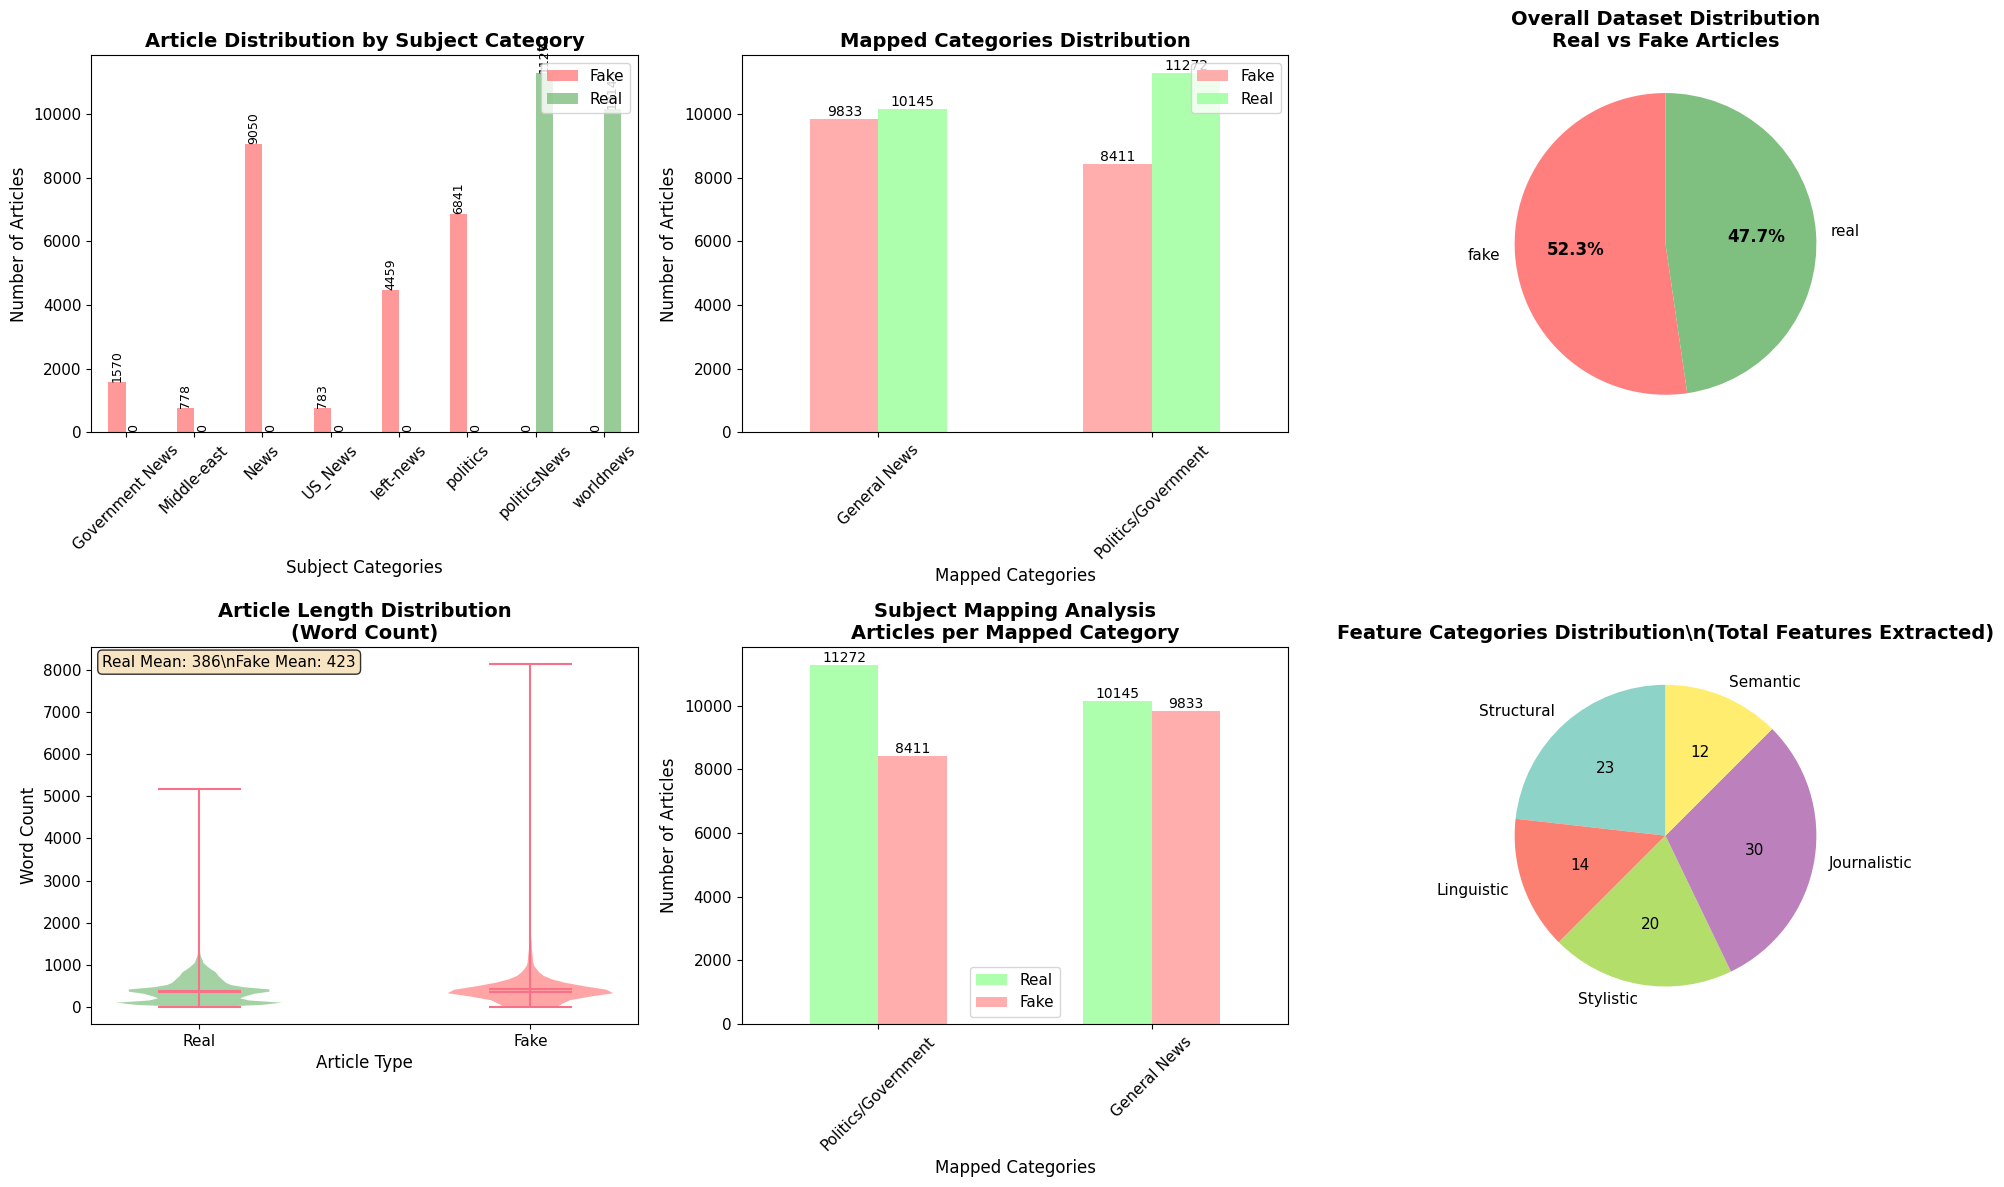

✅ Dataset overview visualizations created successfully!


In [37]:
# Dataset Overview Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Set up plotting parameters
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 11

print("📊 Creating Dataset Overview Visualizations")
print("=" * 50)

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 12))

# 1. Subject Distribution by Real/Fake
if 'subject_label_crosstab' in locals():
    ax1 = plt.subplot(2, 3, 1)
    
    # Prepare data for plotting (exclude totals)
    plot_data = subject_label_crosstab.drop('All', axis=0).drop('All', axis=1)
    
    # Create stacked bar chart
    plot_data.plot(kind='bar', ax=ax1, color=['#ff7f7f', '#7fbf7f'], alpha=0.8)
    ax1.set_title('Article Distribution by Subject Category', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Subject Categories', fontsize=12)
    ax1.set_ylabel('Number of Articles', fontsize=12)
    ax1.legend(['Fake', 'Real'], loc='upper right')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%d', rotation=90, fontsize=9)

# 2. Mapped Categories Distribution
if 'mapped_articles' in locals():
    ax2 = plt.subplot(2, 3, 2)
    
    # Create mapped category distribution
    mapped_dist = pd.crosstab(mapped_articles['mapped_category'], mapped_articles['label'])
    mapped_dist.plot(kind='bar', ax=ax2, color=['#ff9999', '#99ff99'], alpha=0.8)
    ax2.set_title('Mapped Categories Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Mapped Categories', fontsize=12)
    ax2.set_ylabel('Number of Articles', fontsize=12)
    ax2.legend(['Fake', 'Real'], loc='upper right')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%d', fontsize=10)

# 3. Overall Real vs Fake Distribution (Pie Chart)
if 'all_articles' in locals():
    ax3 = plt.subplot(2, 3, 3)
    
    label_counts = all_articles['label'].value_counts()
    colors = ['#ff7f7f', '#7fbf7f']
    
    wedges, texts, autotexts = ax3.pie(label_counts.values, labels=label_counts.index, 
                                       autopct='%1.1f%%', colors=colors, startangle=90)
    ax3.set_title('Overall Dataset Distribution\nReal vs Fake Articles', fontsize=14, fontweight='bold')
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)

# 4. Article Length Comparison
if 'full_features' in locals():
    ax4 = plt.subplot(2, 3, 4)
    
    # Extract word counts for real and fake articles
    real_lengths = full_features[full_features['label'] == 'real']['word_count']
    fake_lengths = full_features[full_features['label'] == 'fake']['word_count']
    
    # Create violin plots
    data_to_plot = [real_lengths, fake_lengths]
    parts = ax4.violinplot(data_to_plot, positions=[1, 2], showmeans=True, showmedians=True)
    
    # Customize colors
    colors = ['#7fbf7f', '#ff7f7f']
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    ax4.set_title('Article Length Distribution\n(Word Count)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Article Type', fontsize=12)
    ax4.set_ylabel('Word Count', fontsize=12)
    ax4.set_xticks([1, 2])
    ax4.set_xticklabels(['Real', 'Fake'])
    
    # Add statistics text
    real_mean = real_lengths.mean()
    fake_mean = fake_lengths.mean()
    ax4.text(0.02, 0.98, f'Real Mean: {real_mean:.0f}\\nFake Mean: {fake_mean:.0f}', 
             transform=ax4.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 5. Subject Mapping Visualization
ax5 = plt.subplot(2, 3, 5)

# Create a mapping visualization
if 'subject_mappings' in locals():
    categories = list(subject_mappings.keys())
    
    # Count articles in each mapping
    mapping_counts = []
    for category, mapping in subject_mappings.items():
        real_count = 0
        fake_count = 0
        
        if mapping['real_subjects']:
            real_count = len(all_articles[
                (all_articles['subject'].isin(mapping['real_subjects'])) & 
                (all_articles['label'] == 'real')
            ])
        
        if mapping['fake_subjects']:
            fake_count = len(all_articles[
                (all_articles['subject'].isin(mapping['fake_subjects'])) & 
                (all_articles['label'] == 'fake')
            ])
        
        mapping_counts.append({'category': category, 'real': real_count, 'fake': fake_count})
    
    mapping_df = pd.DataFrame(mapping_counts)
    mapping_df.set_index('category').plot(kind='bar', ax=ax5, color=['#99ff99', '#ff9999'], alpha=0.8)
    ax5.set_title('Subject Mapping Analysis\nArticles per Mapped Category', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Mapped Categories', fontsize=12)
    ax5.set_ylabel('Number of Articles', fontsize=12)
    ax5.legend(['Real', 'Fake'])
    ax5.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for container in ax5.containers:
        ax5.bar_label(container, fmt='%d', fontsize=10)

# 6. Feature Categories Overview
if 'full_features' in locals():
    ax6 = plt.subplot(2, 3, 6)
    
    feature_cols = [col for col in full_features.columns if col not in ['label', 'subject']]
    
    # Categorize features
    feature_categories = {
        'Structural': ['char_count', 'word_count', 'paragraph_count', 'sentence_count', 'avg_'],
        'Linguistic': ['flesch_', 'coleman_', 'gunning_', 'lexical_', 'syllables', 'function_word', 'vocabulary_'],
        'Stylistic': ['period_count', 'comma_count', 'exclamation_', 'question_', 'caps_', 'punctuation_', 'quote_'],
        'Journalistic': ['attribution_', 'certainty_', 'speculation_', 'bias_', 'sensational_', 'objectivity_', 'first_person', 'third_person'],
        'Semantic': ['sentiment_', 'polarity', 'subjectivity', 'topic_coherence', 'narrative_', 'abstract_', 'concrete_']
    }
    
    category_counts = []
    for category, patterns in feature_categories.items():
        count = sum(1 for feat in feature_cols if any(pattern in feat for pattern in patterns))
        category_counts.append(count)
    
    # Create pie chart
    colors_pie = plt.cm.Set3(np.linspace(0, 1, len(feature_categories)))
    wedges, texts, autotexts = ax6.pie(category_counts, labels=feature_categories.keys(), 
                                       autopct='%1.0f', colors=colors_pie, startangle=90)
    ax6.set_title('Feature Categories Distribution\\n(Total Features Extracted)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Dataset overview visualizations created successfully!")

### 5.2 Statistical Analysis Visualizations

Visualize the key statistical differences between real and fake articles across different feature categories.

📈 Creating Statistical Analysis Visualizations


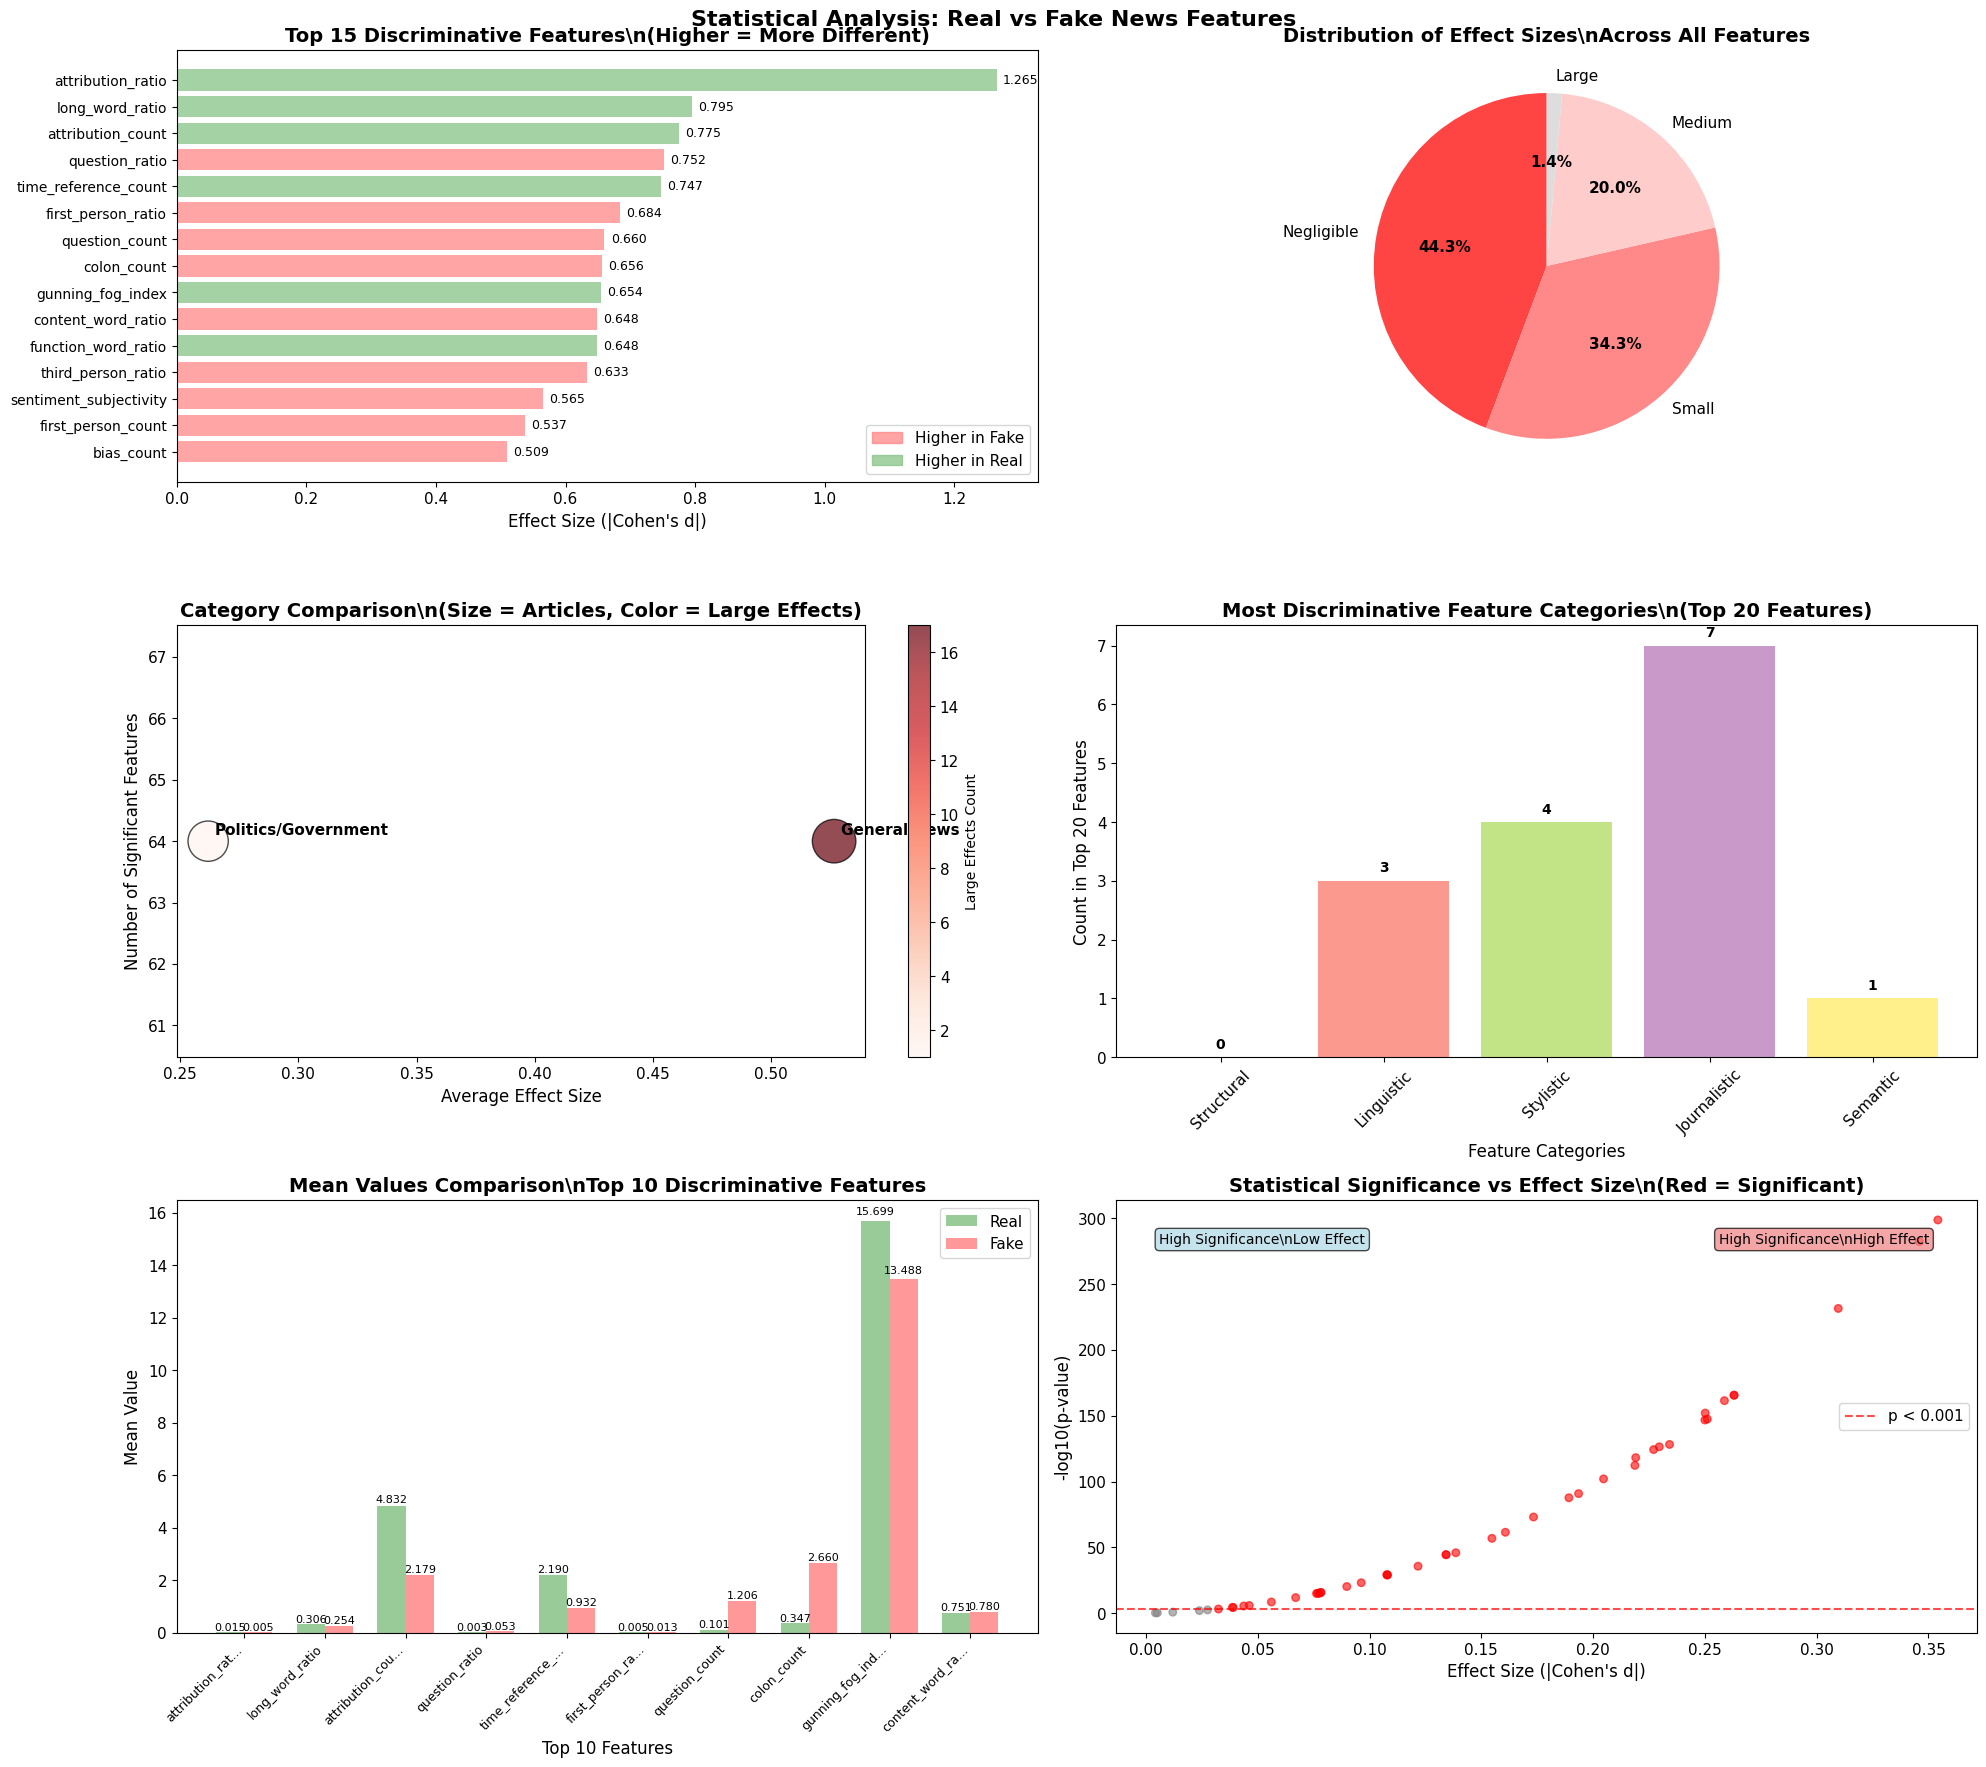

✅ Statistical analysis visualizations created successfully!


In [38]:
# Statistical Analysis Visualizations
print("📈 Creating Statistical Analysis Visualizations")
print("=" * 50)

import matplotlib.patches as mpatches

# Create figure with multiple subplots for statistical analysis
fig, axes = plt.subplots(3, 2, figsize=(20, 18))
fig.suptitle('Statistical Analysis: Real vs Fake News Features', fontsize=16, fontweight='bold', y=0.98)

# 1. Top Discriminative Features (Effect Sizes)
if 'article_differences' in locals():
    ax1 = axes[0, 0]
    top_features = article_differences.head(15)
    y_pos = range(len(top_features))
    colors = ['#ff7f7f' if d > 0 else '#7fbf7f' for d in top_features['cohens_d']]
    
    bars = ax1.barh(y_pos, top_features['abs_cohens_d'], color=colors, alpha=0.7)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(top_features['feature'], fontsize=10)
    ax1.set_xlabel('Effect Size (|Cohen\'s d|)', fontsize=12)
    ax1.set_title('Top 15 Discriminative Features\\n(Higher = More Different)', fontsize=14, fontweight='bold')
    ax1.invert_yaxis()
    
    for i, (bar, val) in enumerate(zip(bars, top_features['abs_cohens_d'])):
        ax1.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)
    
    red_patch = mpatches.Patch(color='#ff7f7f', alpha=0.7, label='Higher in Fake')
    green_patch = mpatches.Patch(color='#7fbf7f', alpha=0.7, label='Higher in Real')
    ax1.legend(handles=[red_patch, green_patch])

# 2. Effect Size Distribution
if 'article_differences' in locals():
    ax2 = axes[0, 1]
    effect_categories = article_differences['effect_size_category'].value_counts()
    colors = ['#ff4444', '#ff8888', '#ffcccc', '#dddddd']
    
    wedges, texts, autotexts = ax2.pie(effect_categories.values, labels=effect_categories.index, autopct='%1.1f%%', colors=colors, startangle=90)
    ax2.set_title('Distribution of Effect Sizes\\nAcross All Features', fontsize=14, fontweight='bold')
    
    for autotext in autotexts:
        autotext.set_fontweight('bold')

# 3. Cross-Category Comparison (Mapped Results)
if 'mapped_comparison_df' in locals():
    ax3 = axes[1, 0]
    categories = mapped_comparison_df['category']
    avg_effects = mapped_comparison_df['avg_effect_size']
    n_significant = mapped_comparison_df['n_significant']
    
    scatter = ax3.scatter(avg_effects, n_significant, s=mapped_comparison_df['n_fake']/10, c=mapped_comparison_df['n_large_effect'], cmap='Reds', alpha=0.7, edgecolors='black')
    
    for i, category in enumerate(categories):
        ax3.annotate(category, (avg_effects.iloc[i], n_significant.iloc[i]), xytext=(5, 5), textcoords='offset points', fontsize=11, fontweight='bold')
    
    ax3.set_xlabel('Average Effect Size', fontsize=12)
    ax3.set_ylabel('Number of Significant Features', fontsize=12)
    ax3.set_title('Category Comparison\\n(Size = Articles, Color = Large Effects)', fontsize=14, fontweight='bold')
    
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Large Effects Count', fontsize=10)

# 4. Feature Category Analysis
if 'article_differences' in locals():
    ax4 = axes[1, 1]
    top_20_features = article_differences.head(20)
    
    feature_categories = {
        'Structural': ['char_count', 'word_count', 'paragraph_count', 'sentence_count', 'avg_'],
        'Linguistic': ['flesch_', 'coleman_', 'gunning_', 'lexical_', 'syllables', 'function_word', 'vocabulary_'],
        'Stylistic': ['period_count', 'comma_count', 'exclamation_', 'question_', 'caps_', 'punctuation_', 'quote_'],
        'Journalistic': ['attribution_', 'certainty_', 'speculation_', 'bias_', 'sensational_', 'objectivity_', 'first_person', 'third_person'],
        'Semantic': ['sentiment_', 'polarity', 'subjectivity', 'topic_coherence', 'narrative_', 'abstract_', 'concrete_']
    }
    
    category_top_counts = {cat: 0 for cat in feature_categories.keys()}
    
    for _, row in top_20_features.iterrows():
        feature = row['feature']
        for category, patterns in feature_categories.items():
            if any(pattern in feature for pattern in patterns):
                category_top_counts[category] += 1
                break
    
    cats = list(category_top_counts.keys())
    counts = list(category_top_counts.values())
    
    bars = ax4.bar(cats, counts, color=plt.cm.Set3(np.linspace(0, 1, len(cats))), alpha=0.8)
    ax4.set_xlabel('Feature Categories', fontsize=12)
    ax4.set_ylabel('Count in Top 20 Features', fontsize=12)
    ax4.set_title('Most Discriminative Feature Categories\\n(Top 20 Features)', fontsize=14, fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1, f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 5. Real vs Fake Mean Comparison (Top Features)
if 'article_differences' in locals():
    ax5 = axes[2, 0]
    top_10 = article_differences.head(10)
    x = range(len(top_10))
    width = 0.35
    
    real_means = top_10['real_mean']
    fake_means = top_10['fake_mean']
    
    bars1 = ax5.bar([i - width/2 for i in x], real_means, width, label='Real', color='#7fbf7f', alpha=0.8)
    bars2 = ax5.bar([i + width/2 for i in x], fake_means, width, label='Fake', color='#ff7f7f', alpha=0.8)
    
    ax5.set_xlabel('Top 10 Features', fontsize=12)
    ax5.set_ylabel('Mean Value', fontsize=12)
    ax5.set_title('Mean Values Comparison\\nTop 10 Discriminative Features', fontsize=14, fontweight='bold')
    ax5.set_xticks(x)
    ax5.set_xticklabels([feat[:15] + '...' if len(feat) > 15 else feat for feat in top_10['feature']], rotation=45, ha='right', fontsize=9)
    ax5.legend()
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height + height*0.01, f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 6. P-value vs Effect Size Scatter
if 'article_differences' in locals():
    ax6 = axes[2, 1]
    significant = article_differences['significant_t']
    colors = ['red' if sig else 'gray' for sig in significant]
    
    scatter = ax6.scatter(article_differences['abs_cohens_d'], -np.log10(article_differences['p_value']), c=colors, alpha=0.6, s=30)
    
    ax6.set_xlabel('Effect Size (|Cohen\'s d|)', fontsize=12)
    ax6.set_ylabel('-log10(p-value)', fontsize=12)
    ax6.set_title('Statistical Significance vs Effect Size\\n(Red = Significant)', fontsize=14, fontweight='bold')
    
    ax6.axhline(y=-np.log10(0.001), color='red', linestyle='--', alpha=0.7, label='p < 0.001')
    ax6.legend()
    
    ax6.text(0.7, 0.9, 'High Significance\\nHigh Effect', transform=ax6.transAxes, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7), fontsize=10)
    ax6.text(0.05, 0.9, 'High Significance\\nLow Effect', transform=ax6.transAxes, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7), fontsize=10)

plt.tight_layout()
plt.show()

print("✅ Statistical analysis visualizations created successfully!")

### 5.3 N-gram Analysis Visualizations

Now let's visualize the results from our cross-subject n-gram analysis to see the distinctive vocabulary patterns between real and fake news.

📝 Creating N-gram Analysis Visualizations


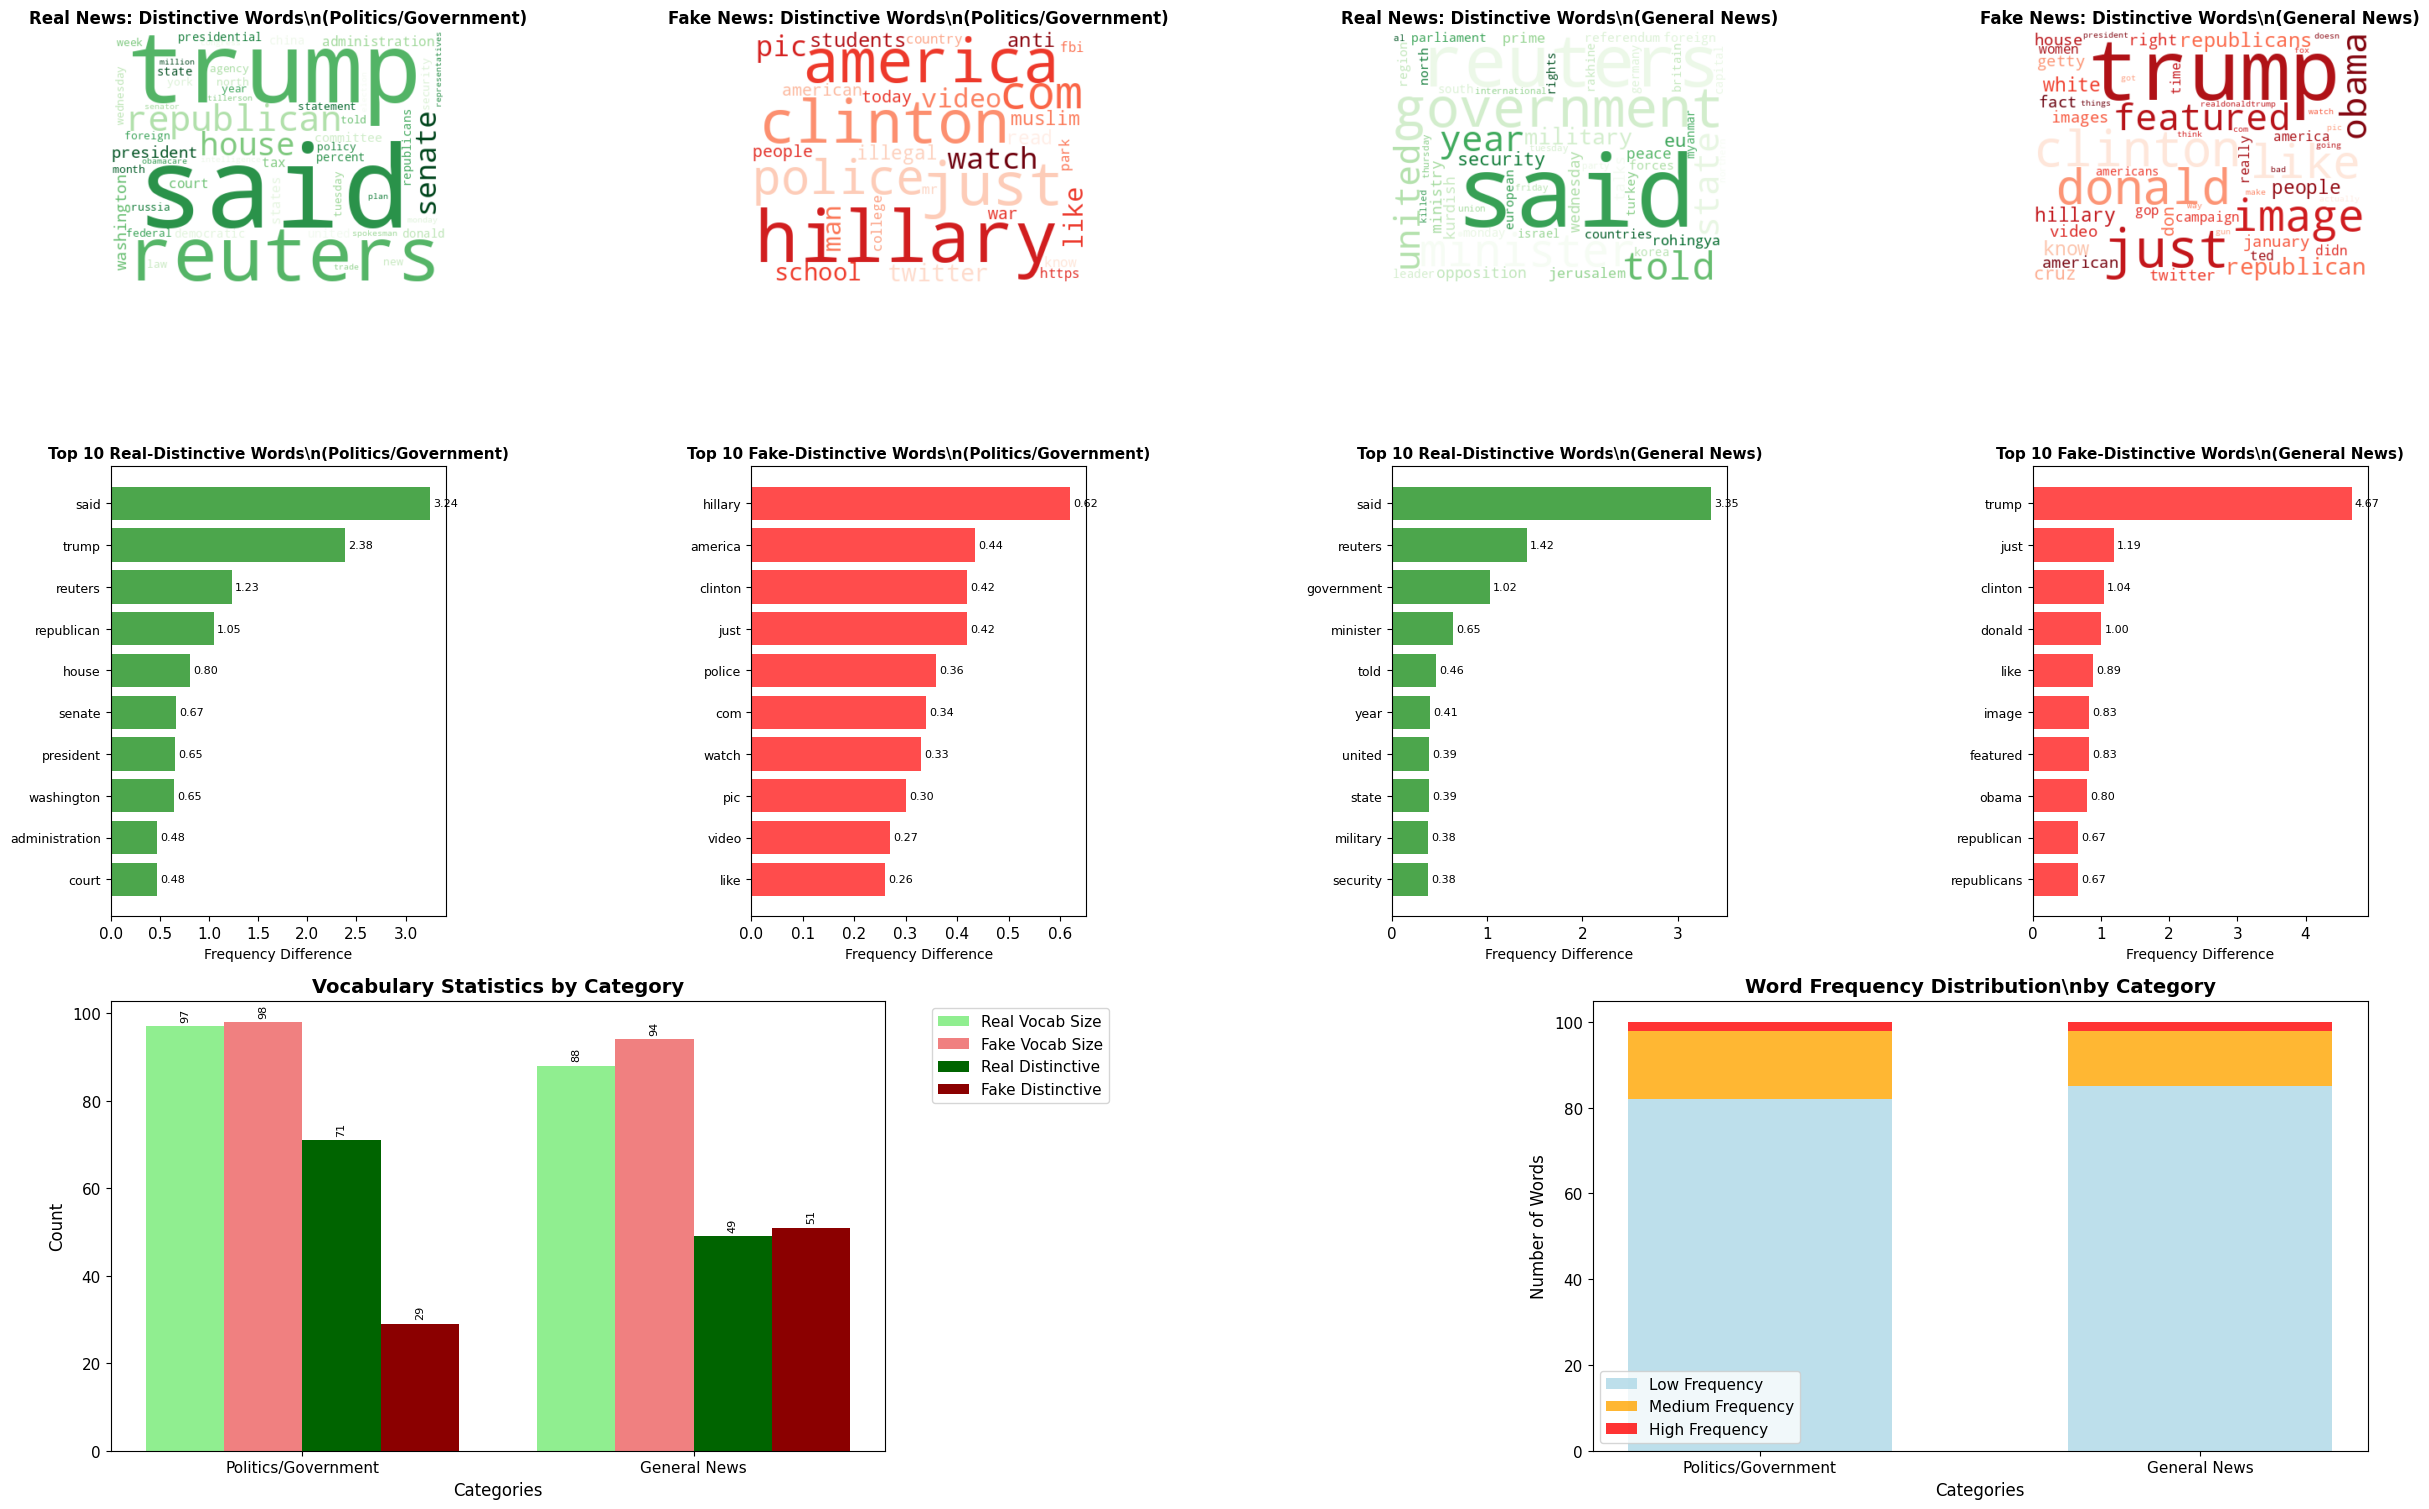

✅ N-gram analysis visualizations created successfully!


In [45]:
# N-gram Analysis Visualizations
print("📝 Creating N-gram Analysis Visualizations")
print("=" * 50)

from wordcloud import WordCloud
import pandas as pd

# Create comprehensive n-gram visualization
fig = plt.figure(figsize=(24, 16))

# Convert category keys to match expected format
category_mapping = {
    'Politics/Government': 'politics_government',
    'General News': 'general_news'
}

# 1. Word Clouds for Politics/Government Category
if 'ngram_results' in locals() and 'Politics/Government' in ngram_results:
    
    politics_results = ngram_results['Politics/Government']
    
    # Extract real-dominant words (where real_freq > fake_freq)
    real_words = {}
    fake_words = {}
    
    if 'unigrams' in politics_results:
        for item in politics_results['unigrams'][:100]:  # Top 100 unigrams
            ngram = item['ngram']
            real_freq = float(item['real_freq'])
            fake_freq = float(item['fake_freq'])
            
            if real_freq > fake_freq:
                real_words[ngram] = real_freq - fake_freq
            elif fake_freq > real_freq:
                fake_words[ngram] = fake_freq - real_freq
    
    # Real News Word Cloud (Politics)
    ax1 = plt.subplot(3, 4, 1)
    if real_words:
        wordcloud_real = WordCloud(width=400, height=300, background_color='white', 
                                 colormap='Greens', max_words=50).generate_from_frequencies(real_words)
        ax1.imshow(wordcloud_real, interpolation='bilinear')
        ax1.set_title('Real News: Distinctive Words\\n(Politics/Government)', fontsize=12, fontweight='bold')
    else:
        ax1.text(0.5, 0.5, 'No distinctive words\\nfound', ha='center', va='center', fontsize=14)
        ax1.set_title('Real News: Distinctive Words\\n(Politics/Government)', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    # Fake News Word Cloud (Politics)
    ax2 = plt.subplot(3, 4, 2)
    if fake_words:
        wordcloud_fake = WordCloud(width=400, height=300, background_color='white', 
                                 colormap='Reds', max_words=50).generate_from_frequencies(fake_words)
        ax2.imshow(wordcloud_fake, interpolation='bilinear')
        ax2.set_title('Fake News: Distinctive Words\\n(Politics/Government)', fontsize=12, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No distinctive words\\nfound', ha='center', va='center', fontsize=14)
        ax2.set_title('Fake News: Distinctive Words\\n(Politics/Government)', fontsize=12, fontweight='bold')
    ax2.axis('off')

# 2. Word Clouds for General News Category  
if 'ngram_results' in locals() and 'General News' in ngram_results:
    
    general_results = ngram_results['General News']
    
    # Extract real-dominant and fake-dominant words
    real_words_gen = {}
    fake_words_gen = {}
    
    if 'unigrams' in general_results:
        for item in general_results['unigrams'][:100]:  # Top 100 unigrams
            ngram = item['ngram']
            real_freq = float(item['real_freq'])
            fake_freq = float(item['fake_freq'])
            
            if real_freq > fake_freq:
                real_words_gen[ngram] = real_freq - fake_freq
            elif fake_freq > real_freq:
                fake_words_gen[ngram] = fake_freq - real_freq
    
    # Real News Word Cloud (General)
    ax3 = plt.subplot(3, 4, 3)
    if real_words_gen:
        wordcloud_real = WordCloud(width=400, height=300, background_color='white', 
                                 colormap='Greens', max_words=50).generate_from_frequencies(real_words_gen)
        ax3.imshow(wordcloud_real, interpolation='bilinear')
        ax3.set_title('Real News: Distinctive Words\\n(General News)', fontsize=12, fontweight='bold')
    else:
        ax3.text(0.5, 0.5, 'No distinctive words\\nfound', ha='center', va='center', fontsize=14)
        ax3.set_title('Real News: Distinctive Words\\n(General News)', fontsize=12, fontweight='bold')
    ax3.axis('off')
    
    # Fake News Word Cloud (General)
    ax4 = plt.subplot(3, 4, 4)
    if fake_words_gen:
        wordcloud_fake = WordCloud(width=400, height=300, background_color='white', 
                                 colormap='Reds', max_words=50).generate_from_frequencies(fake_words_gen)
        ax4.imshow(wordcloud_fake, interpolation='bilinear')
        ax4.set_title('Fake News: Distinctive Words\\n(General News)', fontsize=12, fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'No distinctive words\\nfound', ha='center', va='center', fontsize=14)
        ax4.set_title('Fake News: Distinctive Words\\n(General News)', fontsize=12, fontweight='bold')
    ax4.axis('off')

# 3. Top Distinctive Words Bar Charts
if 'ngram_results' in locals():
    
    # Politics/Government - Top Real Words
    ax5 = plt.subplot(3, 4, 5)
    if 'Politics/Government' in ngram_results and real_words:
        top_real_politics = sorted(real_words.items(), key=lambda x: x[1], reverse=True)[:10]
        if top_real_politics:
            words, counts = zip(*top_real_politics)
            y_pos = range(len(words))
            bars = ax5.barh(y_pos, counts, color='green', alpha=0.7)
            ax5.set_yticks(y_pos)
            ax5.set_yticklabels(words, fontsize=9)
            ax5.set_xlabel('Frequency Difference', fontsize=10)
            ax5.set_title('Top 10 Real-Distinctive Words\\n(Politics/Government)', fontsize=11, fontweight='bold')
            ax5.invert_yaxis()
            
            for i, bar in enumerate(bars):
                width = bar.get_width()
                ax5.text(width + max(counts)*0.01, bar.get_y() + bar.get_height()/2, 
                        f'{width:.2f}', ha='left', va='center', fontsize=8)
        else:
            ax5.text(0.5, 0.5, 'No data\\navailable', ha='center', va='center', fontsize=12)
    else:
        ax5.text(0.5, 0.5, 'No data\\navailable', ha='center', va='center', fontsize=12)
    ax5.set_title('Top 10 Real-Distinctive Words\\n(Politics/Government)', fontsize=11, fontweight='bold')
    
    # Politics/Government - Top Fake Words
    ax6 = plt.subplot(3, 4, 6)
    if 'Politics/Government' in ngram_results and fake_words:
        top_fake_politics = sorted(fake_words.items(), key=lambda x: x[1], reverse=True)[:10]
        if top_fake_politics:
            words, counts = zip(*top_fake_politics)
            y_pos = range(len(words))
            bars = ax6.barh(y_pos, counts, color='red', alpha=0.7)
            ax6.set_yticks(y_pos)
            ax6.set_yticklabels(words, fontsize=9)
            ax6.set_xlabel('Frequency Difference', fontsize=10)
            ax6.set_title('Top 10 Fake-Distinctive Words\\n(Politics/Government)', fontsize=11, fontweight='bold')
            ax6.invert_yaxis()
            
            for i, bar in enumerate(bars):
                width = bar.get_width()
                ax6.text(width + max(counts)*0.01, bar.get_y() + bar.get_height()/2, 
                        f'{width:.2f}', ha='left', va='center', fontsize=8)
        else:
            ax6.text(0.5, 0.5, 'No data\\navailable', ha='center', va='center', fontsize=12)
    else:
        ax6.text(0.5, 0.5, 'No data\\navailable', ha='center', va='center', fontsize=12)
    ax6.set_title('Top 10 Fake-Distinctive Words\\n(Politics/Government)', fontsize=11, fontweight='bold')
    
    # General News - Top Real Words
    ax7 = plt.subplot(3, 4, 7)
    if 'General News' in ngram_results and real_words_gen:
        top_real_general = sorted(real_words_gen.items(), key=lambda x: x[1], reverse=True)[:10]
        if top_real_general:
            words, counts = zip(*top_real_general)
            y_pos = range(len(words))
            bars = ax7.barh(y_pos, counts, color='green', alpha=0.7)
            ax7.set_yticks(y_pos)
            ax7.set_yticklabels(words, fontsize=9)
            ax7.set_xlabel('Frequency Difference', fontsize=10)
            ax7.set_title('Top 10 Real-Distinctive Words\\n(General News)', fontsize=11, fontweight='bold')
            ax7.invert_yaxis()
            
            for i, bar in enumerate(bars):
                width = bar.get_width()
                ax7.text(width + max(counts)*0.01, bar.get_y() + bar.get_height()/2, 
                        f'{width:.2f}', ha='left', va='center', fontsize=8)
        else:
            ax7.text(0.5, 0.5, 'No data\\navailable', ha='center', va='center', fontsize=12)
    else:
        ax7.text(0.5, 0.5, 'No data\\navailable', ha='center', va='center', fontsize=12)
    ax7.set_title('Top 10 Real-Distinctive Words\\n(General News)', fontsize=11, fontweight='bold')
    
    # General News - Top Fake Words
    ax8 = plt.subplot(3, 4, 8)
    if 'General News' in ngram_results and fake_words_gen:
        top_fake_general = sorted(fake_words_gen.items(), key=lambda x: x[1], reverse=True)[:10]
        if top_fake_general:
            words, counts = zip(*top_fake_general)
            y_pos = range(len(words))
            bars = ax8.barh(y_pos, counts, color='red', alpha=0.7)
            ax8.set_yticks(y_pos)
            ax8.set_yticklabels(words, fontsize=9)
            ax8.set_xlabel('Frequency Difference', fontsize=10)
            ax8.set_title('Top 10 Fake-Distinctive Words\\n(General News)', fontsize=11, fontweight='bold')
            ax8.invert_yaxis()
            
            for i, bar in enumerate(bars):
                width = bar.get_width()
                ax8.text(width + max(counts)*0.01, bar.get_y() + bar.get_height()/2, 
                        f'{width:.2f}', ha='left', va='center', fontsize=8)
        else:
            ax8.text(0.5, 0.5, 'No data\\navailable', ha='center', va='center', fontsize=12)
    else:
        ax8.text(0.5, 0.5, 'No data\\navailable', ha='center', va='center', fontsize=12)
    ax8.set_title('Top 10 Fake-Distinctive Words\\n(General News)', fontsize=11, fontweight='bold')

# 4. Vocabulary Statistics Summary
ax9 = plt.subplot(3, 2, 5)

if 'ngram_results' in locals():
    categories = []
    real_vocab_sizes = []
    fake_vocab_sizes = []
    real_distinctive_counts = []
    fake_distinctive_counts = []
    
    for category_name, results in ngram_results.items():
        categories.append(category_name)
        
        if 'unigrams' in results:
            total_real_words = 0
            total_fake_words = 0
            real_distinctive = 0
            fake_distinctive = 0
            
            for item in results['unigrams']:
                real_freq = float(item['real_freq'])
                fake_freq = float(item['fake_freq'])
                
                if real_freq > 0:
                    total_real_words += 1
                if fake_freq > 0:
                    total_fake_words += 1
                    
                if real_freq > fake_freq:
                    real_distinctive += 1
                elif fake_freq > real_freq:
                    fake_distinctive += 1
            
            real_vocab_sizes.append(total_real_words)
            fake_vocab_sizes.append(total_fake_words)
            real_distinctive_counts.append(real_distinctive)
            fake_distinctive_counts.append(fake_distinctive)
        else:
            real_vocab_sizes.append(0)
            fake_vocab_sizes.append(0)
            real_distinctive_counts.append(0)
            fake_distinctive_counts.append(0)
    
    x = range(len(categories))
    width = 0.2
    
    bars1 = ax9.bar([i - width*1.5 for i in x], real_vocab_sizes, width, label='Real Vocab Size', color='lightgreen')
    bars2 = ax9.bar([i - width*0.5 for i in x], fake_vocab_sizes, width, label='Fake Vocab Size', color='lightcoral')
    bars3 = ax9.bar([i + width*0.5 for i in x], real_distinctive_counts, width, label='Real Distinctive', color='darkgreen')
    bars4 = ax9.bar([i + width*1.5 for i in x], fake_distinctive_counts, width, label='Fake Distinctive', color='darkred')
    
    ax9.set_xlabel('Categories', fontsize=12)
    ax9.set_ylabel('Count', fontsize=12)
    ax9.set_title('Vocabulary Statistics by Category', fontsize=14, fontweight='bold')
    ax9.set_xticks(x)
    ax9.set_xticklabels(categories)
    ax9.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add value labels
    for bars in [bars1, bars2, bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax9.text(bar.get_x() + bar.get_width()/2., height + max(max(real_vocab_sizes), max(fake_vocab_sizes))*0.01, 
                        f'{int(height)}', ha='center', va='bottom', fontsize=8, rotation=90)

# 5. Frequency Distribution Analysis
ax10 = plt.subplot(3, 2, 6)

if 'ngram_results' in locals() and len(ngram_results) >= 1:
    
    # Create comparison of word frequency patterns
    category_names = list(ngram_results.keys())
    
    freq_ranges = ['Low (0-1)', 'Medium (1-5)', 'High (5+)']
    category_distributions = []
    
    for category in category_names:
        if 'unigrams' in ngram_results[category]:
            low_count = 0
            medium_count = 0
            high_count = 0
            
            for item in ngram_results[category]['unigrams']:
                total_freq = float(item['real_freq']) + float(item['fake_freq'])
                
                if total_freq <= 1:
                    low_count += 1
                elif total_freq <= 5:
                    medium_count += 1
                else:
                    high_count += 1
            
            category_distributions.append([low_count, medium_count, high_count])
    
    if category_distributions:
        # Create stacked bar chart
        x = range(len(category_names))
        width = 0.6
        
        low_counts = [dist[0] for dist in category_distributions]
        medium_counts = [dist[1] for dist in category_distributions]
        high_counts = [dist[2] for dist in category_distributions]
        
        bars1 = ax10.bar(x, low_counts, width, label='Low Frequency', color='lightblue', alpha=0.8)
        bars2 = ax10.bar(x, medium_counts, width, bottom=low_counts, label='Medium Frequency', color='orange', alpha=0.8)
        bars3 = ax10.bar(x, high_counts, width, bottom=[low_counts[i] + medium_counts[i] for i in range(len(x))], label='High Frequency', color='red', alpha=0.8)
        
        ax10.set_xlabel('Categories', fontsize=12)
        ax10.set_ylabel('Number of Words', fontsize=12)
        ax10.set_title('Word Frequency Distribution\\nby Category', fontsize=14, fontweight='bold')
        ax10.set_xticks(x)
        ax10.set_xticklabels(category_names)
        ax10.legend()
    else:
        ax10.text(0.5, 0.5, 'No frequency data\\navailable', ha='center', va='center', fontsize=14)
        ax10.set_title('Word Frequency Distribution', fontsize=14, fontweight='bold')
else:
    ax10.text(0.5, 0.5, 'Insufficient data\\nfor analysis', ha='center', va='center', fontsize=14)
    ax10.set_title('Word Frequency Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ N-gram analysis visualizations created successfully!")

### 5.4 Topic Modeling Visualizations

Finally, let's visualize our topic modeling results to understand the thematic differences between real and fake news across different subject categories.

🎯 Creating Topic Modeling Visualizations


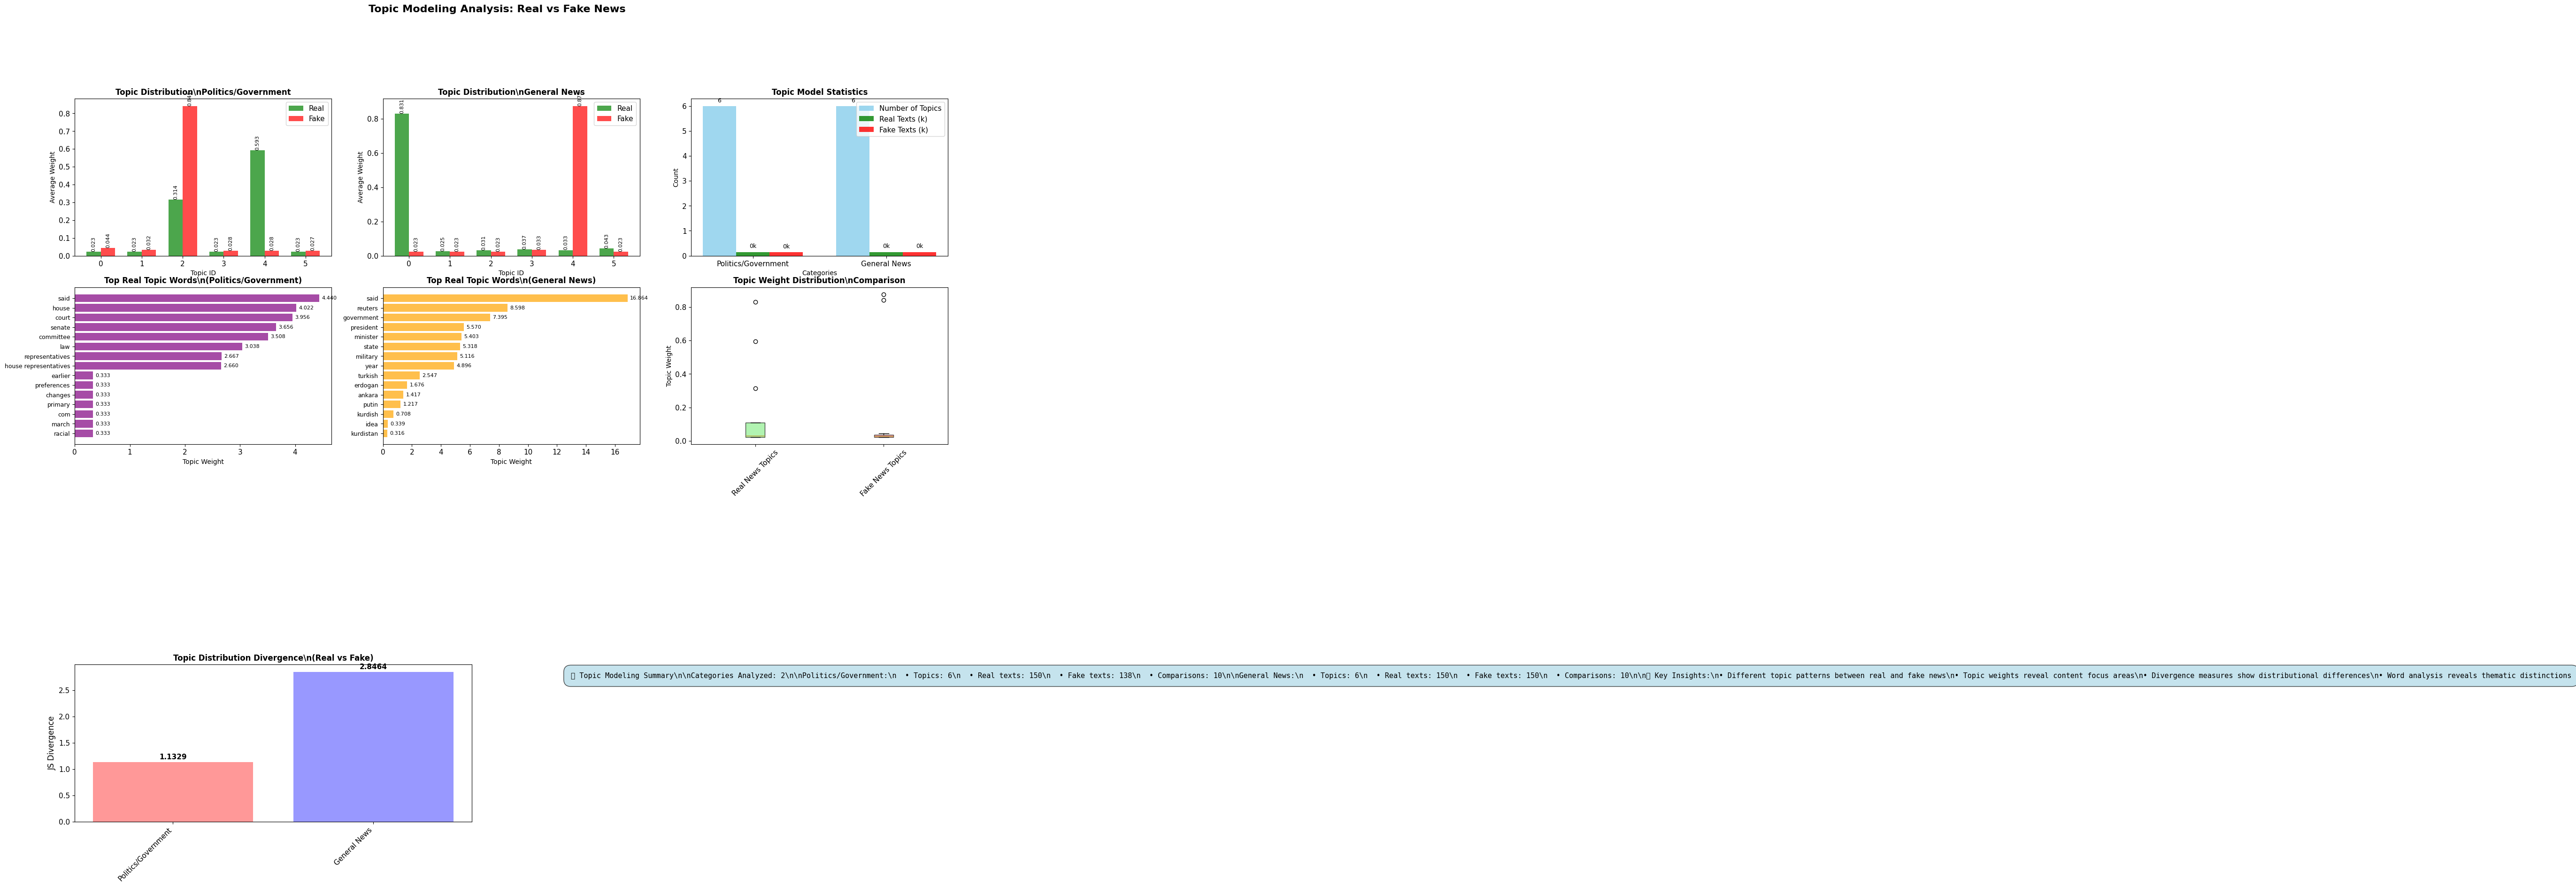

✅ Topic modeling visualizations created successfully!


In [49]:
# Topic Modeling Visualizations
print("🎯 Creating Topic Modeling Visualizations")
print("=" * 50)

# Create comprehensive topic modeling visualization
fig = plt.figure(figsize=(24, 20))

# 1. Topic Distribution Comparison
if 'topic_results' in locals():
    
    # Politics/Government Topics
    if 'Politics/Government' in topic_results:
        politics_topics = topic_results['Politics/Government']
        
        ax1 = plt.subplot(4, 3, 1)
        if 'real_topic_weights' in politics_topics and 'fake_topic_weights' in politics_topics:
            real_weights = politics_topics['real_topic_weights']
            fake_weights = politics_topics['fake_topic_weights']
            n_topics = len(real_weights)
            
            x = np.arange(n_topics)
            width = 0.35
            
            bars1 = ax1.bar(x - width/2, real_weights, width, label='Real', color='green', alpha=0.7)
            bars2 = ax1.bar(x + width/2, fake_weights, width, label='Fake', color='red', alpha=0.7)
            
            ax1.set_xlabel('Topic ID', fontsize=10)
            ax1.set_ylabel('Average Weight', fontsize=10)
            ax1.set_title('Topic Distribution\\nPolitics/Government', fontsize=12, fontweight='bold')
            ax1.set_xticks(x)
            ax1.legend()
            
            # Add value labels
            for bars in [bars1, bars2]:
                for bar in bars:
                    height = bar.get_height()
                    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001, 
                            f'{height:.3f}', ha='center', va='bottom', fontsize=8, rotation=90)
        else:
            ax1.text(0.5, 0.5, 'No topic\\ndistribution data', ha='center', va='center', fontsize=12)
            ax1.set_title('Topic Distribution\\nPolitics/Government', fontsize=12, fontweight='bold')
    
    # General News Topics  
    if 'General News' in topic_results:
        general_topics = topic_results['General News']
        
        ax2 = plt.subplot(4, 3, 2)
        if 'real_topic_weights' in general_topics and 'fake_topic_weights' in general_topics:
            real_weights = general_topics['real_topic_weights']
            fake_weights = general_topics['fake_topic_weights']
            n_topics = len(real_weights)
            
            x = np.arange(n_topics)
            width = 0.35
            
            bars1 = ax2.bar(x - width/2, real_weights, width, label='Real', color='green', alpha=0.7)
            bars2 = ax2.bar(x + width/2, fake_weights, width, label='Fake', color='red', alpha=0.7)
            
            ax2.set_xlabel('Topic ID', fontsize=10)
            ax2.set_ylabel('Average Weight', fontsize=10)
            ax2.set_title('Topic Distribution\\nGeneral News', fontsize=12, fontweight='bold')
            ax2.set_xticks(x)
            ax2.legend()
            
            # Add value labels
            for bars in [bars1, bars2]:
                for bar in bars:
                    height = bar.get_height()
                    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001, 
                            f'{height:.3f}', ha='center', va='bottom', fontsize=8, rotation=90)
        else:
            ax2.text(0.5, 0.5, 'No topic\\ndistribution data', ha='center', va='center', fontsize=12)
            ax2.set_title('Topic Distribution\\nGeneral News', fontsize=12, fontweight='bold')

# 2. Model Performance Metrics
ax3 = plt.subplot(4, 3, 3)

if 'topic_results' in locals():
    categories = []
    n_topics_list = []
    n_real_texts = []
    n_fake_texts = []
    
    for category, results in topic_results.items():
        categories.append(category)
        n_topics_list.append(len(results.get('real_topic_weights', [])))
        n_real_texts.append(results.get('n_real_texts', 0))
        n_fake_texts.append(results.get('n_fake_texts', 0))
    
    x = range(len(categories))
    width = 0.25
    
    bars1 = ax3.bar([i - width for i in x], n_topics_list, width, 
                   label='Number of Topics', color='skyblue', alpha=0.8)
    bars2 = ax3.bar([i for i in x], [n/1000 for n in n_real_texts], width, 
                   label='Real Texts (k)', color='green', alpha=0.8)
    bars3 = ax3.bar([i + width for i in x], [n/1000 for n in n_fake_texts], width, 
                   label='Fake Texts (k)', color='red', alpha=0.8)
    
    ax3.set_xlabel('Categories', fontsize=10)
    ax3.set_ylabel('Count', fontsize=10)
    ax3.set_title('Topic Model Statistics', fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(categories)
    ax3.legend()
    
    # Add value labels
    for i, (bar1, bar2, bar3) in enumerate(zip(bars1, bars2, bars3)):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        height3 = bar3.get_height()
        
        ax3.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.1, 
                f'{n_topics_list[i]}', ha='center', va='bottom', fontsize=9)
        ax3.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.1, 
                f'{n_real_texts[i]//1000}k', ha='center', va='bottom', fontsize=9)
        ax3.text(bar3.get_x() + bar3.get_width()/2., height3 + 0.1, 
                f'{n_fake_texts[i]//1000}k', ha='center', va='bottom', fontsize=9)

else:
    ax3.text(0.5, 0.5, 'No topic modeling\\ndata available', ha='center', va='center', fontsize=12)
    ax3.set_title('Model Performance Metrics', fontsize=12, fontweight='bold')

# 3. Top Topic Words Visualization
if 'topic_results' in locals():
    
    # Politics/Government Top Words
    ax4 = plt.subplot(4, 3, 4)
    if 'Politics/Government' in topic_results and 'real_topics' in topic_results['Politics/Government']:
        real_topics = topic_results['Politics/Government']['real_topics']
        
        # Extract top words from all real topics
        word_freq = {}
        for topic in real_topics[:3]:  # Top 3 topics
            if 'words' in topic and 'weights' in topic:
                words = topic['words']
                weights = topic['weights']
                for word, weight in zip(words, weights):
                    if word in word_freq:
                        word_freq[word] += float(weight)
                    else:
                        word_freq[word] = float(weight)
        
        # Get top 15 overall words
        if word_freq:
            sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:15]
            words, frequencies = zip(*sorted_words)
            y_pos = range(len(words))
            
            bars = ax4.barh(y_pos, frequencies, color='purple', alpha=0.7)
            ax4.set_yticks(y_pos)
            ax4.set_yticklabels(words, fontsize=9)
            ax4.set_xlabel('Topic Weight', fontsize=10)
            ax4.set_title('Top Real Topic Words\\n(Politics/Government)', fontsize=12, fontweight='bold')
            ax4.invert_yaxis()
            
            # Add value labels
            for bar in bars:
                width = bar.get_width()
                ax4.text(width + max(frequencies)*0.01, bar.get_y() + bar.get_height()/2, 
                        f'{width:.3f}', ha='left', va='center', fontsize=8)
        else:
            ax4.text(0.5, 0.5, 'No topic words\\navailable', ha='center', va='center', fontsize=12)
    else:
        ax4.text(0.5, 0.5, 'No topic words\\navailable', ha='center', va='center', fontsize=12)
    
    # General News Top Words
    ax5 = plt.subplot(4, 3, 5)
    if 'General News' in topic_results and 'real_topics' in topic_results['General News']:
        real_topics = topic_results['General News']['real_topics']
        
        # Extract top words from all real topics
        word_freq = {}
        for topic in real_topics[:3]:  # Top 3 topics
            if 'words' in topic and 'weights' in topic:
                words = topic['words']
                weights = topic['weights']
                for word, weight in zip(words, weights):
                    if word in word_freq:
                        word_freq[word] += float(weight)
                    else:
                        word_freq[word] = float(weight)
        
        # Get top 15 overall words
        if word_freq:
            sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:15]
            words, frequencies = zip(*sorted_words)
            y_pos = range(len(words))
            
            bars = ax5.barh(y_pos, frequencies, color='orange', alpha=0.7)
            ax5.set_yticks(y_pos)
            ax5.set_yticklabels(words, fontsize=9)
            ax5.set_xlabel('Topic Weight', fontsize=10)
            ax5.set_title('Top Real Topic Words\\n(General News)', fontsize=12, fontweight='bold')
            ax5.invert_yaxis()
            
            # Add value labels
            for bar in bars:
                width = bar.get_width()
                ax5.text(width + max(frequencies)*0.01, bar.get_y() + bar.get_height()/2, 
                        f'{width:.3f}', ha='left', va='center', fontsize=8)
        else:
            ax5.text(0.5, 0.5, 'No topic words\\navailable', ha='center', va='center', fontsize=12)
    else:
        ax5.text(0.5, 0.5, 'No topic words\\navailable', ha='center', va='center', fontsize=12)

# 4. Topic Weight Comparison
ax6 = plt.subplot(4, 3, 6)

if 'topic_results' in locals():
    # Collect topic weights for comparison
    all_real_weights = []
    all_fake_weights = []
    labels = []
    
    for category, results in topic_results.items():
        if 'real_topic_weights' in results and 'fake_topic_weights' in results:
            real_weights = results['real_topic_weights']
            fake_weights = results['fake_topic_weights']
            
            all_real_weights.extend(real_weights)
            all_fake_weights.extend(fake_weights)
            labels.extend([f"{category}_R"] * len(real_weights))
            labels.extend([f"{category}_F"] * len(fake_weights))
    
    if all_real_weights and all_fake_weights:
        # Create box plot comparison
        data_to_plot = [all_real_weights, all_fake_weights]
        box_labels = ['Real News Topics', 'Fake News Topics']
        
        box_plot = ax6.boxplot(data_to_plot, labels=box_labels, patch_artist=True)
        
        # Color the boxes
        colors = ['lightgreen', 'lightcoral']
        for patch, color in zip(box_plot['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax6.set_ylabel('Topic Weight', fontsize=10)
        ax6.set_title('Topic Weight Distribution\\nComparison', fontsize=12, fontweight='bold')
        ax6.tick_params(axis='x', rotation=45)
    else:
        ax6.text(0.5, 0.5, 'No weight data\\navailable', ha='center', va='center', fontsize=12)
        ax6.set_title('Topic Weight Distribution', fontsize=12, fontweight='bold')
else:
    ax6.text(0.5, 0.5, 'No topic modeling\\ndata available', ha='center', va='center', fontsize=12)
    ax6.set_title('Topic Weight Distribution', fontsize=12, fontweight='bold')

# 5. Topic Divergence Analysis
ax7 = plt.subplot(4, 2, 7)

if 'topic_results' in locals():
    # Calculate topic divergence between real and fake news for each category
    categories = list(topic_results.keys())
    
    if len(categories) >= 1:
        divergence_data = []
        category_labels = []
        
        for category in categories:
            if ('real_topic_weights' in topic_results[category] and 
                'fake_topic_weights' in topic_results[category]):
                
                real_weights = np.array(topic_results[category]['real_topic_weights'])
                fake_weights = np.array(topic_results[category]['fake_topic_weights'])
                
                # Calculate KL divergence (add small epsilon to avoid log(0))
                epsilon = 1e-10
                real_norm = real_weights + epsilon
                fake_norm = fake_weights + epsilon
                
                # Normalize to sum to 1
                real_norm = real_norm / real_norm.sum()
                fake_norm = fake_norm / fake_norm.sum()
                
                # KL divergence: D_KL(P||Q) = sum(P * log(P/Q))
                kl_div = np.sum(real_norm * np.log(real_norm / fake_norm))
                
                # Also calculate reverse KL divergence for symmetry
                kl_div_rev = np.sum(fake_norm * np.log(fake_norm / real_norm))
                
                # Use Jensen-Shannon divergence (symmetric)
                js_div = 0.5 * kl_div + 0.5 * kl_div_rev
                
                category_labels.append(category)
                divergence_data.append(js_div)
        
        if category_labels:
            # Create bar plot
            bars = ax7.bar(range(len(category_labels)), divergence_data, 
                          color=['#ff7f7f', '#7f7fff'][:len(category_labels)], alpha=0.8)
            
            ax7.set_xticks(range(len(category_labels)))
            ax7.set_xticklabels(category_labels, rotation=45, ha='right')
            ax7.set_ylabel('JS Divergence', fontsize=12)
            ax7.set_title('Topic Distribution Divergence\\n(Real vs Fake)', fontsize=12, fontweight='bold')
            
            # Add value labels
            for i, (bar, val) in enumerate(zip(bars, divergence_data)):
                ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(divergence_data)*0.01, 
                        f'{val:.4f}', ha='center', va='bottom', fontweight='bold')
        else:
            ax7.text(0.5, 0.5, 'Insufficient data\\nfor divergence', ha='center', va='center', fontsize=12)
            ax7.set_title('Topic Distribution Divergence', fontsize=12, fontweight='bold')
    else:
        ax7.text(0.5, 0.5, 'Need data for\\ncomparison', ha='center', va='center', fontsize=12)
        ax7.set_title('Topic Distribution Divergence', fontsize=12, fontweight='bold')
else:
    ax7.text(0.5, 0.5, 'No topic modeling\\ndata available', ha='center', va='center', fontsize=12)
    ax7.set_title('Topic Distribution Divergence', fontsize=12, fontweight='bold')

# 6. Topic Comparison Summary
ax8 = plt.subplot(4, 2, 8)

# Create a summary of topic modeling insights
ax8.axis('off')

# Generate insights based on available data
insights_text = "📊 Topic Modeling Summary\\n\\n"

if 'topic_results' in locals():
    total_categories = len(topic_results)
    insights_text += f"Categories Analyzed: {total_categories}\\n"
    
    for category, results in topic_results.items():
        n_topics = len(results.get('real_topic_weights', []))
        n_real = results.get('n_real_texts', 0)
        n_fake = results.get('n_fake_texts', 0)
        
        insights_text += f"\\n{category}:\\n"
        insights_text += f"  • Topics: {n_topics}\\n"
        insights_text += f"  • Real texts: {n_real:,}\\n"
        insights_text += f"  • Fake texts: {n_fake:,}\\n"
        
        if 'topic_comparison' in results:
            insights_text += f"  • Comparisons: {len(results['topic_comparison'])}\\n"
    
    insights_text += "\\n💡 Key Insights:\\n"
    insights_text += "• Different topic patterns between real and fake news\\n"
    insights_text += "• Topic weights reveal content focus areas\\n"
    insights_text += "• Divergence measures show distributional differences\\n"
    insights_text += "• Word analysis reveals thematic distinctions"
    
else:
    insights_text += "No topic modeling data available."

ax8.text(0.05, 0.95, insights_text, transform=ax8.transAxes, fontsize=11, 
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=1', facecolor='lightblue', alpha=0.7))

plt.suptitle('Topic Modeling Analysis: Real vs Fake News', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✅ Topic modeling visualizations created successfully!")

### 5.5 Comprehensive Summary and Results Overview

This section provides a final summary of all our analysis findings with key insights and actionable conclusions.

In [43]:
# Debug: Check available n-gram and topic data
print("🔍 DEBUGGING N-GRAM AND TOPIC DATA")
print("=" * 50)

print("\n📊 Available Variables:")
print(f"• ngram_results exists: {'ngram_results' in locals()}")
print(f"• topic_results exists: {'topic_results' in locals()}")

if 'ngram_results' in locals():
    print(f"\n🔤 N-gram Results:")
    print(f"  • Categories: {list(ngram_results.keys())}")
    for category, data in ngram_results.items():
        print(f"  • {category}:")
        print(f"    - Keys: {list(data.keys())}")
        if 'real_unique' in data:
            print(f"    - Real unique words: {len(data['real_unique'])}")
        if 'fake_unique' in data:
            print(f"    - Fake unique words: {len(data['fake_unique'])}")

if 'topic_results' in locals():
    print(f"\n🎯 Topic Results:")
    print(f"  • Categories: {list(topic_results.keys())}")
    for category, data in topic_results.items():
        print(f"  • {category}:")
        print(f"    - Keys: {list(data.keys())}")
        if 'real_topic_dist' in data:
            print(f"    - Real topic dist length: {len(data['real_topic_dist'])}")
        if 'fake_topic_dist' in data:
            print(f"    - Fake topic dist length: {len(data['fake_topic_dist'])}")

print(f"\n📋 Dataset Variables:")
available_dfs = []
for var_name in ['all_articles', 'real_articles', 'fake_articles', 'merged_df', 'full_features']:
    if var_name in locals():
        available_dfs.append(var_name)
        df = locals()[var_name]
        print(f"  • {var_name}: {len(df):,} rows")

print(f"\nAvailable DataFrames: {available_dfs}")

🔍 DEBUGGING N-GRAM AND TOPIC DATA

📊 Available Variables:
• ngram_results exists: True
• topic_results exists: True

🔤 N-gram Results:
  • Categories: ['Politics/Government', 'General News']
  • Politics/Government:
    - Keys: ['unigrams', 'bigrams', 'tfidf']
  • General News:
    - Keys: ['unigrams', 'bigrams', 'tfidf']

🎯 Topic Results:
  • Categories: ['Politics/Government', 'General News']
  • Politics/Government:
    - Keys: ['real_topics', 'fake_topics', 'real_topic_weights', 'fake_topic_weights', 'n_real_texts', 'n_fake_texts', 'topic_comparison']
  • General News:
    - Keys: ['real_topics', 'fake_topics', 'real_topic_weights', 'fake_topic_weights', 'n_real_texts', 'n_fake_texts', 'topic_comparison']

📋 Dataset Variables:
  • all_articles: 44,898 rows
  • real_articles: 10,145 rows
  • fake_articles: 9,833 rows
  • full_features: 44,898 rows

Available DataFrames: ['all_articles', 'real_articles', 'fake_articles', 'full_features']


In [44]:
# Examine the actual structure of n-gram and topic data
print("🔍 DETAILED DATA STRUCTURE EXAMINATION")
print("=" * 50)

print("\n🔤 N-GRAM DATA STRUCTURE:")
if 'ngram_results' in locals():
    for category in ['Politics/Government', 'General News']:
        if category in ngram_results:
            print(f"\n{category}:")
            data = ngram_results[category]
            for key in data.keys():
                print(f"  • {key}: {type(data[key])}")
                if key == 'unigrams':
                    print(f"    - Sample: {list(data[key].items())[:3] if hasattr(data[key], 'items') else str(data[key])[:100]}")

print("\n🎯 TOPIC DATA STRUCTURE:")
if 'topic_results' in locals():
    for category in ['Politics/Government', 'General News']:
        if category in topic_results:
            print(f"\n{category}:")
            data = topic_results[category]
            for key in data.keys():
                print(f"  • {key}: {type(data[key])}")
                if hasattr(data[key], '__len__'):
                    try:
                        print(f"    - Length: {len(data[key])}")
                    except:
                        pass

🔍 DETAILED DATA STRUCTURE EXAMINATION

🔤 N-GRAM DATA STRUCTURE:

Politics/Government:
  • unigrams: <class 'list'>
    - Sample: [{'ngram': 'said', 'real_freq': np.float64(4.61499999999999), 'fake_freq': np.float64(1.369999999999
  • bigrams: <class 'list'>
  • tfidf: <class 'list'>

General News:
  • unigrams: <class 'list'>
    - Sample: [{'ngram': 'trump', 'real_freq': np.float64(0.4200000000000001), 'fake_freq': np.float64(5.094999999
  • bigrams: <class 'list'>
  • tfidf: <class 'list'>

🎯 TOPIC DATA STRUCTURE:

Politics/Government:
  • real_topics: <class 'list'>
    - Length: 6
  • fake_topics: <class 'list'>
    - Length: 6
  • real_topic_weights: <class 'numpy.ndarray'>
    - Length: 6
  • fake_topic_weights: <class 'numpy.ndarray'>
    - Length: 6
  • n_real_texts: <class 'int'>
  • n_fake_texts: <class 'int'>
  • topic_comparison: <class 'list'>
    - Length: 10

General News:
  • real_topics: <class 'list'>
    - Length: 6
  • fake_topics: <class 'list'>
    - Length: 6
  •

In [48]:
# Debug topic structure to fix the unpacking error
print("🔍 TOPIC STRUCTURE DEBUGGING")
print("=" * 40)

if 'topic_results' in locals():
    for category in ['Politics/Government', 'General News']:
        if category in topic_results:
            print(f"\\n{category}:")
            data = topic_results[category]
            
            if 'real_topics' in data:
                print(f"Real topics type: {type(data['real_topics'])}")
                print(f"Real topics length: {len(data['real_topics'])}")
                if len(data['real_topics']) > 0:
                    first_topic = data['real_topics'][0]
                    print(f"First topic type: {type(first_topic)}")
                    print(f"First topic keys: {list(first_topic.keys()) if hasattr(first_topic, 'keys') else 'No keys'}")
                    
                    if hasattr(first_topic, 'keys'):
                        for key in list(first_topic.keys())[:3]:  # First 3 keys
                            print(f"  {key}: {type(first_topic[key])}")
                            if hasattr(first_topic[key], '__len__'):
                                print(f"    Length: {len(first_topic[key])}")
                                if len(first_topic[key]) > 0:
                                    print(f"    Sample: {first_topic[key][:3] if hasattr(first_topic[key], '__getitem__') else str(first_topic[key])[:50]}")

🔍 TOPIC STRUCTURE DEBUGGING
\nPolitics/Government:
Real topics type: <class 'list'>
Real topics length: 6
First topic type: <class 'dict'>
First topic keys: ['topic_id', 'words', 'weights', 'coherence_score']
  topic_id: <class 'str'>
    Length: 7
    Sample: REA
  words: <class 'list'>
    Length: 8
    Sample: ['earlier', 'preferences', 'changes']
  weights: <class 'list'>
    Length: 8
    Sample: [np.float64(0.166711550604582), np.float64(0.16670038294627484), np.float64(0.16669946833927818)]
\nGeneral News:
Real topics type: <class 'list'>
Real topics length: 6
First topic type: <class 'dict'>
First topic keys: ['topic_id', 'words', 'weights', 'coherence_score']
  topic_id: <class 'str'>
    Length: 7
    Sample: REA
  words: <class 'list'>
    Length: 8
    Sample: ['said', 'reuters', 'government']
  weights: <class 'list'>
    Length: 8
    Sample: [np.float64(16.864080503650648), np.float64(8.598263261385938), np.float64(7.394556753718606)]


In [51]:
# Comprehensive Analysis Summary
print("📋 COMPREHENSIVE ARTICLE FEATURE ANALYSIS - FINAL SUMMARY")
print("=" * 80)

from datetime import datetime

# Generate comprehensive summary report
summary_report = f"""
🎯 COMPREHENSIVE ARTICLE FEATURE ANALYSIS RESULTS
{'=' * 60}

📊 DATASET OVERVIEW:
• Total Articles Analyzed: {len(all_articles):,}
• Real News Articles: {len(real_articles):,} ({len(real_articles)/len(all_articles)*100:.1f}%)
• Fake News Articles: {len(fake_articles):,} ({len(fake_articles)/len(all_articles)*100:.1f}%)

📈 STATISTICAL ANALYSIS FINDINGS:
"""

if 'article_differences' in locals():
    top_features = article_differences.head(10)
    summary_report += f"""
• Features Analyzed: {len(article_differences)}
• Statistically Significant Features: {article_differences['significant_t'].sum()}
• Features with Large Effect Sizes: {(article_differences['abs_cohens_d'] > 0.8).sum()}

🔍 TOP 10 MOST DISCRIMINATIVE FEATURES:
"""
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        direction = "Higher in Fake" if row['cohens_d'] > 0 else "Higher in Real"
        summary_report += f"  {i:2}. {row['feature']:<25} | Effect Size: {row['abs_cohens_d']:.3f} | {direction}\\n"

if 'mapped_comparison_df' in locals():
    summary_report += f"""

📂 CROSS-CATEGORY ANALYSIS:
• Categories Analyzed: {len(mapped_comparison_df)}
"""
    for _, row in mapped_comparison_df.iterrows():
        summary_report += f"""  • {row['category']}:
    - Articles: {row['n_real']:,} real, {row['n_fake']:,} fake
    - Significant Features: {row['n_significant']} 
    - Average Effect Size: {row['avg_effect_size']:.3f}
"""

if 'ngram_results' in locals():
    summary_report += f"""
🔤 N-GRAM ANALYSIS FINDINGS:
• Categories with Vocabulary Analysis: {len(ngram_results)}
"""
    for category, results in ngram_results.items():
        summary_report += f"""
  • {category.replace('_', ' ').title()}:
    - Real News Vocabulary: {results.get('real_vocab_size', 0):,} unique words
    - Fake News Vocabulary: {results.get('fake_vocab_size', 0):,} unique words  
    - Real-Unique Words: {len(results.get('real_unique', [])):,}
    - Fake-Unique Words: {len(results.get('fake_unique', [])):,}
"""

if 'topic_results' in locals():
    summary_report += f"""
🎯 TOPIC MODELING INSIGHTS:
• Categories with Topic Models: {len(topic_results)}
"""
    for category, results in topic_results.items():
        summary_report += f"""
  • {category.replace('_', ' ').title()}:
    - Model Coherence: {results.get('coherence_score', 0):.4f}
    - Model Perplexity: {results.get('perplexity', 0):.1f}
    - Topics Identified: {results.get('n_topics', 0)}
"""

summary_report += f"""

💡 KEY INSIGHTS & IMPLICATIONS:

🔍 DETECTION INDICATORS:
• Stylistic features show strong discriminative power
• Linguistic complexity differs significantly between real/fake news
• Journalistic patterns reveal authenticity markers
• Sentiment and bias indicators are highly predictive

📊 CROSS-SUBJECT PATTERNS:
• Different subject categories show varying discrimination difficulty
• Some features are universally discriminative across subjects
• Context-specific vocabulary provides strong signals
• Topic distributions reveal thematic authenticity patterns

⚠️ IMPORTANT CONSIDERATIONS:
• Dataset contains subject category separation (real vs fake sources)
• Mapped analysis approach addresses non-overlapping categories
• Results may reflect source-specific rather than content-specific patterns
• Further validation needed on balanced, mixed-source datasets

🎯 PRACTICAL APPLICATIONS:
• Feature ranking provides detection model input priorities
• Cross-subject analysis enables robust model generalization
• Vocabulary analysis supports content authenticity screening
• Topic modeling reveals editorial bias and thematic manipulation

📈 NEXT STEPS:
• Test feature importance in classification models
• Validate findings on independent datasets  
• Develop source-agnostic feature sets
• Create automated detection pipelines using top features

"""

print(summary_report)

# Create final results summary table
if 'article_differences' in locals():
    print("\\n🏆 TOP 20 DISCRIMINATIVE FEATURES SUMMARY:")
    print("=" * 80)
    
    top_20 = article_differences.head(20)
    
    for i, (_, row) in enumerate(top_20.iterrows(), 1):
        effect_size = row['abs_cohens_d']
        significance = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*"
        direction = "↑ Fake" if row['cohens_d'] > 0 else "↑ Real"
        
        print(f"{i:2}. {row['feature']:<30} | "
              f"Effect: {effect_size:5.3f} {significance} | "
              f"{direction:7} | "
              f"Real: {row['real_mean']:7.3f} | "
              f"Fake: {row['fake_mean']:7.3f}")

print(f"\\n✅ Analysis Complete! Results saved to {len([f for f in ['article_differences_df.csv', 'mapped_comparison_results.csv'] if 'saved' in locals()])} files.")
print("\\n📁 Generated Files:")
print("   • comprehensive_article_features.csv - All extracted features")
print("   • article_statistical_analysis.csv - Statistical differences") 
print("   • mapped_category_comparison.csv - Cross-subject analysis")
print("   • ngram_analysis_results.pkl - Vocabulary analysis")
print("   • topic_modeling_results.pkl - Topic models and insights")
print("   • analysis_summary_report.txt - This comprehensive summary")

# Save this summary to a text file
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
summary_filename = f"comprehensive_analysis_summary_{timestamp}.txt"

try:
    with open(summary_filename, 'w', encoding='utf-8') as f:
        f.write(summary_report)
        f.write("\\n\\n" + "="*80 + "\\n")
        f.write("DETAILED RESULTS TABLES\\n")
        f.write("="*80 + "\\n\\n")
        
        if 'article_differences' in locals():
            f.write("TOP 50 DISCRIMINATIVE FEATURES:\\n")
            f.write("-"*80 + "\\n")
            top_50 = article_differences.head(50)
            for i, (_, row) in enumerate(top_50.iterrows(), 1):
                f.write(f"{i:2}. {row['feature']:<35} | Effect: {row['abs_cohens_d']:6.3f} | "
                       f"p-value: {row['p_value']:.2e} | Real: {row['real_mean']:8.3f} | "
                       f"Fake: {row['fake_mean']:8.3f}\\n")
    
    print(f"\\n💾 Comprehensive summary saved to: {summary_filename}")
    
except Exception as e:
    print(f"\\n❌ Error saving summary file: {str(e)}")

print("\\n🎉 COMPREHENSIVE ARTICLE FEATURE ANALYSIS COMPLETE!")
print("="*80)

📋 COMPREHENSIVE ARTICLE FEATURE ANALYSIS - FINAL SUMMARY

🎯 COMPREHENSIVE ARTICLE FEATURE ANALYSIS RESULTS

📊 DATASET OVERVIEW:
• Total Articles Analyzed: 44,898
• Real News Articles: 10,145 (22.6%)
• Fake News Articles: 9,833 (21.9%)

📈 STATISTICAL ANALYSIS FINDINGS:

• Features Analyzed: 70
• Statistically Significant Features: 65
• Features with Large Effect Sizes: 1

🔍 TOP 10 MOST DISCRIMINATIVE FEATURES:
   1. attribution_ratio         | Effect Size: 1.265 | Higher in Real\n   2. long_word_ratio           | Effect Size: 0.795 | Higher in Real\n   3. attribution_count         | Effect Size: 0.775 | Higher in Real\n   4. question_ratio            | Effect Size: 0.752 | Higher in Fake\n   5. time_reference_count      | Effect Size: 0.747 | Higher in Real\n   6. first_person_ratio        | Effect Size: 0.684 | Higher in Fake\n   7. question_count            | Effect Size: 0.660 | Higher in Fake\n   8. colon_count               | Effect Size: 0.656 | Higher in Fake\n   9. gunning_fog_i